# Benchmark results BCR analysis

In [1]:
suppressPackageStartupMessages(library(alakazam))
suppressPackageStartupMessages(library(shazam))
suppressPackageStartupMessages(library(data.table))
library(dplyr)
suppressPackageStartupMessages(library(UpSetR))
library(RColorBrewer)
library(stringr)
library(reshape2)
#install.packages("fuzzyjoin")
library(fuzzyjoin)

# Set ggplot theme
theme_set(theme_bw(base_family ="Arial") +
            theme(panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank(), 
                  text = element_text(family="ArialMT"),
                  strip.background = element_rect(fill="white", linewidth=1)))

# set plot labels
prot.labs <- c("sans-UMI", "UMI")
names(prot.labs) <- c("sansumi", "umi")



results_dir = "benchmark_results/benchmark_results_BCR_mixcr_new"
dir.create(results_dir)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


Warning message in dir.create(results_dir):
“'benchmark_results/benchmark_results_BCR_mixcr_new' already exists”


## Reading repertoires

### Read AIRR truth repertoires

In [2]:
repA_truth = read.table("sim_repertoires/repA_BCR_shm_alpha2_5000singletons/sim_repertoire_clonally_expandedrepA.tsv",sep="\t", header = T)
repA_truth$repertoire = rep("repA_truth", nrow(repA_truth))
repA_truth$clone_id = str_replace(as.character(repA_truth$clone_id),"repA_singleton","repAsingleton")
repA_truth$clone_id = sapply(strsplit(as.character(repA_truth$clone_id), "_"), "[[", 3)
repA_truth = subset(repA_truth, select = -c(sequence_constant) )
repA_truth$duplicate_count = rep(1, nrow(repA_truth))

repB_truth = read.table("sim_repertoires/repB_BCR_shm_uniform_5000singletons/sim_repertoire_clonally_expandedrepB.tsv", sep="\t", header = T)
repB_truth$repertoire = rep("repB_truth", nrow(repB_truth))
repB_truth$clone_id = str_replace(as.character(repB_truth$clone_id),"repB_singleton", "repBsingleton")
repB_truth$clone_id = sapply(strsplit(as.character(repB_truth$clone_id), "_"), "[[", 3)
repB_truth$sequence_constant <- NA
repB_truth = subset(repB_truth, select = -c(sequence_constant) )
repB_truth$duplicate_count = rep(1, nrow(repB_truth))

repC_truth = read.table("sim_repertoires/repC_BCR_shm_realtrees_singletons_2/sim_repertoire_clonally_expandedrepC.tsv", sep="\t", header=T)
repC_truth$repertoire = rep("repC_truth", nrow(repC_truth))
repC_truth$clone_id = str_replace(as.character(repC_truth$clone_id),"repC_singleton","repCsingleton")
repC_truth$clone_id = sapply(strsplit(as.character(repC_truth$clone_id), "_"), "[[", 3)
repC_truth$sequence_constant <- NA
repC_truth = subset(repC_truth, select = -c(sequence_constant) )
repC_truth$duplicate_count = rep(1, nrow(repC_truth))


Identify duplicate sequences

### Read airrflow results tables

In [3]:
repA_sans_umi = read.table("airrflow-launch/BCR/results_rep/clonal_analysis/define_clones/rep000_clone_report/repertoires/rep000__clone-pass.tsv", sep="\t", header = T)
repA_sans_umi$repertoire = rep("repA_sansumi", nrow(repA_sans_umi))

repB_sans_umi = read.table("airrflow-launch/BCR/results_rep/clonal_analysis/define_clones/rep001_clone_report/repertoires/rep001__clone-pass.tsv", sep="\t", header = T)
repB_sans_umi$repertoire = rep("repB_sansumi", nrow(repB_sans_umi))

repC_sans_umi = read.table("airrflow-launch/BCR/results_rep/clonal_analysis/define_clones/rep101_clone_report/repertoires/rep101__clone-pass.tsv", sep="\t", header = T)
repC_sans_umi$repertoire = rep("repC_sansumi", nrow(repC_sans_umi))

repA_umi = read.table("airrflow-launch/BCR_umi/results_rep/clonal_analysis/define_clones/rep010_clone_report/repertoires/rep010__clone-pass.tsv", sep="\t", header = T)
repA_umi$repertoire = rep("repA_umi", nrow(repA_umi))

repB_umi = read.table("airrflow-launch/BCR_umi/results_rep/clonal_analysis/define_clones/rep011_clone_report/repertoires/rep011__clone-pass.tsv", sep="\t", header = T)
repB_umi$repertoire = rep("repB_umi", nrow(repB_umi))

repC_umi = read.table("airrflow-launch/BCR_umi/results_rep/clonal_analysis/define_clones/rep111_clone_report/repertoires/rep111__clone-pass.tsv", sep="\t", header = T)
repC_umi$repertoire = rep("repC_umi", nrow(repC_umi))

repAmut_truth = repA_truth
repAmut_truth$repertoire = rep("repA_NA_truth", nrow(repAmut_truth))
repAmut_truth$rep_group = rep("truth", nrow(repAmut_truth))

repBmut_truth = repB_truth
repBmut_truth$repertoire = rep("repB_NA_truth", nrow(repBmut_truth))
repBmut_truth$rep_group = rep("truth", nrow(repBmut_truth))

repCmut_truth = repC_truth
repCmut_truth$repertoire = rep("repC_NA_truth", nrow(repCmut_truth))
repCmut_truth$rep_group = rep("truth", nrow(repCmut_truth))

### Read AIRR repertoires mut

In [4]:
read_airrflow_reps_sansumi <- function(rep_id, rep_name){
    
    print(rep_name)
    rep <- read.table(paste0("airrflow-launch/BCR/results_rep/clonal_analysis/define_clones/",rep_id,"_clone_report/repertoires/",rep_id,"__clone-pass.tsv"),
                         sep="\t", header=T)
    rep$repertoire <- rep_name
    rep$rep_group <- "sansumi"
    
    rep$sequence_vdj <- substr(rep$sequence, 1, nchar(rep$sequence)-78)
    rep$sequence_vdj_length <- nchar(rep$sequence_vdj)
    
    readids_tab <- read.table(paste0("sim_repertoires/read_sequence_id_matches/",rep_id,"_read_sequence_id_matches.tsv"),
                                     sep="\t", header=T) %>%
                   distinct()
    
    rep_merged = dplyr::left_join(rep, readids_tab, by = dplyr::join_by( sequence_id == read_id))

    return(rep_merged)
}

In [5]:
read_airrflow_reps_umi <- function(rep_id, rep_name){
    
    print(rep_name)
    rep <- read.table(paste0("airrflow-launch/BCR_umi/results_rep/clonal_analysis/define_clones/",rep_id,"_clone_report/repertoires/",rep_id,"__clone-pass.tsv"),
                         sep="\t", header=T)
    rep$repertoire <- rep_name
    rep$rep_group <- "umi"
    
    rep$sequence_vdj <- substr(rep$sequence, 1, nchar(rep$sequence)-78)
    rep$sequence_vdj_length <- nchar(rep$sequence_vdj)

    return(rep)
}

In [6]:
repid_list <- list("rep000",
                   "rep001",
                   "rep002",
                   "rep003",
                   "rep004",
                   "rep005",
                   "rep006",
                   "rep007",
                   "rep008",
                   "rep009",
                   "rep101",
                   "rep102",
                   "rep103",
                   "rep104",
                   "rep105")

In [7]:
rep_names <- list("repA_00_sansumi", "repB_00_sansumi",
                  "repA_01_sansumi", "repA_025_sansumi", "repA_05_sansumi", "repA_10_sansumi",
                  "repB_01_sansumi", "repB_025_sansumi", "repB_05_sansumi", "repB_10_sansumi",
                  "repC_00_sansumi", "repC_01_sansumi", "repC_025_sansumi", "repC_05_sansumi", "repC_10_sansumi")

In [8]:
rep_var_names <- list("repAmut_sans_umi", "repBmut_sans_umi",
                         "repAmut_sans_umi_01", "repAmut_sans_umi_025", "repAmut_sans_umi_05", "repAmut_sans_umi_10",
                         "repBmut_sans_umi_01", "repBmut_sans_umi_025", "repBmut_sans_umi_05", "repBmut_sans_umi_10",
                         "repCmut_sans_umi", "repCmut_sans_umi_01", "repCmut_sans_umi_025", "repCmut_sans_umi_05", "repCmut_sans_umi_10")

In [9]:
airrflow_dfs <- mapply(read_airrflow_reps_sansumi, repid_list, rep_names, SIMPLIFY=FALSE)

[1] "repA_00_sansumi"
[1] "repB_00_sansumi"
[1] "repA_01_sansumi"
[1] "repA_025_sansumi"
[1] "repA_05_sansumi"
[1] "repA_10_sansumi"
[1] "repB_01_sansumi"
[1] "repB_025_sansumi"
[1] "repB_05_sansumi"
[1] "repB_10_sansumi"
[1] "repC_00_sansumi"
[1] "repC_01_sansumi"
[1] "repC_025_sansumi"
[1] "repC_05_sansumi"
[1] "repC_10_sansumi"


In [10]:
names(airrflow_dfs) <- rep_var_names
list2env(airrflow_dfs, envir = .GlobalEnv)

<environment: R_GlobalEnv>

In [11]:
repid_list_umi <- list("rep010",
                   "rep011",
                   "rep012",
                   "rep013",
                   "rep014",
                   "rep015",
                   "rep016",
                   "rep017",
                   "rep018",
                   "rep019",
                   "rep111",
                   "rep112",
                   "rep113",
                   "rep114",
                   "rep115")

In [12]:
rep_names_umi <- list("repA_00_umi", "repB_00_umi",
                  "repA_01_umi", "repA_025_umi", "repA_05_umi", "repA_10_umi",
                  "repB_01_umi", "repB_025_umi", "repB_05_umi", "repB_10_umi",
                  "repC_00_umi", "repC_01_umi", "repC_025_umi", "repC_05_umi", "repC_10_umi")

In [13]:
rep_var_names_umi <- list("repAmut_umi", "repBmut_umi",
                         "repAmut_umi_01", "repAmut_umi_025", "repAmut_umi_05", "repAmut_umi_10",
                         "repBmut_umi_01", "repBmut_umi_025", "repBmut_umi_05", "repBmut_umi_10",
                         "repCmut_umi", "repCmut_umi_01", "repCmut_umi_025", "repCmut_umi_05", "repCmut_umi_10")

In [14]:
airrflow_dfs_umi <- mapply(read_airrflow_reps_umi, repid_list_umi, rep_names_umi, SIMPLIFY=FALSE)

[1] "repA_00_umi"
[1] "repB_00_umi"
[1] "repA_01_umi"
[1] "repA_025_umi"
[1] "repA_05_umi"
[1] "repA_10_umi"
[1] "repB_01_umi"
[1] "repB_025_umi"
[1] "repB_05_umi"
[1] "repB_10_umi"
[1] "repC_00_umi"
[1] "repC_01_umi"
[1] "repC_025_umi"
[1] "repC_05_umi"
[1] "repC_10_umi"


In [15]:
names(airrflow_dfs_umi) <- rep_var_names_umi
list2env(airrflow_dfs_umi, envir = .GlobalEnv)

<environment: R_GlobalEnv>

In [16]:
colnames(repAmut_umi)

[1] "sequence_id"               "sequence"                 
 [3] "rev_comp"                  "productive"               
 [5] "vj_in_frame"               "stop_codon"               
 [7] "locus"                     "v_call"                   
 [9] "d_call"                    "j_call"                   
[11] "c_call"                    "sequence_alignment"       
[13] "germline_alignment"        "junction"                 
[15] "junction_aa"               "cdr1"                     
[17] "cdr2"                      "cdr3"                     
[19] "fwr1"                      "fwr2"                     
[21] "fwr3"                      "fwr4"                     
[23] "v_score"                   "v_identity"               
[25] "v_support"                 "v_cigar"                  
[27] "d_score"                   "d_identity"               
[29] "d_support"                 "d_cigar"                  
[31] "j_score"                   "j_identity"               
[33] "j_support"                 "j_cigar"                  
[35] "v_sequence_start"          "v_sequence_end"           
[37] "v_germline_start"          "v_germline_end"           
[39] "d_sequence_start"          "d_sequence_end"           
[41] "d_germline_start"          "d_germline_end"           
[43] "j_sequence_start"          "j_sequence_end"           
[45] "j_germline_start"          "j_germline_end"           
[47] "junction_length"           "np1_length"               
[49] "np2_length"                "consensus_count"          
[51] "duplicate_count"           "clone_id"                 
[53] "subject_id"                "prcons"                   
[55] "reference"                 "reference_count"          
[57] "v_primer"                  "c_primer"                 
[59] "species"                   "pcr_target_locus"         
[61] "single_cell"               "sex"                      
[63] "tissue"                    "biomaterial_provider"     
[65] "age"                       "rep_id"                   
[67] "seq_len"                   "sample_id"                
[69] "collapse_pass"             "collapse_count"           
[71] "isotype"                   "v_germline_length"        
[73] "d_germline_length"         "j_germline_length"        
[75] "germline_alignment_d_mask" "clone_size_count"         
[77] "clone_size_freq"           "mu_freq"                  
[79] "repertoire"                "rep_group"                
[81] "sequence_vdj"              "sequence_vdj_length"

## Generate one dataframe

In [17]:
df_all_mut <- data.table::rbindlist(list(repAmut_truth, 
                             repAmut_sans_umi_01, 
                             repAmut_sans_umi_025, 
                             repAmut_sans_umi_05,
                             repAmut_sans_umi_10,
                            repAmut_umi_01, 
                             repAmut_umi_025, 
                             repAmut_umi_05, 
                             repAmut_umi_10, 
                             repAmut_umi, 
                             repAmut_sans_umi, 
                             repBmut_truth,
                            repBmut_umi_01, 
                             repBmut_umi_025, 
                             repBmut_umi_05, 
                             repBmut_umi_10, 
                             repBmut_sans_umi_01, 
                             repBmut_sans_umi_025, 
                             repBmut_sans_umi_05,
                             repBmut_sans_umi_10,
                             repBmut_umi, 
                             repBmut_sans_umi,
                             repCmut_truth,
                             repCmut_umi_01, 
                             repCmut_umi_025, 
                             repCmut_umi_05, 
                             repCmut_umi_10, 
                             repCmut_sans_umi_01, 
                             repCmut_sans_umi_025, 
                             repCmut_sans_umi_05,
                             repCmut_sans_umi_10,
                             repCmut_umi, 
                             repCmut_sans_umi), fill=TRUE)

## Number of sequences

In [18]:
seq_tab_umi = read.table("airrflow-launch/BCR_umi/results_rep/parsed_logs/Table_sequences_process.tsv", sep="\t", header = T)

In [19]:
seq_tab_umi <- subset(seq_tab_umi, select=-c(sex,tissue,single_cell,biomaterial_provider,age,rep_id))
head(seq_tab_umi)

sample_id subject_id species pcr_target_locus Sequences_R1 Sequences_R2
1 rep010    rep010     human   IG               177337       177337      
2 rep011    rep011     human   IG               173335       173335      
3 rep012    rep012     human   IG               177337       177337      
4 rep013    rep013     human   IG               177337       177337      
5 rep014    rep014     human   IG               177337       177337      
6 rep015    rep015     human   IG               177337       177337      
  Filtered_quality_R1 Filtered_quality_R2 Mask_primers_R1 Mask_primers_R2
1 177337              177337              177337          177337         
2 173335              173335              173335          173335         
3 177337              177337              177337          177337         
4 177337              177337              177337          177337         
5 177337              177337              177337          177337         
6 177337              177337              177332          177337         
  Paired Build_consensus Assemble_pairs Unique Representative_2 Igblast
1 177337 21341           21340          21311  21272            21272  
2 173335 20993           20993          20962  20923            20922  
3 177337 21451           21450          21322  21272            21272  
4 177337 21550           21549          21374  21263            21263  
5 177337 21747           21746          21593  21270            21270  
6 177332 22079           22078          21999  21256            21256

In [20]:
seq_tab_umi$protocol = rep("umi",nrow(seq_tab_umi))
seq_tab_umi$error = c("0%","0%","0.1%","0.25%","0.5%","1.0%","0.1%","0.25%","0.5%","1.0%","0%","0.1%","0.25%","0.5%","1.0%")
seq_tab_umi$rep = c("repA","repB","repA","repA","repA","repA","repB","repB","repB","repB","repC","repC","repC","repC", "repC")
seq_tab_umi$Sequences = seq_tab_umi$Sequences_R1
seq_tab_umi$Sequences_R1 <- NULL
seq_tab_umi$Sequences_R2 <- NULL
seq_tab_umi$Mask_primers = seq_tab_umi$Mask_primers_R1
seq_tab_umi$Mask_primers_R1 <- NULL
seq_tab_umi$Mask_primers_R2 <- NULL
seq_tab_umi$Filtered_quality = seq_tab_umi$Filtered_quality_R1
seq_tab_umi$Filtered_quality_R1 <- NULL
seq_tab_umi$Filtered_quality_R2 <- NULL
seq_tab_umi$Paired <- NULL


In [21]:
seq_tab_sansumi = read.table("airrflow-launch/BCR/results_rep/parsed_logs/Table_sequences_process.tsv", sep="\t", header = T)


In [22]:
seq_tab_sansumi <- subset(seq_tab_sansumi, select=-c(sex,tissue,single_cell,biomaterial_provider,age,rep_id))
seq_tab_sansumi

sample_id subject_id species pcr_target_locus Sequences Assemble_pairs
1  rep000    rep000     human   IG               173068    173068        
2  rep001    rep001     human   IG               169135    169135        
3  rep002    rep002     human   IG               173068    173068        
4  rep003    rep003     human   IG               173068    173068        
5  rep004    rep004     human   IG               173068    173068        
6  rep005    rep005     human   IG               173068    173068        
7  rep006    rep006     human   IG               169135    169135        
8  rep007    rep007     human   IG               169135    169135        
9  rep008    rep008     human   IG               169135    169135        
10 rep009    rep009     human   IG               169135    169135        
11 rep101    rep101     human   IG               123953    123953        
12 rep102    rep102     human   IG               123953    123953        
13 rep103    rep103     human   IG               123953    123953        
14 rep104    rep104     human   IG               123953    123953        
15 rep105    rep105     human   IG               123953    123953        
   Filtered_quality Mask_primers Unique Representative_2 Igblast
1  173068           173068        21313 21268            21268  
2  169135           169135        20964 20921            20920  
3  173068           173068        58800 21082            21082  
4  173068           173068       105595 19686            19686  
5  173068           173068       147303 13163            13163  
6  173068           173067       170127  2375             2375  
7  169135           169135        56288 20704            20703  
8  169135           169135       100926 19363            19362  
9  169135           169135       141564 13383            13382  
10 169135           169135       165536  2860             2860  
11 123953           123953        15326 15274            15271  
12 123953           123953        41303 15157            15154  
13 123953           123953        73730 14233            14230  
14 123953           123953       103642  9843             9842  
15 123953           123953       121344  2033             2032

In [23]:
seq_tab_sansumi$protocol = rep("sansumi",nrow(seq_tab_sansumi))
seq_tab_sansumi$error = c("0%","0%","0.1%","0.25%","0.5%","1.0%","0.1%","0.25%","0.5%","1.0%", "0%","0.1%","0.25%","0.5%","1.0%")
seq_tab_sansumi$rep = c("repA","repB","repA","repA","repA","repA","repB","repB","repB", "repB", "repC","repC","repC","repC", "repC")

seq_tab = data.table::rbindlist(list(seq_tab_sansumi, seq_tab_umi), fill=T)


In [24]:
seq_tab

sample_id subject_id species pcr_target_locus Sequences Assemble_pairs
1  rep000    rep000     human   IG               173068    173068        
2  rep001    rep001     human   IG               169135    169135        
3  rep002    rep002     human   IG               173068    173068        
4  rep003    rep003     human   IG               173068    173068        
5  rep004    rep004     human   IG               173068    173068        
6  rep005    rep005     human   IG               173068    173068        
7  rep006    rep006     human   IG               169135    169135        
8  rep007    rep007     human   IG               169135    169135        
9  rep008    rep008     human   IG               169135    169135        
10 rep009    rep009     human   IG               169135    169135        
11 rep101    rep101     human   IG               123953    123953        
12 rep102    rep102     human   IG               123953    123953        
13 rep103    rep103     human   IG               123953    123953        
14 rep104    rep104     human   IG               123953    123953        
15 rep105    rep105     human   IG               123953    123953        
16 rep010    rep010     human   IG               177337     21340        
17 rep011    rep011     human   IG               173335     20993        
18 rep012    rep012     human   IG               177337     21450        
19 rep013    rep013     human   IG               177337     21549        
20 rep014    rep014     human   IG               177337     21746        
21 rep015    rep015     human   IG               177337     22078        
22 rep016    rep016     human   IG               173335     21089        
23 rep017    rep017     human   IG               173335     21200        
24 rep018    rep018     human   IG               173335     21405        
25 rep019    rep019     human   IG               173335     21751        
26 rep111    rep111     human   IG               127034     15401        
27 rep112    rep112     human   IG               127034     15481        
28 rep113    rep113     human   IG               127034     15557        
29 rep114    rep114     human   IG               127034     15723        
30 rep115    rep115     human   IG               127034     15971        
   Filtered_quality Mask_primers Unique Representative_2 Igblast protocol error
1  173068           173068        21313 21268            21268   sansumi  0%   
2  169135           169135        20964 20921            20920   sansumi  0%   
3  173068           173068        58800 21082            21082   sansumi  0.1% 
4  173068           173068       105595 19686            19686   sansumi  0.25%
5  173068           173068       147303 13163            13163   sansumi  0.5% 
6  173068           173067       170127  2375             2375   sansumi  1.0% 
7  169135           169135        56288 20704            20703   sansumi  0.1% 
8  169135           169135       100926 19363            19362   sansumi  0.25%
9  169135           169135       141564 13383            13382   sansumi  0.5% 
10 169135           169135       165536  2860             2860   sansumi  1.0% 
11 123953           123953        15326 15274            15271   sansumi  0%   
12 123953           123953        41303 15157            15154   sansumi  0.1% 
13 123953           123953        73730 14233            14230   sansumi  0.25%
14 123953           123953       103642  9843             9842   sansumi  0.5% 
15 123953           123953       121344  2033             2032   sansumi  1.0% 
16 177337           177337        21311 21272            21272   umi      0%   
17 173335           173335        20962 20923            20922   umi      0%   
18 177337           177337        21322 21272            21272   umi      0.1% 
19 177337           177337        21374 21263            21263   umi      0.25%
20 177337           177337        21593 21270            21270   umi      0.5% 
21 177337           177332   

In [25]:
seq_tab = subset(seq_tab, select=-c(subject_id,species,pcr_target_locus))

In [26]:
seq_tab_melt = reshape2::melt(seq_tab,id.vars = c("sample_id","error","rep","protocol"),value.name="seqs")

In [27]:
seq_tab_melt$variable <- factor(seq_tab_melt$variable, levels=c("Sequences","Filtered_quality","Mask_primers","Build_consensus","Assemble_pairs","Unique","Representative_2","Igblast"))
seq_tab_melt$error <- factor(seq_tab_melt$error, levels=c("0%","0.1%","0.25%","0.5%", "1.0%"))
head(seq_tab_melt)

sample_id error rep  protocol variable  seqs  
1 rep000    0%    repA sansumi  Sequences 173068
2 rep001    0%    repB sansumi  Sequences 169135
3 rep002    0.1%  repA sansumi  Sequences 173068
4 rep003    0.25% repA sansumi  Sequences 173068
5 rep004    0.5%  repA sansumi  Sequences 173068
6 rep005    1.0%  repA sansumi  Sequences 173068

In [28]:
# Number of seqs for repA
print(nrow(repA_truth))
print(length(unique(repA_truth$sequence)))


[1] 21349
[1] 21321


In [29]:
repA_nseq = length(unique(repA_truth$sequence))
repA_nseq

[1] 21321

Warning message:
“Removed 5 rows containing missing values (`geom_bar()`).”


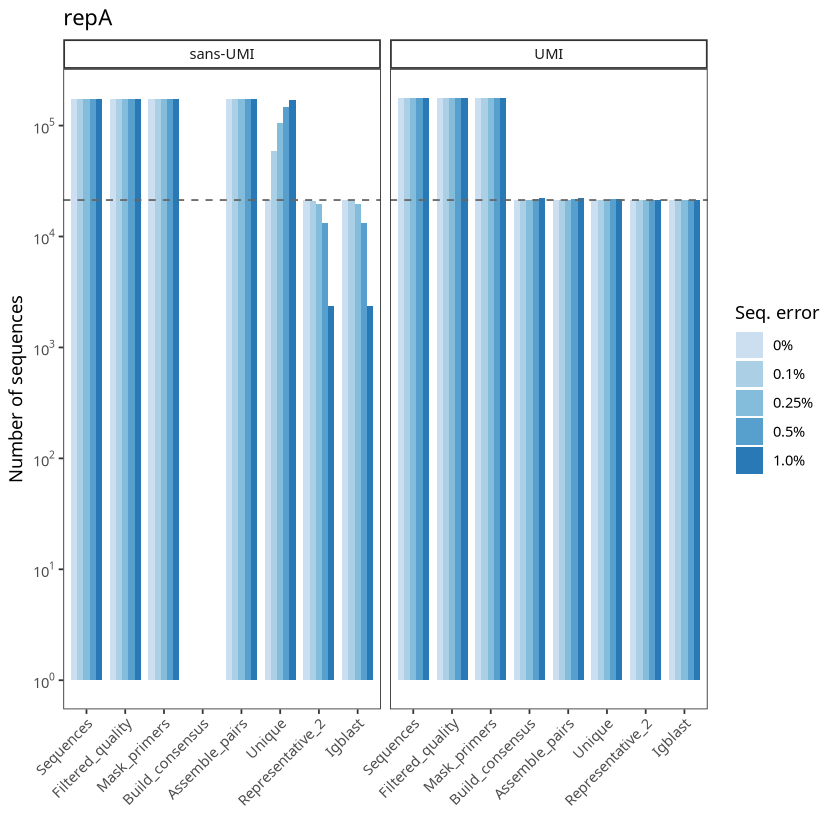

In [30]:
seq_tab_melt_A <- subset(seq_tab_melt, rep=="repA")
p_sn_A <- ggplot(seq_tab_melt_A, aes(x = variable, y = seqs)) +
    geom_bar(aes(fill = error), stat="identity", position = position_dodge(), width = 0.8) +
    geom_hline(yintercept = repA_nseq, color="grey40", linetype="dashed", linewidth = 0.5) +
    scale_y_log10(limits = NULL,
               breaks = scales::trans_breaks("log10", function(x) 10^x),
              labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    scale_fill_manual(limits = c("0%","0.1%","0.25%","0.5%", "1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%", "1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    ggtitle("Number of clones") +
    facet_grid(cols = vars(protocol), drop = T, labeller = labeller(protocol = prot.labs)) +
    labs(fill="Seq. error", x="", y="Number of sequences", title="repA") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
    
p_sn_A

In [31]:
ggsave(plot=p_sn_A, filename = paste0(results_dir,"/Sequence_numbers_repertoires_mut_A.pdf"), device="pdf", width = 15, height = 8, units="cm")

Warning message:
“Removed 5 rows containing missing values (`geom_bar()`).”


In [32]:
ggsave(plot=p_sn_A, filename = paste0(results_dir,"/Sequence_numbers_repertoires_mut_A.png"), device="png", width = 15, height = 8, units="cm")

Warning message:
“Removed 5 rows containing missing values (`geom_bar()`).”


In [33]:
# calculate true number of seqs for repB
print(nrow(repB_truth))
print(length(unique(repB_truth$sequence)))

[1] 21000
[1] 20969


In [34]:
repB_nseq = length(unique(repB_truth$sequence))

In [35]:
repB_nseq

[1] 20969

Warning message:
“Removed 5 rows containing missing values (`geom_bar()`).”


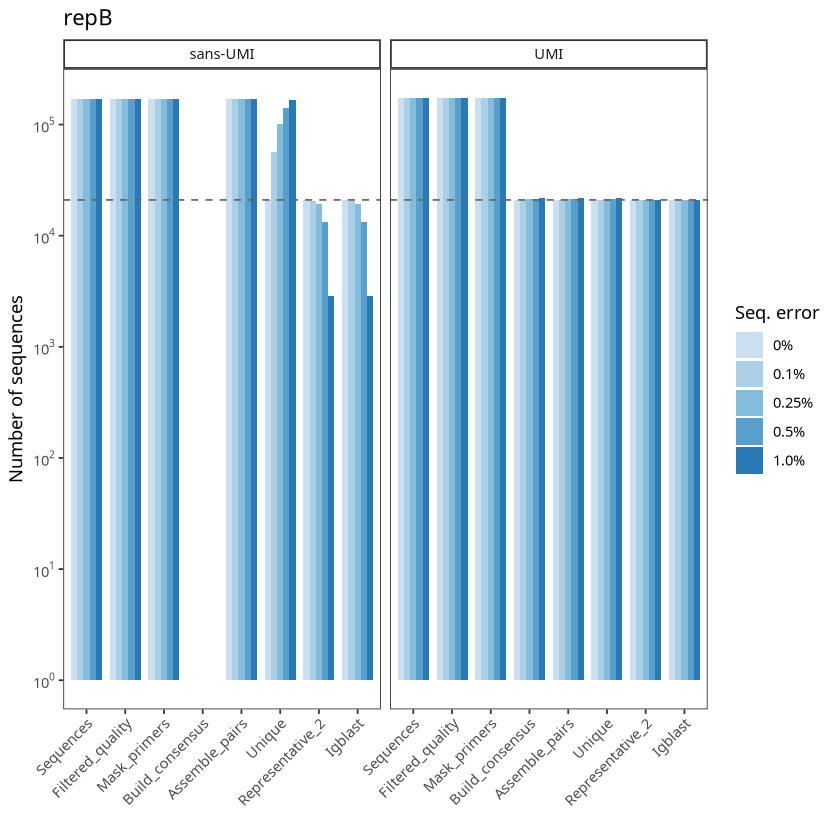

In [36]:
seq_tab_melt_B <- subset(seq_tab_melt, rep=="repB")
p_sn_B <- ggplot(seq_tab_melt_B, aes(x = variable, y = seqs)) +
    geom_bar(aes(fill = error), stat="identity", position = position_dodge(), width = 0.8) +
    geom_hline(yintercept = repB_nseq, color="grey40", linetype="dashed", linewidth = 0.5) +
    scale_y_log10(limits = NULL,
                breaks = scales::trans_breaks("log10", function(x) 10^x),
                labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    scale_fill_manual(limits = c("0%","0.1%","0.25%","0.5%", "1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%", "1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    ggtitle("Number of clones") +
    facet_grid(cols = vars(protocol), drop = T, labeller = labeller(protocol = prot.labs)) +
    labs(fill="Seq. error", x="", y="Number of sequences", title="repB") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
    
p_sn_B

In [37]:
head(seq_tab_melt_B)

sample_id error rep  protocol variable  seqs  
2  rep001    0%    repB sansumi  Sequences 169135
7  rep006    0.1%  repB sansumi  Sequences 169135
8  rep007    0.25% repB sansumi  Sequences 169135
9  rep008    0.5%  repB sansumi  Sequences 169135
10 rep009    1.0%  repB sansumi  Sequences 169135
17 rep011    0%    repB umi      Sequences 173335

In [38]:
ggsave(plot=p_sn_B, filename = paste0(results_dir,"/Sequence_numbers_repertoires_mut_repB.pdf"), device="pdf", width = 15, height = 8, units="cm")

Warning message:
“Removed 5 rows containing missing values (`geom_bar()`).”


In [39]:
ggsave(plot=p_sn_B, filename = paste0(results_dir,"/Sequence_numbers_repertoires_mut_repB.png"), device="png", width = 15, height = 8, units="cm")

Warning message:
“Removed 5 rows containing missing values (`geom_bar()`).”


In [40]:
# calculate true number of seqs for repC
print(nrow(repC_truth))
print(length(unique(repC_truth$sequence)))
repC_nseq = length(unique(repC_truth$sequence))

[1] 15404
[1] 15329


Warning message:
“Removed 5 rows containing missing values (`geom_bar()`).”


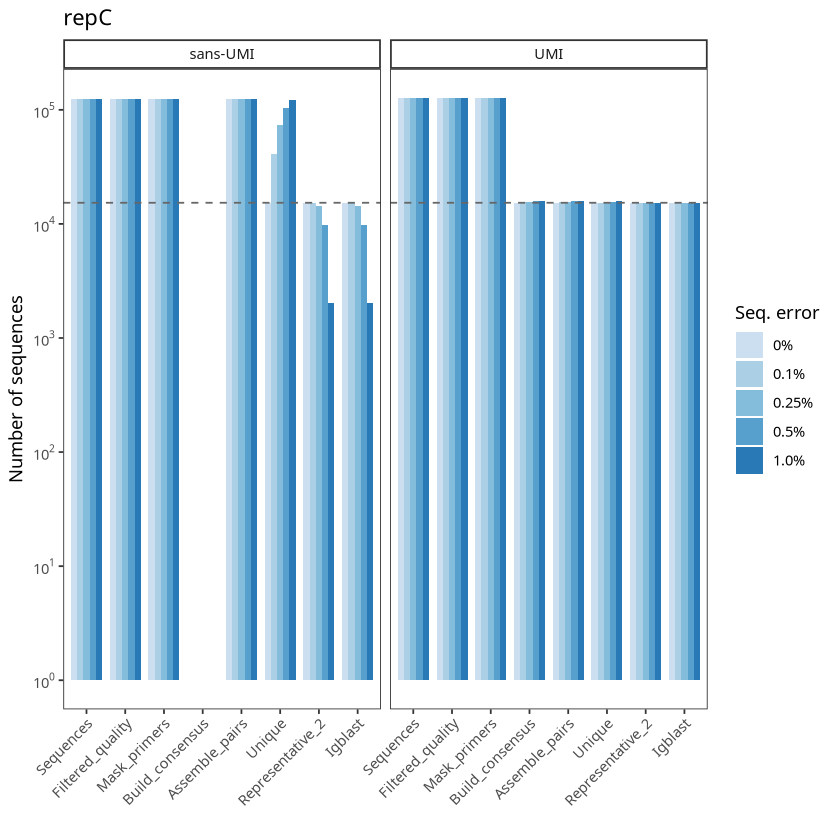

In [41]:
seq_tab_melt_C <- subset(seq_tab_melt, rep=="repC")
p_sn_C <- ggplot(seq_tab_melt_C, aes(x = variable, y = seqs)) +
    geom_bar(aes(fill = error), stat="identity", position = position_dodge(), width = 0.8) +
    geom_hline(yintercept = repC_nseq, color="grey40", linetype="dashed", linewidth = 0.5) +
    scale_y_log10(limits = NULL,
                breaks = scales::trans_breaks("log10", function(x) 10^x),
                labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    scale_fill_manual(limits = c("0%","0.1%","0.25%","0.5%", "1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%", "1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    ggtitle("Number of clones") +
    facet_grid(cols = vars(protocol), drop = T, labeller = labeller(protocol = prot.labs)) +
    labs(fill="Seq. error", x="", y="Number of sequences", title="repC") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
    
p_sn_C

In [42]:
ggsave(plot=p_sn_C, filename = paste0(results_dir,"/Sequence_numbers_repertoires_mut_repC.pdf"), device="pdf", width = 15, height = 8, units="cm")
ggsave(plot=p_sn_C, filename = paste0(results_dir,"/Sequence_numbers_repertoires_mut_repC.png"), device="png", width = 15, height = 8, units="cm")

Warning message:
“Removed 5 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 5 rows containing missing values (`geom_bar()`).”


## Number of correctly and incorrectly recovered sequences, sensitivity and FDR

In [43]:
calculate_metrics_sansumi <- function(df, df_truth){
    
    seqs_truth <- df_truth$sequence
    all_truth_seqs <- length(unique(seqs_truth))


    # Getting different kinds of missmatches
    # matched sequences
    merged_truth_df <- left_join(df, df_truth %>%
                             mutate(original_sequence = sequence,
                                   original_sequence_length = nchar(sequence)) %>% 
                             select(sequence_id, original_sequence, original_sequence_length), 
                             by=join_by(sequence_original_id == sequence_id))
    # seqs without match
    no_match <- merged_truth_df %>% filter(is.na(original_sequence))
    #print(nrow(no_match))
    
    # True missing sequences
    true_missing_df <- anti_join(df_truth %>%
                             mutate(original_sequence = sequence,
                                   original_sequence_length = nchar(sequence)) %>% 
                             select(sequence_id, original_sequence, original_sequence_length), 
                                df, 
                             by=join_by(sequence_id == sequence_original_id)) %>%
                             filter(!(original_sequence %in% merged_truth_df$original_sequence)) #remove duplicate seqs in true set that have been detected
    # Exact matches
    merged_truth_df_exactmatch <- merged_truth_df %>% filter(sequence_vdj == original_sequence)
    
    # Not exact matches
    merged_truth_df_notexactmatch <- merged_truth_df %>% filter(sequence_vdj != original_sequence)
    
    # There were no sequences with different length than the true sequences, so no need to filter for that.
    # Calculate sequence distance to original (truth) sequence
    merged_truth_df_notexactmatch$seqdiff <- mapply(seqDist, 
                                                         merged_truth_df_notexactmatch$sequence_vdj, 
                                                         merged_truth_df_notexactmatch$original_sequence, 
                                                         USE.NAMES=F)
    # Uncertain matches
    merged_truth_df_notexactmatch_dist0 <- merged_truth_df_notexactmatch %>%
                            filter(seqdiff == 0)
    
    # Missmatches
    merged_truth_df_samelength_missmatches <- merged_truth_df_notexactmatch %>%
                            filter(seqdiff > 0)
    
    # Number of exact matches
    n_exactmatch <- nrow(merged_truth_df_exactmatch)
    
    # Number of uncertain matches
    n_uncertainmatch <- nrow(merged_truth_df_notexactmatch_dist0)
    
    # Number of missmatches
    n_missmatch <- nrow(merged_truth_df_samelength_missmatches)
    
    # Number of missing sequences (False negatives)
    n_missing <- nrow(true_missing_df)
    
    # Sensitivity (exact matches)
    sensitivity <- n_exactmatch / all_truth_seqs
    
    # Sensitivity (uncertain matches)
    sensitivity_uncertain <- (n_exactmatch + n_uncertainmatch)/ all_truth_seqs
    
    # FDR with missmatches
    FDR <- (n_missmatch) / all_truth_seqs
    
    metrics_list <- list("n_exactmatch" = n_exactmatch, 
                         "n_uncertainmatch" = n_uncertainmatch, 
                         "n_missmatch" = n_missmatch,
                         "n_missing" = n_missing,
                         "sensitivity" = sensitivity,
                         "sensitivity_uncertain" = sensitivity_uncertain,
                         "FDR" = FDR,
                         "df_missmatch" = merged_truth_df_samelength_missmatches
                        )

    return(metrics_list)
}

In [44]:
calculate_metrics_umi <- function(df, df_truth){
    
    seqs_truth <- df_truth$sequence
    all_truth_seqs <- length(unique(seqs_truth))
    
    # Cannot use setdiff because of uncertain positions marked as Ns.

    # Getting different kinds of missmatches
    # matched sequences
    merged_truth_df <- left_join(df, df_truth %>%
                             mutate(original_sequence = sequence,
                                   original_sequence_length = nchar(sequence)) %>% 
                             select(sequence_id, original_sequence, original_sequence_length), 
                             by=join_by(reference == sequence_id))
    # seqs without match
    no_match <- merged_truth_df %>% filter(is.na(original_sequence))
    
    # True missing sequences
    true_missing_df <- anti_join(df_truth %>%
                             mutate(original_sequence = sequence,
                                   original_sequence_length = nchar(sequence)) %>% 
                             select(sequence_id, original_sequence, original_sequence_length), 
                                df, 
                             by=join_by(sequence_id == reference)) %>%
                             filter(!(original_sequence %in% merged_truth_df$original_sequence)) #remove duplicate seqs in true set that have been detected
    # Exact matches
    merged_truth_df_exactmatch <- merged_truth_df %>% filter(sequence_vdj == original_sequence)
    
    # Not exact matches
    merged_truth_df_notexactmatch <- merged_truth_df %>% filter(sequence_vdj != original_sequence)
    
    # There were no sequences with different length than the true sequences, so no need to filter for that.
    # Calculate sequence distance to original (truth) sequence
    merged_truth_df_notexactmatch$seqdiff <- mapply(seqDist, 
                                                         merged_truth_df_notexactmatch$sequence_vdj, 
                                                         merged_truth_df_notexactmatch$original_sequence, 
                                                         USE.NAMES=F)
    # Uncertain matches
    merged_truth_df_notexactmatch_dist0 <- merged_truth_df_notexactmatch %>%
                            filter(seqdiff == 0)
    
    # Missmatches
    merged_truth_df_samelength_missmatches <- merged_truth_df_notexactmatch %>%
                            filter(seqdiff > 0)
    
    # Number of exact matches
    n_exactmatch <- nrow(merged_truth_df_exactmatch)
    
    # Number of matches with N nucleotides
    n_uncertainmatch <- nrow(merged_truth_df_notexactmatch_dist0)
    
    # Number of missmatches
    n_missmatch <- nrow(merged_truth_df_samelength_missmatches)
    
    # Number of missing sequences (False negatives)
    n_missing <- nrow(true_missing_df)
    
    # Sensitivity (exact matches)
    sensitivity <- n_exactmatch / all_truth_seqs
    
    # Sensitivity (with N nucleotides)
    sensitivity_uncertain <- (n_exactmatch + n_uncertainmatch)/ all_truth_seqs
    
    # FDR with missmatches
    FDR <- (n_missmatch) / all_truth_seqs
    
    metrics_list <- list("n_exactmatch" = n_exactmatch, 
                         "n_uncertainmatch" = n_uncertainmatch, 
                         "n_missmatch" = n_missmatch,
                         "n_missing" = n_missing,
                         "sensitivity" = sensitivity,
                         "sensitivity_uncertain" = sensitivity_uncertain,
                         "FDR" = FDR,
                         "df_missmatch" = merged_truth_df_samelength_missmatches
                        )

    return(metrics_list)
}

In [45]:
# RepA metrics
df_truth <- repA_truth
dfs_sansumi <- list(repAmut_sans_umi, repAmut_sans_umi_01, repAmut_sans_umi_025, repAmut_sans_umi_05, repAmut_sans_umi_10)
dfs_umi <- list(repAmut_umi, repAmut_umi_01, repAmut_umi_025, repAmut_umi_05, repAmut_umi_10)
reps <- c("repA", "repA","repA","repA","repA","repA","repA","repA","repA", "repA")
prot <- c("sansumi","sansumi","sansumi","sansumi","sansumi","umi","umi","umi","umi","umi")
muts <- c("0%","0.1%","0.25%","0.5%","1.0%","0%","0.1%","0.25%","0.5%","1.0%")
FNs <- c()
FPs <- c()
TPs <- c()
FDRs <- c()
sensitivities <- c()
total_missmatch <- c()
total_exactmatch <- c()
total_uncertainmatch <- c()
total_missing <- c()
total_sensitivity_uncertain <- c()
dfs_missmatch <- list()

for (df in dfs_sansumi) {
    
    metrics <- calculate_metrics_sansumi(df, df_truth)
    
    total_exactmatch <- append(total_exactmatch, metrics$n_exactmatch)
    total_uncertainmatch <- append(total_uncertainmatch, metrics$n_uncertainmatch)
    total_missmatch <- append(total_missmatch, metrics$n_missmatch)
    total_missing <- append(total_missing, metrics$n_missing)
    sensitivities <- append(sensitivities, metrics$sensitivity)
    total_sensitivity_uncertain <- append(total_sensitivity_uncertain, metrics$sensitivity_uncertain)
    FDRs <- append(FDRs, metrics$FDR)
    dfs_missmatch <- append(dfs_missmatch, list(metrics$df_missmatch))
}
for (df in dfs_umi) {
    
    metrics <- calculate_metrics_umi(df, df_truth)

    total_exactmatch <- append(total_exactmatch, metrics$n_exactmatch)
    total_uncertainmatch <- append(total_uncertainmatch, metrics$n_uncertainmatch)
    total_missmatch <- append(total_missmatch, metrics$n_missmatch)
    total_missing <- append(total_missing, metrics$n_missing)
    sensitivities <- append(sensitivities, metrics$sensitivity)
    total_sensitivity_uncertain <- append(total_sensitivity_uncertain, metrics$sensitivity_uncertain)
    FDRs <- append(FDRs, metrics$FDR)
    dfs_missmatch <- append(dfs_missmatch, list(metrics$df_missmatch))
}



repA_metrics <- data.frame(repertoire = reps,
                           protocol = prot,
                           error = muts,
                           sensitivity = sensitivities,
                           FDR = FDRs,
                           total_missing = total_missing,
                           total_exactmatch = total_exactmatch,
                           total_missmatch = total_missmatch,
                           total_uncertainmatch = total_uncertainmatch,
                           sensitivity_uncertain = total_sensitivity_uncertain
                          )
repA_metrics

repertoire protocol error sensitivity FDR          total_missing
1  repA       sansumi  0%    0.9954505   0.000000e+00    97        
2  repA       sansumi  0.1%  0.9854603   1.219455e-03   310        
3  repA       sansumi  0.25% 0.9145912   5.768960e-03  1812        
4  repA       sansumi  0.5%  0.6099151   5.768960e-03  8274        
5  repA       sansumi  1.0%  0.1095633   1.594672e-03 18969        
6  repA       umi      0%    0.9955912   4.690212e-05    93        
7  repA       umi      0.1%  0.9921673   0.000000e+00   109        
8  repA       umi      0.25% 0.9898222   0.000000e+00   149        
9  repA       umi      0.5%  0.9846161   0.000000e+00   195        
10 repA       umi      1.0%  0.9770649   4.690212e-05   296        
   total_exactmatch total_missmatch total_uncertainmatch sensitivity_uncertain
1  21224              0               0                  0.9954505            
2  21011             26               0                  0.9854603            
3  19500            123               0                  0.9145912            
4  13004            123               0                  0.6099151            
5   2336             34               0                  0.1095633            
6  21227              1               0                  0.9955912            
7  21154              0              58                  0.9948877            
8  21104              0              68                  0.9930116            
9  20993              0             133                  0.9908541            
10 20832              1             192                  0.9860701

In [46]:
read_readid = read.csv("sim_repertoires/read_sequence_id_matches/rep010_read_sequence_id_matches.tsv", sep="\t")

In [47]:
head(read_readid %>% distinct() %>% group_by(umi)  %>% summarize(id_per_umi = n_distinct(sequence_original_id)) %>% arrange(desc(id_per_umi)),10)

umi          id_per_umi
1  AAAAGCATAGAC 2         
2  AAACCTACGAGC 2         
3  AACTTTAAGAAA 2         
4  ACATCCTGCACC 2         
5  CATATGGTAGTA 2         
6  GAACAATCCTGG 2         
7  GCAGGAAGACTC 2         
8  GCGCCACTAATG 2         
9  GCTACCGCTGCA 2         
10 GGAACTCTTTCA 2

In [48]:
read_readid %>% filter(umi == "GGAACTCTTTCA")

umi          sequence_original_id
1  GGAACTCTTTCA clone_repA_1seq7855 
2  GGAACTCTTTCA clone_repA_1seq951  
3  GGAACTCTTTCA clone_repA_1seq7855 
4  GGAACTCTTTCA clone_repA_1seq951  
5  GGAACTCTTTCA clone_repA_1seq951  
6  GGAACTCTTTCA clone_repA_1seq951  
7  GGAACTCTTTCA clone_repA_1seq951  
8  GGAACTCTTTCA clone_repA_1seq951  
9  GGAACTCTTTCA clone_repA_1seq951  
10 GGAACTCTTTCA clone_repA_1seq951  
11 GGAACTCTTTCA clone_repA_1seq7855 
12 GGAACTCTTTCA clone_repA_1seq951  
13 GGAACTCTTTCA clone_repA_1seq7855 
14 GGAACTCTTTCA clone_repA_1seq7855 
15 GGAACTCTTTCA clone_repA_1seq7855 
16 GGAACTCTTTCA clone_repA_1seq7855 
17 GGAACTCTTTCA clone_repA_1seq951  
18 GGAACTCTTTCA clone_repA_1seq951  
19 GGAACTCTTTCA clone_repA_1seq951

In [49]:
read_readid %>% filter(umi == "GGCCGTGGCCGA")

umi          sequence_original_id
1  GGCCGTGGCCGA clone_repA_1seq5620 
2  GGCCGTGGCCGA clone_repA_1seq5620 
3  GGCCGTGGCCGA clone_repA_1seq5620 
4  GGCCGTGGCCGA clone_repA_1seq5620 
5  GGCCGTGGCCGA clone_repA_1seq5620 
6  GGCCGTGGCCGA clone_repA_1seq5620 
7  GGCCGTGGCCGA clone_repA_1seq5620 
8  GGCCGTGGCCGA clone_repA_1seq5620 
9  GGCCGTGGCCGA clone_repA_1seq5620 
10 GGCCGTGGCCGA clone_repA_1seq5620 
11 GGCCGTGGCCGA clone_repA_1seq5620 
12 GGCCGTGGCCGA clone_repA_1seq5620 
13 GGCCGTGGCCGA clone_repA_1seq5620

In [50]:
repAmut_umi %>% filter(grepl("GGAACTCTTTCA", sequence_id))

sequence_id  
1 1GGAACTCTTTCA
  sequence                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1 GAAGTGCAGTTGGTGGAGTCTGGGGGCGTCGGGGTACAGTCGGGGGGGTCCCTGAGACTCTCCTGTGCAGCCCCTGGATTCACCTTTGATGATAATACCATGCACAGGGTCCGTCAAGTTCCGGGGAAGAGTCTGGAGTGGGTCTCTCTTATCAGTTGGAATGCTGGCAGAACATACTATGCAGACTCTGTGAAGGGCCGATTCACCATCTCCAGAGACAACAGAAAAAACTCCCGGGATCCGCAAATGAATAGTCTGAGAACTGAGGACACCGCCTTGTCTTACTATGCAAAAGATAGGGGGGCTAGCTATGGTTCGGGGAGTTATCATTTTGACTACTGGGGCCAAGGAACCCTTGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATTCCCCGTCGGATACGAGCAGCGTGGCCGTT
  rev_comp productive vj_in_frame stop_codon locus v_call      d_call     
1 FALSE    TRUE       TRUE        FALSE      IGH   IGHV3-43*01 IGHD3-10*01
  j_call   ⋯ d_germline_length j_germline_length
1 IGHJ4*01 ⋯ 19                43               
  germline_alignment_d_mask                                                                                                                                                                                                                                                                                                                                                                                    
1 GAAGTGCAGCTGGTGGAGTCTGGGGGA...GTCGTGGTACAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTT............GATGATTATACCATGCACTGGGTCCGTCAAGCTCCGGGGAAGGGTCTGGAGTGGGTCTCTCTTATTAGTTGGGAT......GGTGGTAGCACATACTATGCAGACTCTGTGAAG...GGCCGATTCACCATCTCCAGAGACAACAGCAAAAACTCCCTGTATCTGCAAATGAACAGTCTGAGAACTGAGGACACCGCCTTGTATTACTGTGCAAAAGATNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTTTGACTACTGGGGCCAAGGAACCCTGGTCACCGTCTCCTCAG
  clone_size_count clone_size_freq mu_freq    repertoire  rep_group
1 9054             0.43            0.06784661 repA_00_umi umi      
  sequence_vdj                                                                                                                                                                                                                                                                                                                                                                        
1 GAAGTGCAGTTGGTGGAGTCTGGGGGCGTCGGGGTACAGTCGGGGGGGTCCCTGAGACTCTCCTGTGCAGCCCCTGGATTCACCTTTGATGATAATACCATGCACAGGGTCCGTCAAGTTCCGGGGAAGAGTCTGGAGTGGGTCTCTCTTATCAGTTGGAATGCTGGCAGAACATACTATGCAGACTCTGTGAAGGGCCGATTCACCATCTCCAGAGACAACAGAAAAAACTCCCGGGATCCGCAAATGAATAGTCTGAGAACTGAGGACACCGCCTTGTCTTACTATGCAAAAGATAGGGGGGCTAGCTATGGTTCGGGGAGTTATCATTTTGACTACTGGGGCCAAGGAACCCTTGTCACCGTCTCCTCA
  sequence_vdj_length
1 372

In [51]:
repAmut_umi_10 %>% filter(grepl("GGAACTCTTTCA", sequence_id))

sequence_id  
1 2GGAACTCTTTCA
2 1GGAACTCTTTCA
  sequence                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1 GAAGTGCAGTTGGTGGAGTCTGGGGGCGTCGGGGTACAGTCGGGGGGGTCCCTGAGACTCTCCTGTGCAGCCCCTGGATTCACCTTTGATGATAATACCATGCACAGGGTCCGTCAAGTTCCGGGGAAGAGTCTGGAGTGGGTCTCTCTTATCAGTTGGAATGCTGGCAGAACATACTATGCAGACTCTGTGAAGGGCCGATTCACCATCTCCAGAGACAACAGAAAAAACTCCCGGGATCCGCAAATGAATAGTCTGAGAACTGAGGACACCGCCTTGTATTACTGTGTAAAAGATAGGGGGGCTAGCTATGGTTCGGGGAGTTGTTGTTTTGGCAACTGGGGCCAGGGAACACTGGTCACCGCCTCCCCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATTCCCCGTCGGATACGAGCAGCGTGGCCGTT
2 GATGTTCAGCTGGTGGAGTCTGGGCGAGTCGTGCTACAACCTGGGGGGTCCCTGAGACTGTCCTGTGCAGCCTCTGGATTCACCTTTGATCATTATACCATGAACTGGGTCCGTCAAGCTCCGGGGAAGGGTCTGGAGTGGGTCTCTCTCATTAGTTGGAACGGTGGTAGAACATACTATGCAGACTCTGTGAAGGGCCGATCCACCATCTCCAGAGATAACAGCAAAAACTCCCTGTGTCTGCAAAGGAACAGTCTGAGAACTGAGGACACCGCCTTGTCTTACTATGCAAAAGATAGGGGGGCTAGCTATGGTTCGGGGAGTTATCATTTTGACTACTGGGGCCAAGGAACCCTTGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATTCCCCGTCGGATACGAGCAGCGTGGCCGTT
  rev_comp productive vj_in_frame stop_codon locus v_call      d_call     
1 FALSE    TRUE       TRUE        FALSE      IGH   IGHV3-43*01 IGHD3-10*01
2 FALSE    TRUE       TRUE        FALSE      IGH   IGHV3-43*01 IGHD3-10*01
  j_call   ⋯ d_germline_length j_germline_length
1 IGHJ4*02 ⋯ 17                43               
2 IGHJ4*01 ⋯ 19                43               
  germline_alignment_d_mask                                                                                                                                                                                                                                                                                                                                                                                    
1 GAAGTGCAGCTGGTGGAGTCTGGGGGA...GTCGTGGTACAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTT............GATGATTATACCATGCACTGGGTCCGTCAAGCTCCGGGGAAGGGTCTGGAGTGGGTCTCTCTTATTAGTTGGGAT......GGTGGTAGCACATACTATGCAGACTCTGTGAAG...GGCCGATTCACCATCTCCAGAGACAACAGCAAAAACTCCCTGTATCTGCAAATGAACAGTCTGAGAACTGAGGACACCGCCTTGTATTACTGTGCAAAAGATNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTTTGACTACTGGGGCCAAGGAACCCTGGTCACCGTCTCCTCAG
2 GAAGTGCAGCTGGTGGAGTCTGGGGGA...GTCGTGGTACAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTT............GATGATTATACCATGCACTGGGTCCGTCAAGCTCCGGGGAAGGGTCTGGAGTGGGTCTCTCTTATTAGTTGGGAT......GGTGGTAGCACATACTATGCAGACTCTGTGAAG...GGCCGATTCACCATCTCCAGAGACAACAGCAAAAACTCCCTGTATCTGCAAATGAACAGTCTGAGAACTGAGGACACCGCCTTGTATTACTGTGCAAAAGATNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTTTGACTACTGGGGCCAAGGAACCCTGGTCACCGTCTCCTCAG
  clone_size_count clone_size_freq mu_freq    repertoire  rep_group
1 8977             0.43            0.07964602 repA_10_umi umi      
2 8977             0.43            0.05604720 repA_10_umi umi      
  sequence_vdj                                                                                                                                                                                                                                                                                                                                                                        
1 GAAGTGCAGTTGGTGGAGTCTGGGGGCGTCGGGGTACAGTCGGGGGGGTCCCTGAGACTCTCCTGTGCAGCCCCTGGATTCACCTTTGATGATAATACCATGCACAGGGTCCGTCAAGTTCCGGGGAAGAGTCTGGAGTGGGTCTCTCTTATCAGTTGGAATGCTGGCAGAACATACTATGCAGACTCTGTGAAGGGCCGATTCACCATCTCCAGAGACAACAGAAAAAACTCCCGGGATCCGCAAATGAATAGTCTGAGAACTGAGGACACCGCCTTGTATTACTGTGTAAAAGATAGGGGGGCTAGCTATGGTTCGGGGAGTTGTTGTTTTGGCAACTGGGGCCAGGGAACACTGGTCACCGCCTCCCCA
2 GATGTTCAGCTGGTGGAGTCTGGGCGAGTCGTGCTACAACCTGGGGGGTCCCTGAGACTGTCCTGTG

In [52]:
dfs_missmatch[[6]] %>% select(sequence_id, reference, sequence_vdj, sequence_vdj_length, original_sequence, seqdiff)

sequence_id   reference          
1 1GGAACTCTTTCA clone_repA_1seq7855
  sequence_vdj                                                                                                                                                                                                                                                                                                                                                                        
1 GAAGTGCAGTTGGTGGAGTCTGGGGGCGTCGGGGTACAGTCGGGGGGGTCCCTGAGACTCTCCTGTGCAGCCCCTGGATTCACCTTTGATGATAATACCATGCACAGGGTCCGTCAAGTTCCGGGGAAGAGTCTGGAGTGGGTCTCTCTTATCAGTTGGAATGCTGGCAGAACATACTATGCAGACTCTGTGAAGGGCCGATTCACCATCTCCAGAGACAACAGAAAAAACTCCCGGGATCCGCAAATGAATAGTCTGAGAACTGAGGACACCGCCTTGTCTTACTATGCAAAAGATAGGGGGGCTAGCTATGGTTCGGGGAGTTATCATTTTGACTACTGGGGCCAAGGAACCCTTGTCACCGTCTCCTCA
  sequence_vdj_length
1 372                
  original_sequence                                                                                                                                                                                                                                                                                                                                                                   
1 GAAGTGCAGTTGGTGGAGTCTGGGGGCGTCGGGGTACAGTCGGGGGGGTCCCTGAGACTCTCCTGTGCAGCCCCTGGATTCACCTTTGATGATAATACCATGCACAGGGTCCGTCAAGTTCCGGGGAAGAGTCTGGAGTGGGTCTCTCTTATCAGTTGGAATGCTGGCAGAACATACTATGCAGACTCTGTGAAGGGCCGATTCACCATCTCCAGAGACAACAGAAAAAACTCCCGGGATCCGCAAATGAATAGTCTGAGAACTGAGGACACCGCCTTGTATTACTGTGTAAAAGATAGGGGGGCTAGCTATGGTTCGGGGAGTTGTTGTTTTGGCAACTGGGGCCAGGGAACACTGGTCACCGCCTCCCCA
  seqdiff
1 13

In [53]:
dfs_missmatch[[10]] %>% select(sequence_id, reference, sequence_vdj, sequence_vdj_length, original_sequence, seqdiff)

sequence_id   reference          
1 1GGCCGTGGCCGA clone_repA_1seq5620
  sequence_vdj                                                                                                                                                                                                                                                                                                                                                                        
1 GAGGTGCAGGTGTTGGAGTCTGGGGGAGTCGTGGTACAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGCCTTCACCTTTGATGATTTNGCCATCCTCTGGGTCCGTCAAGCTCCGNGGACGGGTCTGGACTGGGTCTCTCTTCTTAGTTGGGATGGTGNTAGAATGTACTCTGCAGACTCTGTGCCGGGCCGATTCACCCTCTCCAGAGACAATACAAGAAAATCCCTGTATCTGAAAATGAACAGTCTGAGAAGTGAAGACACCGCCTCATACTGCTCTGCAAAAAATCGGGGGGCTAGTTTTGGTTCGGGAAGTTATCATTTCGACTACTGGGGCCAACGACCCCTGGTCACCGTCTCCTCA
  sequence_vdj_length
1 372                
  original_sequence                                                                                                                                                                                                                                                                                                                                                                   
1 GAGGTGCAGGTGTTGGAGTCTGGGGGAGTCGTGGTACAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGCCTTCACCTTTGATGATTTTGCCATCCTCTGGGTCCGTCAAGCTCCGGGGACGGGTCTGGACTGGGTCTCTCTTATTAGTTGGGATGGTGGTAGAATGTACTCTGCAGACTCTGTGCCGGGCCGATTCACCCTCTCCAGAGACAATACAAGAAAATCCCTGTATCTGAAAATGAACAGTCTGAGAAGTGAAGACACCGCCTCATACTGCTCTGCAAAAAATCGGGGGGCTAGTTTTGGTTCGGGAAGTTATCATTTCGACTACTGGGGCCAACGACCCCTGGTCACCGTCTCCTCA
  seqdiff
1 1

In [54]:
read_readid = read.csv("sim_repertoires/read_sequence_id_matches/rep015_read_sequence_id_matches.tsv", sep="\t")

In [55]:
read_readid %>% filter(umi == "GGCCGTGGCCGA")

umi          sequence_original_id
1 GGCCGTGGCCGA clone_repA_1seq5620 
2 GGCCGTGGCCGA clone_repA_1seq5620

In [56]:
repAmut_umi_10 %>% filter(grepl("GGCCGTGGCCGA", sequence_id))

sequence_id  
1 1GGCCGTGGCCGA
  sequence                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1 GAGGTGCAGGTGTTGGAGTCTGGGGGAGTCGTGGTACAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGCCTTCACCTTTGATGATTTNGCCATCCTCTGGGTCCGTCAAGCTCCGNGGACGGGTCTGGACTGGGTCTCTCTTCTTAGTTGGGATGGTGNTAGAATGTACTCTGCAGACTCTGTGCCGGGCCGATTCACCCTCTCCAGAGACAATACAAGAAAATCCCTGTATCTGAAAATGAACAGTCTGAGAAGTGAAGACACCGCCTCATACTGCTCTGCAAAAAATCGGGGGGCTAGTTTTGGTTCGGGAAGTTATCATTTCGACTACTGGGGCCAACGACCCCTGGTCACCGTCTCCTCAGGGAGTGCATCCGNCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATTCCCCGTCGGATACGAGCAGCGTGGCCGTT
  rev_comp productive vj_in_frame stop_codon locus v_call      d_call     
1 FALSE    TRUE       TRUE        FALSE      IGH   IGHV3-43*01 IGHD3-10*01
  j_call   ⋯ d_germline_length j_germline_length
1 IGHJ5*01 ⋯ 16                43               
  germline_alignment_d_mask                                                                                                                                                                                                                                                                                                                                                                                    
1 GAAGTGCAGCTGGTGGAGTCTGGGGGA...GTCGTGGTACAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTT............GATGATTATACCATGCACTGGGTCCGTCAAGCTCCGGGGAAGGGTCTGGAGTGGGTCTCTCTTATTAGTTGGGAT......GGTGGTAGCACATACTATGCAGACTCTGTGAAG...GGCCGATTCACCATCTCCAGAGACAACAGCAAAAACTCCCTGTATCTGCAAATGAACAGTCTGAGAACTGAGGACACCGCCTTGTATTACTGTGCAAAAGATNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTTTGACTACTGGGGCCAAGGAACCCTGGTCACCGTCTCCTCAG
  clone_size_count clone_size_freq mu_freq  repertoire  rep_group
1 8977             0.43            0.110119 repA_10_umi umi      
  sequence_vdj                                                                                                                                                                                                                                                                                                                                                                        
1 GAGGTGCAGGTGTTGGAGTCTGGGGGAGTCGTGGTACAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGCCTTCACCTTTGATGATTTNGCCATCCTCTGGGTCCGTCAAGCTCCGNGGACGGGTCTGGACTGGGTCTCTCTTCTTAGTTGGGATGGTGNTAGAATGTACTCTGCAGACTCTGTGCCGGGCCGATTCACCCTCTCCAGAGACAATACAAGAAAATCCCTGTATCTGAAAATGAACAGTCTGAGAAGTGAAGACACCGCCTCATACTGCTCTGCAAAAAATCGGGGGGCTAGTTTTGGTTCGGGAAGTTATCATTTCGACTACTGGGGCCAACGACCCCTGGTCACCGTCTCCTCA
  sequence_vdj_length
1 372

In [57]:
# RepB metrics
df_truth <- repB_truth
dfs_sansumi <- list(repBmut_sans_umi, repBmut_sans_umi_01, repBmut_sans_umi_025, repBmut_sans_umi_05, repBmut_sans_umi_10)
dfs_umi <- list(repBmut_umi, repBmut_umi_01, repBmut_umi_025, repBmut_umi_05, repBmut_umi_10)
                   
reps <- c("repB", "repB","repB","repB","repB","repB","repB","repB","repB","repB")
prot <- c("sansumi","sansumi","sansumi","sansumi","sansumi","umi","umi","umi","umi","umi")
muts <- c("0%","0.1%","0.25%","0.5%","1.0%","0%","0.1%", "0.25%","0.5%","1.0%")
FNs <- c()
FPs <- c()
TPs <- c()
FDRs <- c()
sensitivities <- c()
total_missmatch <- c()
total_exactmatch <- c()
total_uncertainmatch <- c()
total_missing <- c()
total_sensitivity_uncertain <- c()
dfs_missmatch <- list()

for (df in dfs_sansumi) {
    
    metrics <- calculate_metrics_sansumi(df, df_truth)
    
    total_exactmatch <- append(total_exactmatch, metrics$n_exactmatch)
    total_uncertainmatch <- append(total_uncertainmatch, metrics$n_uncertainmatch)
    total_missmatch <- append(total_missmatch, metrics$n_missmatch)
    total_missing <- append(total_missing, metrics$n_missing)
    sensitivities <- append(sensitivities, metrics$sensitivity)
    total_sensitivity_uncertain <- append(total_sensitivity_uncertain, metrics$sensitivity_uncertain)
    FDRs <- append(FDRs, metrics$FDR)
    dfs_missmatch <- append(dfs_missmatch, list(metrics$df_missmatch))
}
for (df in dfs_umi) {
    
    metrics <- calculate_metrics_umi(df, df_truth)
    
    total_exactmatch <- append(total_exactmatch, metrics$n_exactmatch)
    total_uncertainmatch <- append(total_uncertainmatch, metrics$n_uncertainmatch)
    total_missmatch <- append(total_missmatch, metrics$n_missmatch)
    total_missing <- append(total_missing, metrics$n_missing)
    sensitivities <- append(sensitivities, metrics$sensitivity)
    total_sensitivity_uncertain <- append(total_sensitivity_uncertain, metrics$sensitivity_uncertain)
    FDRs <- append(FDRs, metrics$FDR)
    dfs_missmatch <- append(dfs_missmatch, list(metrics$df_missmatch))
}


repB_metrics <- data.frame( repertoire = reps,
                           protocol = prot,
                           error = muts,
                           sensitivity = sensitivities,
                           FDR = FDRs,
                           total_missing = total_missing,
                           total_exactmatch = total_exactmatch,
                           total_missmatch = total_missmatch,
                           total_uncertainmatch = total_uncertainmatch,
                           sensitivity_uncertain = total_sensitivity_uncertain
                          )
repB_metrics

repertoire protocol error sensitivity FDR          total_missing
1  repB       sansumi  0%    0.9967094   0.000000e+00    69        
2  repB       sansumi  0.1%  0.9856932   5.245839e-04   300        
3  repB       sansumi  0.25% 0.9162096   5.531976e-03  1750        
4  repB       sansumi  0.5%  0.6314560   5.818112e-03  7691        
5  repB       sansumi  1.0%  0.1346273   1.669131e-03 18138        
6  repB       umi      0%    0.9967094   0.000000e+00    69        
7  repB       umi      0.1%  0.9919405   0.000000e+00   113        
8  repB       umi      0.25% 0.9883161   0.000000e+00   149        
9  repB       umi      0.5%  0.9862178   4.768945e-05   173        
10 repB       umi      1.0%  0.9816396   4.768945e-05   218        
   total_exactmatch total_missmatch total_uncertainmatch sensitivity_uncertain
1  20900              0               0                  0.9967094            
2  20669             11               0                  0.9856932            
3  19212            116               0                  0.9162096            
4  13241            122               0                  0.6314560            
5   2823             35               0                  0.1346273            
6  20900              0               0                  0.9967094            
7  20800              0              56                  0.9946111            
8  20724              0              96                  0.9928943            
9  20680              1             115                  0.9917020            
10 20584              1             166                  0.9895560

In [58]:
read_readid = read.csv("sim_repertoires/read_sequence_id_matches/rep018_read_sequence_id_matches.tsv", sep="\t")

In [59]:
read_readid %>% distinct() %>% group_by(umi)  %>% summarize(id_per_umi = n_distinct(sequence_original_id)) %>% arrange(desc(id_per_umi))

umi          id_per_umi
1     AAAAGCATAGAC 2         
2     AAACCTACGAGC 2         
3     AACTTTAAGAAA 2         
4     ACATCCTGCACC 2         
5     CATATGGTAGTA 2         
6     GAACAATCCTGG 2         
7     GCAGGAAGACTC 2         
8     GCGCCACTAATG 2         
9     GCTACCGCTGCA 2         
10    GGAACTCTTTCA 2         
11    GGCGACTTGTCC 2         
12    GTTCTCAGCTAC 2         
13    TAACAATTATCG 2         
14    TTCCTTCCTCAG 2         
15    AAAAAACACCTA 1         
16    AAAAAACTGAGA 1         
17    AAAAAAGGTATG 1         
18    AAAAAATACCAC 1         
19    AAAAAATTGATC 1         
20    AAAAACACCTGA 1         
21    AAAAAGACTAGC 1         
22    AAAAAGCGTTTA 1         
23    AAAAAGGAAATA 1         
24    AAAAAGTAGTCC 1         
25    AAAAAGTTCGGG 1         
26    AAAAATAAGCAT 1         
27    AAAAATACGGTC 1         
28    AAAAATCGGACG 1         
29    AAAAATGTTATT 1         
30    AAAAATTGCTTT 1         
⋮     ⋮            ⋮         
20954 TTTTGTACTATC 1         
20955 TTTTGTAGAAAT 1         
20956 TTTTGTAGTGAG 1         
20957 TTTTGTCCTTTC 1         
20958 TTTTGTGGGACC 1         
20959 TTTTGTTGAATC 1         
20960 TTTTGTTGAGTA 1         
20961 TTTTTAAGCATT 1         
20962 TTTTTAAGCCAG 1         
20963 TTTTTAAGTTGA 1         
20964 TTTTTAGAATGT 1         
20965 TTTTTAGCCTAG 1         
20966 TTTTTAGCGCAT 1         
20967 TTTTTATTGCGG 1         
20968 TTTTTCCTCAAA 1         
20969 TTTTTCGAAACA 1         
20970 TTTTTCGAGCTT 1         
20971 TTTTTCGTCGTG 1         
20972 TTTTTCTCCTGT 1         
20973 TTTTTGAAGCCT 1         
20974 TTTTTGTCATAA 1         
20975 TTTTTGTGTATA 1         
20976 TTTTTTAACCTC 1         
20977 TTTTTTATCTTT 1         
20978 TTTTTTCAACTA 1         
20979 TTTTTTCAGACT 1         
20980 TTTTTTGGCGCA 1         
20981 TTTTTTTGAGCT 1         
20982 TTTTTTTGATTC 1         
20983 TTTTTTTGCTGT 1

In [60]:
read_readid %>% filter(umi == "GTAATGGTTGGT")

umi          sequence_original_id         
1 GTAATGGTTGGT clone_repB_singleton_4362seq1
2 GTAATGGTTGGT clone_repB_singleton_4362seq1

In [61]:
dfs_missmatch[[9]] %>% select(sequence_id, reference, sequence_vdj, sequence_vdj_length, original_sequence, seqdiff)

sequence_id   reference                    
1 1GTAATGGTTGGT clone_repB_singleton_4362seq1
  sequence_vdj                                                                                                                                                                                                                                                                                                                                                   
1 GAGGTGCAGCTGGTGGAGTCTGGGGGAGGTGTGGTACGGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTTGATGATTATGGCATGAGCTGGGTCCGCCAAGCTCCAGGNCAGGGGCTGGAGTGGGTCTCTGGTATTAATTGGAATGGTGGTAGCACAGGTTATGCAGACTCTGTGAAGGGCCGATTCACCATCTCCAGAGACAACGCCAAGAACTCCCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCCTTGTATCACTGTGCGAGAGAGAAGGTATGGGACTTTGACTACTGGGGCCAAGGAACCCTGGTCACCGTCTCCTCA
  sequence_vdj_length
1 351                
  original_sequence                                                                                                                                                                                                                                                                                                                                              
1 GAGGTGCAGCTGGTGGAGTCTGGGGGAGGTGTGGTACGGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTTGATGATTATGGCATGAGCTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGAGTGGGTCTCTGGTATTAATTGGAATGGTGGTAGCACAGGTTATGCAGACTCTGTGAAGGGCCGATTCACCATCTCCAGAGACAACGCCAAGAACTCCCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCCTTGTATCACTGTGCGAGAGAGAAGGTATGGGACTTTGACTACTGGGGCCAAGGAACCCTGGTCACCGTCTCCTCA
  seqdiff
1 1

In [62]:
dfs_missmatch[[10]] %>% select(sequence_id, reference, sequence_vdj, sequence_vdj_length, original_sequence, seqdiff)

sequence_id   reference         
1 1GTCCACACTAGT clone_repB_69seq76
  sequence_vdj                                                                                                                                                                                                                                                                                                                                                                        
1 GAGGCGCAGGTGGTGGAGTCTGGGGGAGGCTCGGTACAGCCTGGGGGGTCCCTGANACTCTCCTGTGCAGCCTCTGGATTCACCTTCAGTAGGTATGACATCCACTGGGTCCGCCACGCTACAGGCNAAGGTCTGGNGTGGGACTCAGGTATTGTTACTGCTGGTGACACATACTATTCAGGCTCCGTGAAGGGCCGATTCACCATCTCCAGAGAAAATGCCAAAAACTCTTTGTATCTTCAAATGAACAGCCTGAGAGCCGGGGACACGGCTGTGTATTACTGTGCAAGAGACAAGGGGTATAACTGGAACTGCTCTTACTGCTACGGTATGGACGTCAGGGGGCAAGGGACCACGGTCACCGTNTCCNCA
  sequence_vdj_length
1 372                
  original_sequence                                                                                                                                                                                                                                                                                                                                                                   
1 GAGGCGCAGGTGGTGGAGTCTGGGGGAGGCTCGGTACAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTCAGTAGGTATGACATCCACTGGGTCCGCCACGCTACAGGCAAAGGTCTGGAGTGGGACTCAGGTATTGTTACTGCTGGTGACACATACTATTCAGGCTCCGTGAAGGGCCGATTCACCATCTCCAGAGAAAATGCCAAAAACTCTTTGTATCTTCAAATGAACAGCCTGAGAGCCGGGGACACGGCTGTGTATTACTGTGCAAGAGACAAGGGGTATAACTGGAACTGCTCTTACTGCTACGGTATGGACGTCTGGGGGCAAGGGACCACGGTCACCGTCTCCCCA
  seqdiff
1 1

In [63]:
# RepC metrics
df_truth <- repC_truth
dfs_sansumi <- list(repCmut_sans_umi, repCmut_sans_umi_01, repCmut_sans_umi_025, repCmut_sans_umi_05, repCmut_sans_umi_10)
dfs_umi <- list(repCmut_umi, repCmut_umi_01, repCmut_umi_025, repCmut_umi_05, repCmut_umi_10)
reps <- c("repC", "repC","repC","repC","repC","repC","repC","repC","repC", "repC")
prot <- c("sansumi","sansumi","sansumi","sansumi","sansumi","umi","umi","umi","umi","umi")
muts <- c("0%","0.1%","0.25%","0.5%","1.0%","0%","0.1%","0.25%","0.5%","1.0%")
FNs <- c()
FPs <- c()
TPs <- c()
FDRs <- c()
sensitivities <- c()
total_missmatch <- c()
total_exactmatch <- c()
total_uncertainmatch <- c()
total_missing <- c()
total_sensitivity_uncertain <- c()
dfs_missmatch <- list()

for (df in dfs_sansumi) {
    
    metrics <- calculate_metrics_sansumi(df, df_truth)
    
    total_exactmatch <- append(total_exactmatch, metrics$n_exactmatch)
    total_uncertainmatch <- append(total_uncertainmatch, metrics$n_uncertainmatch)
    total_missmatch <- append(total_missmatch, metrics$n_missmatch)
    total_missing <- append(total_missing, metrics$n_missing)
    sensitivities <- append(sensitivities, metrics$sensitivity)
    total_sensitivity_uncertain <- append(total_sensitivity_uncertain, metrics$sensitivity_uncertain)
    FDRs <- append(FDRs, metrics$FDR)
    dfs_missmatch <- append(dfs_missmatch, list(metrics$df_missmatch))

}
for (df in dfs_umi) {
    
    metrics <- calculate_metrics_umi(df, df_truth)
    
    total_exactmatch <- append(total_exactmatch, metrics$n_exactmatch)
    total_uncertainmatch <- append(total_uncertainmatch, metrics$n_uncertainmatch)
    total_missmatch <- append(total_missmatch, metrics$n_missmatch)
    total_missing <- append(total_missing, metrics$n_missing)
    sensitivities <- append(sensitivities, metrics$sensitivity)
    total_sensitivity_uncertain <- append(total_sensitivity_uncertain, metrics$sensitivity_uncertain)
    FDRs <- append(FDRs, metrics$FDR)
    dfs_missmatch <- append(dfs_missmatch, list(metrics$df_missmatch))

}

repC_metrics <- data.frame( repertoire = reps,
                           protocol = prot,
                           error = muts,
                           sensitivity = sensitivities,
                           FDR = FDRs,
                           total_missing = total_missing,
                           total_exactmatch = total_exactmatch,
                           total_missmatch = total_missmatch,
                           total_uncertainmatch = total_uncertainmatch,
                           sensitivity_uncertain = total_sensitivity_uncertain
                          )
repC_metrics


repertoire protocol error sensitivity FDR         total_missing
1  repC       sansumi  0%    0.9946507   0.000000000    82        
2  repC       sansumi  0.1%  0.9855176   0.001435188   222        
3  repC       sansumi  0.25% 0.9206732   0.005349338  1208        
4  repC       sansumi  0.5%  0.6345489   0.006132168  5581        
5  repC       sansumi  1.0%  0.1301455   0.002283254 13352        
6  repC       umi      0%    0.9958901   0.000000000    63        
7  repC       umi      0.1%  0.9934764   0.000000000    71        
8  repC       umi      0.25% 0.9885185   0.000000000    99        
9  repC       umi      0.5%  0.9857134   0.000000000   138        
10 repC       umi      1.0%  0.9806902   0.000000000   177        
   total_exactmatch total_missmatch total_uncertainmatch sensitivity_uncertain
1  15247             0                0                  0.9946507            
2  15107            22                0                  0.9855176            
3  14113            82                0                  0.9206732            
4   9727            94                0                  0.6345489            
5   1995            35                0                  0.1301455            
6  15266             0                0                  0.9958901            
7  15229             0               29                  0.9953683            
8  15153             0               77                  0.9935417            
9  15110             0               81                  0.9909975            
10 15033             0              119                  0.9884533

In [64]:
dfs_missmatch[[10]] %>% select(sequence_id, reference, sequence_vdj, sequence_vdj_length, original_sequence, seqdiff)

sequence_id reference sequence_vdj sequence_vdj_length original_sequence
     seqdiff

In [65]:
all_metrics <- rbind(repA_metrics, repB_metrics, repC_metrics)

In [66]:
all_metrics

repertoire protocol error sensitivity FDR          total_missing
1  repA       sansumi  0%    0.9954505   0.000000e+00    97        
2  repA       sansumi  0.1%  0.9854603   1.219455e-03   310        
3  repA       sansumi  0.25% 0.9145912   5.768960e-03  1812        
4  repA       sansumi  0.5%  0.6099151   5.768960e-03  8274        
5  repA       sansumi  1.0%  0.1095633   1.594672e-03 18969        
6  repA       umi      0%    0.9955912   4.690212e-05    93        
7  repA       umi      0.1%  0.9921673   0.000000e+00   109        
8  repA       umi      0.25% 0.9898222   0.000000e+00   149        
9  repA       umi      0.5%  0.9846161   0.000000e+00   195        
10 repA       umi      1.0%  0.9770649   4.690212e-05   296        
11 repB       sansumi  0%    0.9967094   0.000000e+00    69        
12 repB       sansumi  0.1%  0.9856932   5.245839e-04   300        
13 repB       sansumi  0.25% 0.9162096   5.531976e-03  1750        
14 repB       sansumi  0.5%  0.6314560   5.818112e-03  7691        
15 repB       sansumi  1.0%  0.1346273   1.669131e-03 18138        
16 repB       umi      0%    0.9967094   0.000000e+00    69        
17 repB       umi      0.1%  0.9919405   0.000000e+00   113        
18 repB       umi      0.25% 0.9883161   0.000000e+00   149        
19 repB       umi      0.5%  0.9862178   4.768945e-05   173        
20 repB       umi      1.0%  0.9816396   4.768945e-05   218        
21 repC       sansumi  0%    0.9946507   0.000000e+00    82        
22 repC       sansumi  0.1%  0.9855176   1.435188e-03   222        
23 repC       sansumi  0.25% 0.9206732   5.349338e-03  1208        
24 repC       sansumi  0.5%  0.6345489   6.132168e-03  5581        
25 repC       sansumi  1.0%  0.1301455   2.283254e-03 13352        
26 repC       umi      0%    0.9958901   0.000000e+00    63        
27 repC       umi      0.1%  0.9934764   0.000000e+00    71        
28 repC       umi      0.25% 0.9885185   0.000000e+00    99        
29 repC       umi      0.5%  0.9857134   0.000000e+00   138        
30 repC       umi      1.0%  0.9806902   0.000000e+00   177        
   total_exactmatch total_missmatch total_uncertainmatch sensitivity_uncertain
1  21224              0               0                  0.9954505            
2  21011             26               0                  0.9854603            
3  19500            123               0                  0.9145912            
4  13004            123               0                  0.6099151            
5   2336             34               0                  0.1095633            
6  21227              1               0                  0.9955912            
7  21154              0              58                  0.9948877            
8  21104              0              68                  0.9930116            
9  20993              0             133                  0.9908541            
10 20832              1             192                  0.9860701            
11 20900              0               0                  0.9967094            
12 20669             11               0                  0.9856932            
13 19212            116               0                  0.9162096            
14 13241            122               0                  0.6314560            
15  2823             35               0                  0.1346273            
16 20900              0               0                  0.9967094            
17 20800              0              56                  0.9946111            
18 20724              0              96                  0.9928943            
19 20680              1             115                  0.9917020            
20 20584              1             166                  0.9895560            
21 15247              0               0                  0.9946507            
22 15107             22               0                  0.9855176            
23 14113             82               0                  0.9206732            

In [67]:
write.table(all_metrics,paste0(results_dir,"/sequence_sensitivity_fdr_mut.tsv"),sep="\t",row.names=F, col.names = T, quote=F)

### Sensitivity

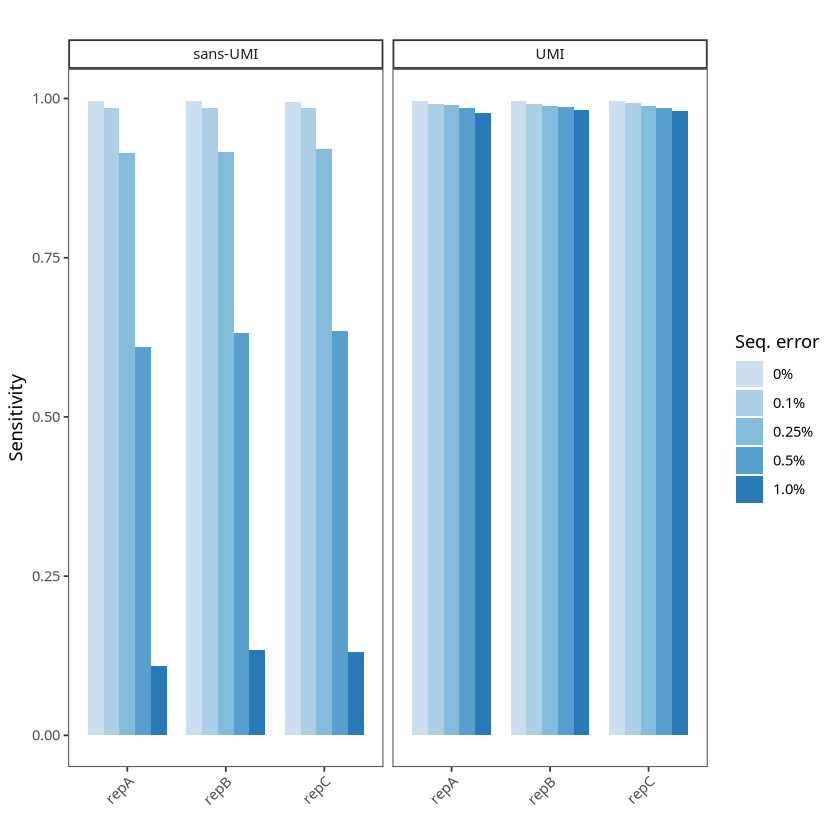

In [68]:
all_metrics$error <- factor(all_metrics$error, levels = c("0%","0.1%","0.25%","0.5%","1.0%"))
ggplot(all_metrics, aes(x=repertoire, y=sensitivity, fill=error)) +
    geom_bar(stat="identity", position= position_dodge(),width = 0.8) +
    scale_fill_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    labs(fill="Seq. error", x="", y="Sensitivity",title="") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    facet_grid(cols=vars(protocol), drop=T, labeller = labeller(protocol = prot.labs))
ggsave(filename = paste0(results_dir,"/Sequence_sensitivity_mut.pdf"), device="pdf", width = 18, height = 8, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_sensitivity_mut.png"), device="png", width = 18, height = 8, units="cm")

#### Sensitivity for UMI protocol

In [69]:
all_metrics_umi = all_metrics %>% dplyr::filter(protocol=="umi")

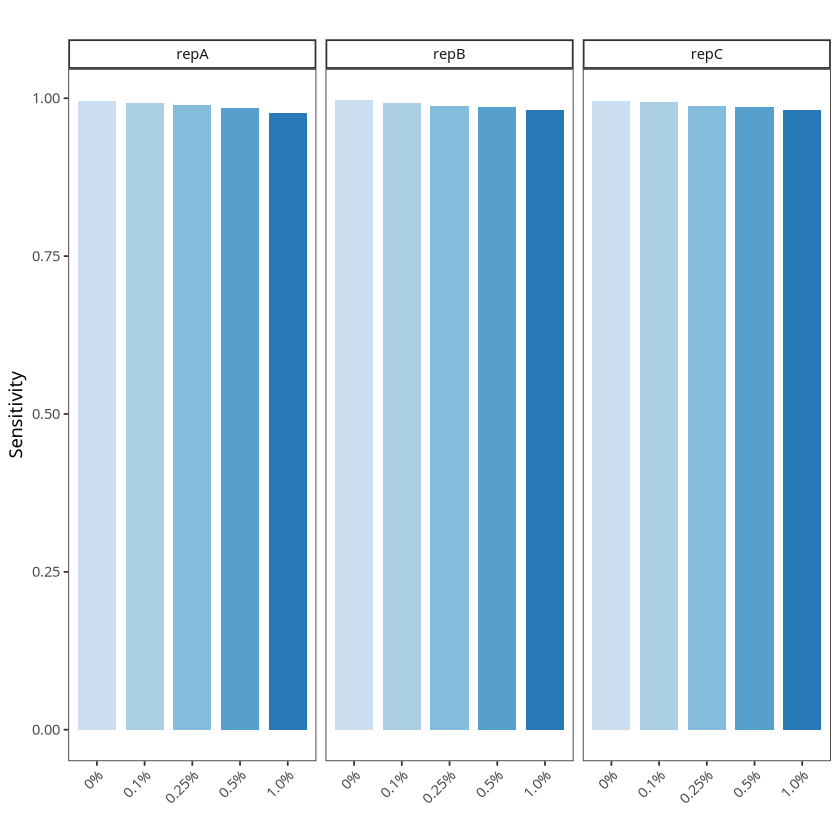

In [70]:
ggplot(all_metrics_umi, aes(x=error, y=sensitivity, fill=error)) +
    geom_bar(stat="identity", position= position_dodge(),width = 0.8) +
    scale_fill_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    labs(fill="Seq. error", x="", y="Sensitivity",title="") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position="none")+
    facet_grid(cols=vars(repertoire), drop=T)
ggsave(filename = paste0(results_dir,"/Sequence_sensitivity_mut_umi.pdf"), device="pdf", width = 18, height = 8, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_sensitivity_mut_umi.png"), device="png", width = 18, height = 8, units="cm")

Sensitivity plot over 

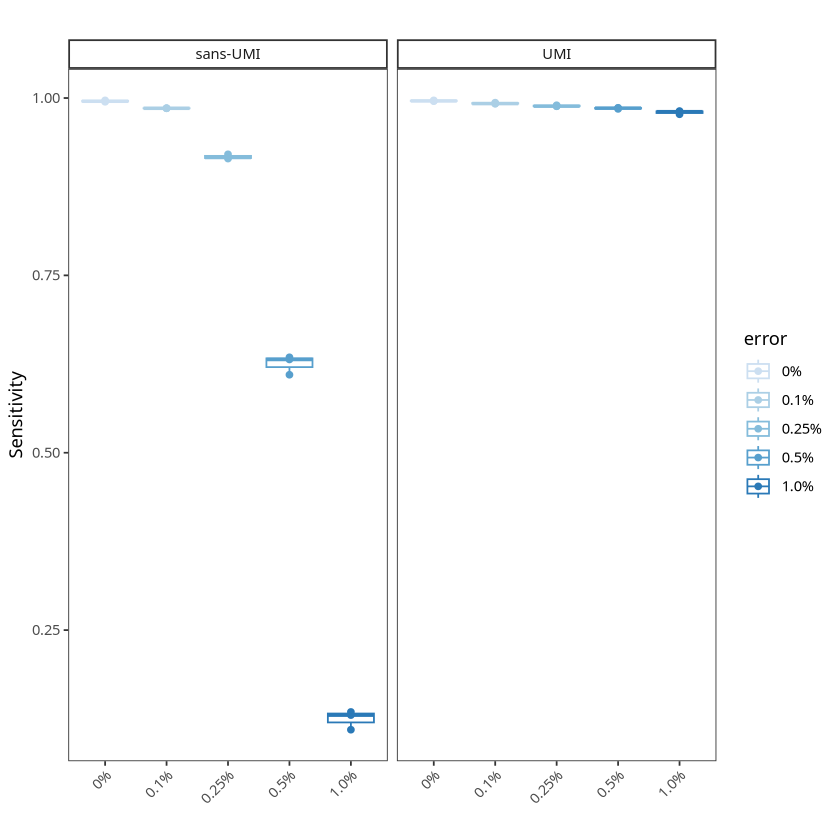

In [71]:
# sensitivity boxplot over all three repertoires
ggplot(all_metrics, aes(x=error, y=sensitivity, color=error)) +
  geom_boxplot(position=position_dodge(0.8)) +
  geom_jitter(position=position_dodge(0.8)) +
  scale_color_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    labs(fill="Seq. error", x="", y="Sensitivity",title="") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    facet_grid(cols=vars(protocol), drop=T , labeller = labeller(protocol = prot.labs))
ggsave(filename = paste0(results_dir,"/Sequence_sensitivity_mut_boxplot.pdf"), device="pdf", width = 12, height = 8, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_sensitivity_mut_boxplot.png"), device="png", width = 12, height = 8, units="cm")

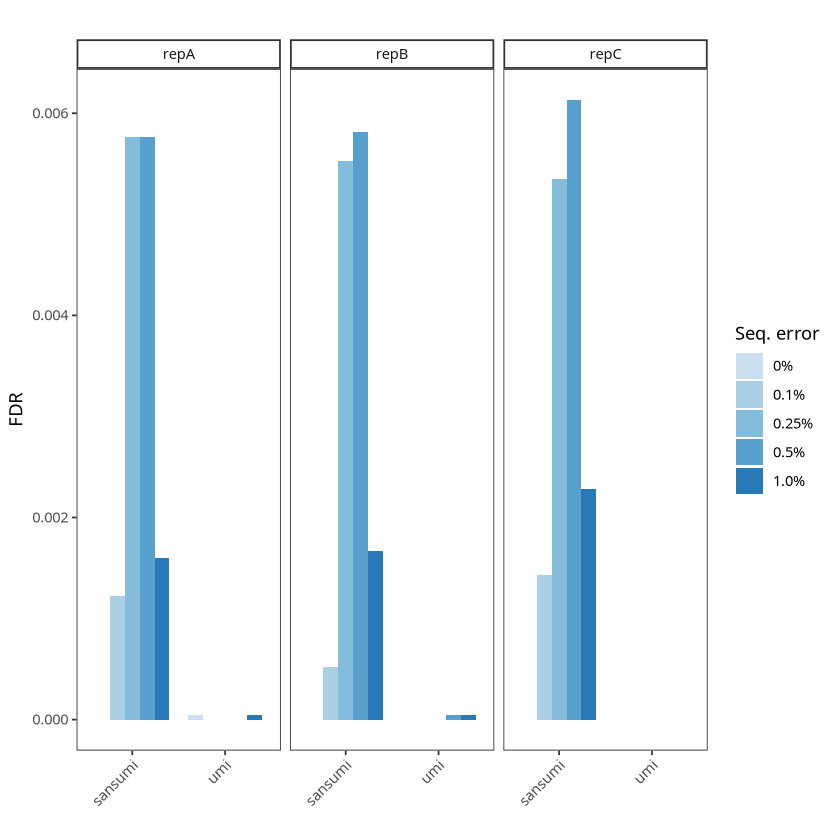

In [72]:
ggplot(all_metrics, aes(x=protocol, y=FDR, fill=error)) +
    geom_bar(stat="identity", position= position_dodge(),width = 0.8) +
    scale_fill_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    labs(fill="Seq. error", x="", y="FDR", title="") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    facet_grid(cols=vars(repertoire), drop=T)
ggsave(filename = paste0(results_dir,"/Sequence_FDR_mut.pdf"), device="pdf", width = 18, height = 8, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_FDR_mut.png"), device="png", width = 18, height = 8, units="cm")

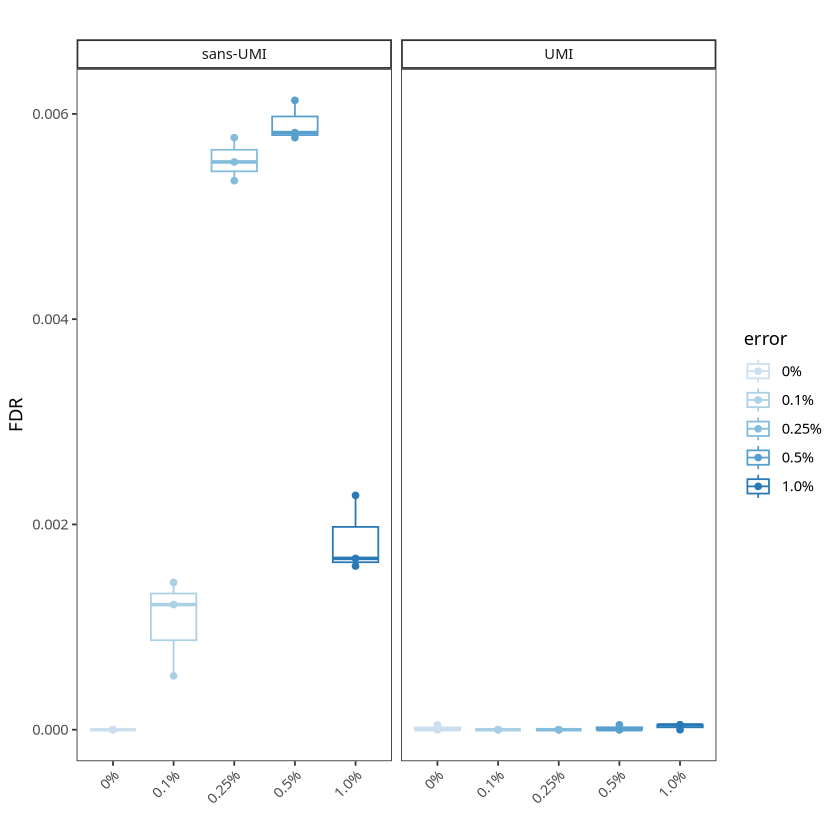

In [73]:
# FDR boxplot over all three repertoires
ggplot(all_metrics, aes(x=error, y=FDR, color=error)) +
    geom_boxplot(position=position_dodge(0.8)) +
    scale_color_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    geom_jitter(position=position_dodge(0.8)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(fill="Protocol", x="", y="FDR",title="") +
    facet_grid(cols=vars(protocol), drop=T, labeller = labeller(protocol = prot.labs))
ggsave(filename = paste0(results_dir,"/Sequence_FDR_mut_boxplot.pdf"), device="pdf", width = 12, height = 8, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_FDR_mut_boxplot.png"), device="png", width = 12, height = 8, units="cm")

In [74]:
hline_dat = data.frame(rep_id = c("repA","repB","repC"),
                        threshold = c(5100,5100,6305))

In [75]:
#ggsave(plot=div_p, filename = paste0(results_dir,"/Clonal_diversity_repertoires_mut.png"), device="png", width = 20, height = 15, units="cm")

# MiXCR comparison

### Read MiXCR sans umi clonal data

In [76]:
read_mixcr <- function(mixcr_clones_path, mixcr_trees_path, mixcr_rep_name){
    print(mixcr_rep_name)
    mixcr_clones <- read.table(mixcr_clones_path, sep="\t", header=T, quote = "", comment.char = "")
    mixcr_clones$repertoire <- mixcr_rep_name
    mixcr_clones$seq_id = as.numeric(str_remove(mixcr_clones$sequence_id,"clone."))
    mixcr_trees = read.table(mixcr_trees_path, sep="\t", header=T)
    mixcr_merged = dplyr::left_join(mixcr_clones, mixcr_trees[,c("treeId","cloneId")], by = join_by( seq_id == cloneId))
    if (any(!is.na(mixcr_merged$treeId))){
        max_treeid <- max(mixcr_merged$treeId[!is.na(mixcr_merged$treeId)])
        mixcr_merged$id_singletons <- seq(1:nrow(mixcr_merged)) + max_treeid
        mixcr_merged = mixcr_merged %>% dplyr::mutate(clone_id = dplyr::if_else(is.na(treeId), id_singletons, treeId))
    } else {
        mixcr_merged$clone_id <- seq(1:nrow(mixcr_merged))
    }
    return(mixcr_merged)
}

In [77]:
mixcr_clones_path_list <- list("mixcr/BCR/results/rep000_AIRR_clones.tsv",
                               "mixcr/BCR/results/rep001_AIRR_clones.tsv",
                               "mixcr/BCR/results/rep002_AIRR_clones.tsv",
                               "mixcr/BCR/results/rep003_AIRR_clones.tsv",
                               "mixcr/BCR/results/rep004_AIRR_clones.tsv",
                               "mixcr/BCR/results/rep005_AIRR_clones.tsv",
                               "mixcr/BCR/results/rep006_AIRR_clones.tsv",
                               "mixcr/BCR/results/rep007_AIRR_clones.tsv",
                               "mixcr/BCR/results/rep008_AIRR_clones.tsv",
                               "mixcr/BCR/results/rep009_AIRR_clones.tsv",
                               "mixcr/BCR/results/rep101_AIRR_clones.tsv",
                               "mixcr/BCR/results/rep102_AIRR_clones.tsv",
                               "mixcr/BCR/results/rep103_AIRR_clones.tsv",
                               "mixcr/BCR/results/rep104_AIRR_clones.tsv",
                               "mixcr/BCR/results/rep105_AIRR_clones.tsv")

In [78]:
mixcr_trees_path_list <- list("mixcr/BCR/results/rep000_trees.tsv",
                               "mixcr/BCR/results/rep001_trees.tsv",
                               "mixcr/BCR/results/rep002_trees.tsv",
                               "mixcr/BCR/results/rep003_trees.tsv",
                               "mixcr/BCR/results/rep004_trees.tsv",
                               "mixcr/BCR/results/rep005_trees.tsv",
                               "mixcr/BCR/results/rep006_trees.tsv",
                               "mixcr/BCR/results/rep007_trees.tsv",
                               "mixcr/BCR/results/rep008_trees.tsv",
                               "mixcr/BCR/results/rep009_trees.tsv",
                               "mixcr/BCR/results/rep101_trees.tsv",
                               "mixcr/BCR/results/rep102_trees.tsv",
                               "mixcr/BCR/results/rep103_trees.tsv",
                               "mixcr/BCR/results/rep104_trees.tsv",
                               "mixcr/BCR/results/rep105_trees.tsv")

In [79]:
mixcr_rep_names <- list("repA_00_mixcr", "repB_00_mixcr",
                         "repA_01_mixcr", "repA_025_mixcr", "repA_05_mixcr", "repA_10_mixcr",
                         "repB_01_mixcr", "repB_025_mixcr", "repB_05_mixcr", "repB_10_mixcr",
                         "repC_00_mixcr", "repC_01_mixcr", "repC_025_mixcr", "repC_05_mixcr", "repC_10_mixcr")

In [80]:
mixcr_rep_var_names <- list("repA_mixcr", "repB_mixcr",
                         "repA_mixcr_01", "repA_mixcr_025", "repA_mixcr_05", "repA_mixcr_10",
                         "repB_mixcr_01", "repB_mixcr_025", "repB_mixcr_05", "repB_mixcr_10",
                         "repC_mixcr", "repC_mixcr_01", "repC_mixcr_025", "repC_mixcr_05", "repC_mixcr_10")

In [81]:
mixcr_dfs <- mapply(read_mixcr, mixcr_clones_path_list, mixcr_trees_path_list, mixcr_rep_names, SIMPLIFY=FALSE)

[1] "repA_00_mixcr"
[1] "repB_00_mixcr"
[1] "repA_01_mixcr"
[1] "repA_025_mixcr"
[1] "repA_05_mixcr"
[1] "repA_10_mixcr"
[1] "repB_01_mixcr"
[1] "repB_025_mixcr"
[1] "repB_05_mixcr"
[1] "repB_10_mixcr"
[1] "repC_00_mixcr"
[1] "repC_01_mixcr"
[1] "repC_025_mixcr"
[1] "repC_05_mixcr"
[1] "repC_10_mixcr"


In [82]:
names(mixcr_dfs) <- mixcr_rep_var_names
list2env(mixcr_dfs, envir = .GlobalEnv)

<environment: R_GlobalEnv>

### Read MiXCR UMI dfs

In [83]:
mixcrumi_clones_path_list <- list("mixcr/BCR_umi/results/rep010_AIRR_clones.tsv",
                               "mixcr/BCR_umi/results/rep011_AIRR_clones.tsv",
                               "mixcr/BCR_umi/results/rep012_AIRR_clones.tsv",
                               "mixcr/BCR_umi/results/rep013_AIRR_clones.tsv",
                               "mixcr/BCR_umi/results/rep014_AIRR_clones.tsv",
                               "mixcr/BCR_umi/results/rep015_AIRR_clones.tsv",
                               "mixcr/BCR_umi/results/rep016_AIRR_clones.tsv",
                               "mixcr/BCR_umi/results/rep017_AIRR_clones.tsv",
                               "mixcr/BCR_umi/results/rep018_AIRR_clones.tsv",
                               "mixcr/BCR_umi/results/rep019_AIRR_clones.tsv",
                               "mixcr/BCR_umi/results/rep111_AIRR_clones.tsv",
                               "mixcr/BCR_umi/results/rep112_AIRR_clones.tsv",
                               "mixcr/BCR_umi/results/rep113_AIRR_clones.tsv",
                               "mixcr/BCR_umi/results/rep114_AIRR_clones.tsv",
                               "mixcr/BCR_umi/results/rep115_AIRR_clones.tsv")

In [84]:
mixcrumi_trees_path_list <- list("mixcr/BCR_umi/results/rep010_trees.tsv",
                               "mixcr/BCR_umi/results/rep011_trees.tsv",
                               "mixcr/BCR_umi/results/rep012_trees.tsv",
                               "mixcr/BCR_umi/results/rep013_trees.tsv",
                               "mixcr/BCR_umi/results/rep014_trees.tsv",
                               "mixcr/BCR_umi/results/rep015_trees.tsv",
                               "mixcr/BCR_umi/results/rep016_trees.tsv",
                               "mixcr/BCR_umi/results/rep017_trees.tsv",
                               "mixcr/BCR_umi/results/rep018_trees.tsv",
                               "mixcr/BCR_umi/results/rep019_trees.tsv",
                               "mixcr/BCR_umi/results/rep111_trees.tsv",
                               "mixcr/BCR_umi/results/rep112_trees.tsv",
                               "mixcr/BCR_umi/results/rep113_trees.tsv",
                               "mixcr/BCR_umi/results/rep114_trees.tsv",
                               "mixcr/BCR_umi/results/rep115_trees.tsv")

In [85]:
mixcrumi_rep_names <- list("repA_00_mixcrumi", "repB_00_mixcrumi",
                         "repA_01_mixcrumi", "repA_025_mixcrumi", "repA_05_mixcrumi", "repA_10_mixcrumi",
                         "repB_01_mixcrumi", "repB_025_mixcrumi", "repB_05_mixcrumi", "repB_10_mixcrumi",
                         "repC_00_mixcrumi", "repC_01_mixcrumi", "repC_025_mixcrumi", "repC_05_mixcrumi", "repC_10_mixcrumi")

In [86]:
mixcrumi_rep_var_names <- list("repA_mixcrumi", "repB_mixcrumi",
                         "repA_mixcrumi_01", "repA_mixcrumi_025", "repA_mixcrumi_05", "repA_mixcrumi_10",
                         "repB_mixcrumi_01", "repB_mixcrumi_025", "repB_mixcrumi_05", "repB_mixcrumi_10",
                         "repC_mixcrumi", "repC_mixcrumi_01", "repC_mixcrumi_025", "repC_mixcrumi_05", "repC_mixcrumi_10")

In [87]:
mixcrumi_dfs <- mapply(read_mixcr, mixcrumi_clones_path_list, mixcrumi_trees_path_list, mixcrumi_rep_names, SIMPLIFY=FALSE)

[1] "repA_00_mixcrumi"
[1] "repB_00_mixcrumi"
[1] "repA_01_mixcrumi"
[1] "repA_025_mixcrumi"
[1] "repA_05_mixcrumi"
[1] "repA_10_mixcrumi"
[1] "repB_01_mixcrumi"
[1] "repB_025_mixcrumi"
[1] "repB_05_mixcrumi"
[1] "repB_10_mixcrumi"
[1] "repC_00_mixcrumi"
[1] "repC_01_mixcrumi"
[1] "repC_025_mixcrumi"
[1] "repC_05_mixcrumi"
[1] "repC_10_mixcrumi"


In [88]:
names(mixcrumi_dfs) <- mixcrumi_rep_var_names
list2env(mixcrumi_dfs, envir = .GlobalEnv)

<environment: R_GlobalEnv>

### Generate one big dataframe from all individual repertoires

In [89]:
df_all <- data.table::rbindlist(list(repAmut_truth, 
                         repBmut_truth,
                         repCmut_truth,
                          repAmut_sans_umi_01, 
                             repAmut_sans_umi_025, 
                             repAmut_sans_umi_05,
                             repAmut_sans_umi_10,
                            repAmut_umi_01, 
                             repAmut_umi_025, 
                             repAmut_umi_05, 
                             repAmut_umi_10, 
                             repAmut_umi, 
                             repAmut_sans_umi, 
                            repBmut_umi_01, 
                             repBmut_umi_025, 
                             repBmut_umi_05, 
                             repBmut_umi_10, 
                             repBmut_sans_umi_01, 
                             repBmut_sans_umi_025, 
                             repBmut_sans_umi_05,
                             repBmut_sans_umi_10,
                             repBmut_umi, 
                             repBmut_sans_umi,
                             repCmut_umi_01, 
                             repCmut_umi_025, 
                             repCmut_umi_05, 
                             repCmut_umi_10, 
                             repCmut_sans_umi_01, 
                             repCmut_sans_umi_025, 
                             repCmut_sans_umi_05,
                             repCmut_sans_umi_10,
                             repCmut_umi, 
                             repCmut_sans_umi,
                         repA_mixcr, repB_mixcr,
                         repA_mixcr_01, repA_mixcr_025, repA_mixcr_05, repA_mixcr_10,
                         repB_mixcr_01, repB_mixcr_025, repB_mixcr_05, repB_mixcr_10,
                         repC_mixcr, repC_mixcr_01, repC_mixcr_025, repC_mixcr_05, repC_mixcr_10,
                         repA_mixcrumi, repB_mixcrumi,
                         repA_mixcrumi_01, repA_mixcrumi_025, repA_mixcrumi_05, repA_mixcrumi_10,
                         repB_mixcrumi_01, repB_mixcrumi_025, repB_mixcrumi_05, repB_mixcrumi_10,
                         repC_mixcrumi, repC_mixcrumi_01, repC_mixcrumi_025, repC_mixcrumi_05, repC_mixcrumi_10
                                    ), fill=TRUE)

## Metrics

In [90]:
# RepA metrics
seqs_truth <- repA_truth$sequence
all_truth_seqs <- length(unique(seqs_truth))
dfs <- list(repA_mixcr, repA_mixcr_01, repA_mixcr_025, repA_mixcr_05, repA_mixcr_10,
            repA_mixcrumi, repA_mixcrumi_01, repA_mixcrumi_025, repA_mixcrumi_05, repA_mixcrumi_10)
reps <- c("repA", "repA","repA","repA","repA","repA","repA","repA","repA", "repA")
prot <- c("mixcr", "mixcr", "mixcr", "mixcr", "mixcr",
          "mixcrumi", "mixcrumi", "mixcrumi", "mixcrumi", "mixcrumi")
muts <- c("0%","0.1%","0.25%","0.5%","1.0%","0%","0.1%","0.25%","0.5%","1.0%")
FNs <- c()
FPs <- c()
TPs <- c()
FDRs <- c()
sensitivities <- c()
missmatch_seq <- list()

for (df in dfs) {
 seqs_df <- str_sub(df$sequence, end=-2)
 FN <- length(setdiff(seqs_truth, seqs_df))
 FNs <- append(FNs,FN)
 FP <- length(setdiff(seqs_df, seqs_truth))
 FPs <- append(FPs,FP)
 TP <- length(intersect(seqs_truth,seqs_df))
 TPs <- append(TPs,TP)
 missmatch_seq <- append(missmatch_seq, list(setdiff(seqs_df,seqs_truth)))
 sensit <- TP / all_truth_seqs
 sensitivities <- append(sensitivities,sensit)
 FDR <- FP / all_truth_seqs
 FDRs <- append(FDRs, FDR)
}


repA_metrics_mixcr <- data.frame( repertoire = reps,
                           protocol = prot,
                           error = muts,
                           total_missing = FNs,
                           total_missmatch = FPs,
                           total_exactmatch = TPs,
                           total_uncertainmatch = 0,
                           sensitivity = sensitivities,
                           sensitivity_uncertain = sensitivities,
                           FDR = FDRs)
repA_metrics_mixcr

repertoire protocol error total_missing total_missmatch total_exactmatch
1  repA       mixcr    0%      512         1               20809           
2  repA       mixcr    0.1%    731         1               20590           
3  repA       mixcr    0.25% 10187         0               11134           
4  repA       mixcr    0.5%  20846         0                 475           
5  repA       mixcr    1.0%  21309         0                  12           
6  repA       mixcrumi 0%      257         1               21064           
7  repA       mixcrumi 0.1%    233         1               21088           
8  repA       mixcrumi 0.25%   222         1               21099           
9  repA       mixcrumi 0.5%    253         1               21068           
10 repA       mixcrumi 1.0%    297         1               21024           
   total_uncertainmatch sensitivity  sensitivity_uncertain FDR         
1  0                    0.9759861170 0.9759861170          4.690212e-05
2  0                    0.9657145537 0.9657145537          4.690212e-05
3  0                    0.5222081516 0.5222081516          0.000000e+00
4  0                    0.0222785048 0.0222785048          0.000000e+00
5  0                    0.0005628254 0.0005628254          0.000000e+00
6  0                    0.9879461564 0.9879461564          4.690212e-05
7  0                    0.9890718071 0.9890718071          4.690212e-05
8  0                    0.9895877304 0.9895877304          4.690212e-05
9  0                    0.9881337648 0.9881337648          4.690212e-05
10 0                    0.9860700718 0.9860700718          4.690212e-05

In [91]:
missmatch_seq

[[1]]
[1] "CTGCACCTGGTGCAGTCTGGGGCTAAGGTGGAGAAGCCCGGGGCCTCAGGGAAGATTGCCCGCACGGCATCTGGGCGCGGCTTCACCCGCTACTTTATGCTCTGGCTACGGCAGGCCCGTGGACTAGGGCTTGAGTGCGTGGGATTAGTCAACCCAAGTGGTGATAACACAAGGTACGCACAAGAGTTTCAAGACAGAGTCACCATGCCCAGGGACACGTCCACGAGAACAGTCTACATGGAGCTAACCAGCCTGAGACTTGAGGTCACGGCCGTTTATTACTGTGCGACAGACCCGATTATGTCTGGGGGAGTTTTGCTTATACCCCACCCCTTTGACTCCTGGGGCCAGGCAACCCTGATCACCGTTGGCTCA"

[[2]]
[1] "CTGCACCTGGTGCAGTCTGGGGCTAAGGTGGAGAAGCCCGGGGCCTCAGGGAAGATTGCCCGCACGGCATCTGGGCGCGGCTTCACCCGCTACTTTATGCTCTGGCTACGGCAGGCCCGTGGACTAGGGCTTGAGTGCGTGGGATTAGTCAACCCAAGTGGTGATAACACAAGGTACGCACAAGAGTTTCAAGACAGAGTCACCATGCCCAGGGACACGTCCACGAGAACAGTCTACATGGAGCTAACCAGCCTGAGACTTGAGGTCACGGCCGTTTATTACTGTGCGACAGACCCGATTATGTCTGGGGGAGTTTTGCTTATACCCCACCCCTTTGACTCCTGGGGCCAGGCAACCCTGATCACCGTTGGCTCA"

[[3]]
character(0)

[[4]]
character(0)

[[5]]
character(0)

[[6]]
[1] "CTGCACCTGGTGCAGTCTGGGGCTAAGGTGGAGAAGCCCGGGGCCTCAGGGAAGATTGCCCGCACGGCATCTGGGCGCGGCTTCACCCGCTACTTTATGCTCTGGCTACGGCAGGCCCGTGGACTAGGGCTTGAGTGCGTGGGATTAGTCAACCCAAGTGGTGATAACACAAGGTACGCACAAGAGTTTCAAGACAGAGTCACCATGCCCAGGGACACGTCCACGAGAACAGTCTACATGGAGCTAACCAGCCTGAGACTTGAGGTCACGGCCGTTTATTACTGTGCGACAGACCCGATTATGTCTGGGGGAGTTTTGCTTATACCCCACCCCTTTGACTCCTGGGGCCAGGCAACCCTGATCACCGTTGGCTCA"

[[7]]
[1] "CTGCACCTGGTGCAGTCTGGGGCTAAGGTGGAGAAGCCCGGGGCCTCAGGGAAGATTGCCCGCACGGCATCTGGGCGCGGCTTCACCCGCTACTTTATGCTCTGGCTACGGCAGGCCCGTGGACTAGGGCTTGAGTGCGTGGGATTAGTCAACCCAAGTGGTGATAACACAAGGTACGCACAAGAGTTTCAAGACAGAGTCACCATGCCCAGGGACACGTCCACGAGAACAGTCTACATGGAGCTAACCAGCCTGAGACTTGAGGTCACGGCCGTTTATTACTGTGCGACAGACCCGATTATGTCTGGGGGAGTTTTGCTTATACCCCACCCCTTTGACTCCTGGGGCCAGGCAACCCTGATCACCGTTGGCTCA"

[[8]]
[1] "CTGCACCTGGTGCAGTCTGGGGCTAAGGTGGAGAAGCCCGGGGCCTCAGGGAAGATTGCCCGCACGGCATCTGGGCGCGGCTTCACCCGCTACTTTATGCTCTGGCTACGGCAGGCCCGTGGACTAGGGCTTGAGTGCGTGGGATTAGTCAACCCAAGTGGTGATAACACAAGGTACGCACAAGAGTTTCAAGACAGAGTCACCATGCCCAGGGACACGTCCACGAGAACAGTCTACATGGAGCTAACCAGCCTGAGACTTGAGGTCACGGCCGTTTATTACTGTGCGACAGACCCGATTATGTCTGGGGGAGTTTTGCTTATACCCCACCCCTTTGACTCCTGGGGCCAGGCAACCCTGATCACCGTTGGCTCA"

[[9]]
[1] "CTGCACCTGGTGCAGTCTGGGGCTAAGGTGGAGAAGCCCGGGGCCTCAGGGAAGATTGCCCGCACGGCATCTGGGCGCGGCTTCACCCGCTACTTTATGCTCTGGCTACGGCAGGCCCGTGGACTAGGGCTTGAGTGCGTGGGATTAGTCAACCCAAGTGGTGATAACACAAGGTACGCACAAGAGTTTCAAGACAGAGTCACCATGCCCAGGGACACGTCCACGAGAACAGTCTACATGGAGCTAACCAGCCTGAGACTTGAGGTCACGGCCGTTTATTACTGTGCGACAGACCCGATTATGTCTGGGGGAGTTTTGCTTATACCCCACCCCTTTGACTCCTGGGGCCAGGCAACCCTGATCACCGTTGGCTCA"

[[10]]
[1] "CTGCACCTGGTGCAGTCTGGGGCTAAGGTGGAGAAGCCCGGGGCCTCAGGGAAGATTGCCCGCACGGCATCTGGGCGCGGCTTCACCCGCTACTTTATGCTCTGGCTACGGCAGGCCCGTGGACTAGGGCTTGAGTGCGTGGGATTAGTCAACCCAAGTGGTGATAACACAAGGTACGCACAAGAGTTTCAAGACAGAGTCACCATGCCCAGGGACACGTCCACGAGAACAGTCTACATGGAGCTAACCAGCCTGAGACTTGAGGTCACGGCCGTTTATTACTGTGCGACAGACCCGATTATGTCTGGGGGAGTTTTGCTTATACCCCACCCCTTTGACTCCTGGGGCCAGGCAACCCTGATCACCGTTGGCTCA"

In [92]:
missmatch_seq[[6]][1]

[1] "CTGCACCTGGTGCAGTCTGGGGCTAAGGTGGAGAAGCCCGGGGCCTCAGGGAAGATTGCCCGCACGGCATCTGGGCGCGGCTTCACCCGCTACTTTATGCTCTGGCTACGGCAGGCCCGTGGACTAGGGCTTGAGTGCGTGGGATTAGTCAACCCAAGTGGTGATAACACAAGGTACGCACAAGAGTTTCAAGACAGAGTCACCATGCCCAGGGACACGTCCACGAGAACAGTCTACATGGAGCTAACCAGCCTGAGACTTGAGGTCACGGCCGTTTATTACTGTGCGACAGACCCGATTATGTCTGGGGGAGTTTTGCTTATACCCCACCCCTTTGACTCCTGGGGCCAGGCAACCCTGATCACCGTTGGCTCA"

In [93]:
str_sub(missmatch_seq[[6]][1], end=-2)

[1] "CTGCACCTGGTGCAGTCTGGGGCTAAGGTGGAGAAGCCCGGGGCCTCAGGGAAGATTGCCCGCACGGCATCTGGGCGCGGCTTCACCCGCTACTTTATGCTCTGGCTACGGCAGGCCCGTGGACTAGGGCTTGAGTGCGTGGGATTAGTCAACCCAAGTGGTGATAACACAAGGTACGCACAAGAGTTTCAAGACAGAGTCACCATGCCCAGGGACACGTCCACGAGAACAGTCTACATGGAGCTAACCAGCCTGAGACTTGAGGTCACGGCCGTTTATTACTGTGCGACAGACCCGATTATGTCTGGGGGAGTTTTGCTTATACCCCACCCCTTTGACTCCTGGGGCCAGGCAACCCTGATCACCGTTGGCTC"

In [94]:
repA_mixcrumi %>% filter(grepl( str_sub(missmatch_seq[[6]][1], end=-2), sequence))

sequence_id
1 clone.49   
  sequence                                                                                                                                                                                                                                                                                                                                                                                
1 CTGCACCTGGTGCAGTCTGGGGCTAAGGTGGAGAAGCCCGGGGCCTCAGGGAAGATTGCCCGCACGGCATCTGGGCGCGGCTTCACCCGCTACTTTATGCTCTGGCTACGGCAGGCCCGTGGACTAGGGCTTGAGTGCGTGGGATTAGTCAACCCAAGTGGTGATAACACAAGGTACGCACAAGAGTTTCAAGACAGAGTCACCATGCCCAGGGACACGTCCACGAGAACAGTCTACATGGAGCTAACCAGCCTGAGACTTGAGGTCACGGCCGTTTATTACTGTGCGACAGACCCGATTATGTCTGGGGGAGTTTTGCTTATACCCCACCCCTTTGACTCCTGGGGCCAGGCAACCCTGATCACCGTTGGCTCAG
  rev_comp productive v_call                  d_call      j_call  
1 FALSE    TRUE       IGHV1-46*01,IGHV1-46*04 IGHD3-16*01 IGHJ4*02
  c_call                                         
1 IGHM*01,IGHM*03,IGHM*04,IGHM*05,IGHM*06,IGHM*07
  sequence_alignment                                                                                                                                                                                                                                                                                                                                                                         
1 C---TGCACCTGGTGCAGTCTGGGGCTAAGGTGGAGAAGCCCGGGGCCTCAGGGAAGATTGCCCGCACGGCATCTGGGCGCGGCTTCACCCGCTACTTTATGCTCTGGCTACGGCAGGCCCGTGGACTAGGGCTTGAGTGCGTGGGATTAGTCAACCCAAGTGGTGATAACACAAGGTACGCACAAGAGTTTCAAGACAGAGTCACCATGCCCAGGGACACGTCCACGAGAACAGTCTACATGGAGCTAACCAGCCTGAGACTTGAGGTCACGGCCGTTTATTACTGTGCGACAGACCCGATTATGTCTGGGGGAGTTTTGCTTATACCCCACCCCTTTGACTCCTGGGGCCAGGCAACCCTGATCACCGTTGGCTCAG
  germline_alignment                                                                                                                                                                                                                                                                                                                                                                         
1 CAGGTGCAGCTGGTGCAGTCTGGGGCTGAGGTGAAGAAGCCTGGGGCCTCAGTGAAGGTTTCCTGCAAGGCATCTGGATACACCTTCACCAGCTACTATATGCACTGGGTGCGACAGGCCCCTGGACAAGGGCTTGAGTGGATGGGAATAATCAACCCTAGTGGTGGTAGCACAAGCTACGCACAGAAGTTCCAGGGCAGAGTCACCATGACCAGGGACACGTCCACGAGCACAGTCTACATGGAGCTGAGCAGCCTGAGATCTGAGGACACGGCCGTGTATTACTGTGCGAGAGANNNGATTACGTTTGGGGGAGTTATGCTTATACCNNNNNNCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG
  ⋯ c_alignment_start c_alignment_end umi_count duplicate_count consensus_count
1 ⋯ NA                NA              1         5               5              
  repertoire       seq_id treeId id_singletons clone_id
1 repA_00_mixcrumi 49     NA     18355         18355

In [95]:
colnames(repA_mixcrumi)

[1] "sequence_id"        "sequence"           "rev_comp"          
 [4] "productive"         "v_call"             "d_call"            
 [7] "j_call"             "c_call"             "sequence_alignment"
[10] "germline_alignment" "complete_vdj"       "junction"          
[13] "junction_aa"        "np1"                "np2"               
[16] "cdr1"               "cdr1_aa"            "cdr2"              
[19] "cdr2_aa"            "cdr3"               "cdr3_aa"           
[22] "fwr1"               "fwr1_aa"            "fwr2"              
[25] "fwr2_aa"            "fwr3"               "fwr3_aa"           
[28] "fwr4"               "fwr4_aa"            "v_score"           
[31] "v_cigar"            "d_score"            "d_cigar"           
[34] "j_score"            "j_cigar"            "c_score"           
[37] "c_cigar"            "junction_length"    "np1_length"        
[40] "np2_length"         "v_germline_start"   "v_sequence_start"  
[43] "v_germline_end"     "v_sequence_end"     "d_germline_start"  
[46] "d_sequence_start"   "d_germline_end"     "d_sequence_end"    
[49] "j_germline_start"   "j_sequence_start"   "j_germline_end"    
[52] "j_sequence_end"     "c_germline_start"   "c_sequence_start"  
[55] "c_germline_end"     "c_sequence_end"     "v_alignment_start" 
[58] "v_alignment_end"    "d_alignment_start"  "d_alignment_end"   
[61] "j_alignment_start"  "j_alignment_end"    "c_alignment_start" 
[64] "c_alignment_end"    "umi_count"          "duplicate_count"   
[67] "consensus_count"    "repertoire"         "seq_id"            
[70] "treeId"             "id_singletons"      "clone_id"

In [96]:
repA_metrics <- bind_rows(repA_metrics, repA_metrics_mixcr)


In [97]:
repA_nseq <- length(unique(repA_truth$sequence))

In [98]:
repA_nseq

[1] 21321

In [99]:
# repB metrics
seqs_truth <- repB_truth$sequence
all_truth_seqs <- length(unique(seqs_truth))
dfs <- list(repB_mixcr, repB_mixcr_01, repB_mixcr_025, repB_mixcr_05, repB_mixcr_10,
            repB_mixcrumi, repB_mixcrumi_01, repB_mixcrumi_025, repB_mixcrumi_05, repB_mixcrumi_10
           )
reps <- c("repB", "repB","repB","repB","repB","repB","repB","repB","repB", "repB"
         )
prot <- c("mixcr", "mixcr", "mixcr", "mixcr", "mixcr",
           "mixcrumi", "mixcrumi", "mixcrumi", "mixcrumi", "mixcrumi"
         )
muts <- c("0%","0.1%","0.25%","0.5%","1.0%","0%","0.1%","0.25%","0.5%","1.0%"
         )
FNs <- c()
FPs <- c()
TPs <- c()
FDRs <- c()
missmatch_seq <- c()
sensitivities <- c()

for (df in dfs) {
 seqs_df <- str_sub(df$sequence, end=-2)
 FN <- length(setdiff(seqs_truth, seqs_df))
 FNs <- append(FNs,FN)
 FP <- length(setdiff(seqs_df, seqs_truth))
 FPs <- append(FPs,FP)
 TP <- length(intersect(seqs_truth,seqs_df))
 TPs <- append(TPs,TP)
 sensit <- TP / all_truth_seqs
 sensitivities <- append(sensitivities,sensit)
 FDR <- FP / all_truth_seqs
 FDRs <- append(FDRs, FDR)
}

repB_metrics_mixcr <- data.frame( repertoire = reps,
                           protocol = prot,
                           error = muts,
                           total_missing = FNs,
                           total_missmatch = FPs,
                           total_exactmatch = TPs,
                           total_uncertainmatch = 0,
                           sensitivity = sensitivities,
                           sensitivity_uncertain = sensitivities,
                           FDR = FDRs)
repB_metrics_mixcr

repertoire protocol error total_missing total_missmatch total_exactmatch
1  repB       mixcr    0%      545         4               20424           
2  repB       mixcr    0.1%    777         4               20192           
3  repB       mixcr    0.25%  9985         1               10984           
4  repB       mixcr    0.5%  20499         0                 470           
5  repB       mixcr    1.0%  20961         0                   8           
6  repB       mixcrumi 0%      229         0               20740           
7  repB       mixcrumi 0.1%    284         0               20685           
8  repB       mixcrumi 0.25%   275         2               20694           
9  repB       mixcrumi 0.5%    255         1               20714           
10 repB       mixcrumi 1.0%    256         1               20713           
   total_uncertainmatch sensitivity  sensitivity_uncertain FDR         
1  0                    0.9740092518 0.9740092518          1.907578e-04
2  0                    0.9629453002 0.9629453002          1.907578e-04
3  0                    0.5238208784 0.5238208784          4.768945e-05
4  0                    0.0224140398 0.0224140398          0.000000e+00
5  0                    0.0003815156 0.0003815156          0.000000e+00
6  0                    0.9890791168 0.9890791168          0.000000e+00
7  0                    0.9864561972 0.9864561972          0.000000e+00
8  0                    0.9868854023 0.9868854023          9.537889e-05
9  0                    0.9878391912 0.9878391912          4.768945e-05
10 0                    0.9877915017 0.9877915017          4.768945e-05

In [100]:
repB_metrics <- bind_rows(repB_metrics, repB_metrics_mixcr)

In [101]:
repB_nseq <- length(unique(repB_truth$sequence))
repB_nseq

[1] 20969

In [102]:
# repC metrics
seqs_truth <- repC_truth$sequence
all_truth_seqs <- length(unique(seqs_truth))
dfs <- list(repC_mixcr, repC_mixcr_01, repC_mixcr_025, repC_mixcr_05, repC_mixcr_10,
            repC_mixcrumi, repC_mixcrumi_01, repC_mixcrumi_025, repC_mixcrumi_05, repC_mixcrumi_10
           )
reps <- c("repC", "repC","repC","repC","repC","repC","repC","repC","repC", "repC"
         )
prot <- c("mixcr", "mixcr", "mixcr", "mixcr", "mixcr", 
          "mixcrumi", "mixcrumi", "mixcrumi", "mixcrumi", "mixcrumi"
          #"migec", "migec","migec","migec","migec"
         )
muts <- c("0%","0.1%","0.25%","0.5%","1.0%","0%","0.1%","0.25%","0.5%","1.0%"
         )
FNs <- c()
FPs <- c()
TPs <- c()
FDRs <- c()
sensitivities <- c()

for (df in dfs) {
 seqs_df <- str_sub(df$sequence, end=-2)
 FN <- length(setdiff(seqs_truth, seqs_df))
 FNs <- append(FNs,FN)
 FP <- length(setdiff(seqs_df, seqs_truth))
 FPs <- append(FPs,FP)
 TP <- length(intersect(seqs_truth,seqs_df))
 TPs <- append(TPs,TP)
 sensit <- TP / all_truth_seqs
 sensitivities <- append(sensitivities,sensit)
 FDR <- FP / all_truth_seqs
 FDRs <- append(FDRs, FDR)
}

repC_metrics_mixcr <- data.frame( repertoire = reps,
                           protocol = prot,
                           error = muts,
                           total_missing = FNs,
                           total_missmatch = FPs,
                           total_exactmatch = TPs,
                           total_uncertainmatch = 0,
                           sensitivity = sensitivities,
                           sensitivity_uncertain = sensitivities,
                           FDR = FDRs)
repC_metrics_mixcr

repertoire protocol error total_missing total_missmatch total_exactmatch
1  repC       mixcr    0%      334         1               14995           
2  repC       mixcr    0.1%    530         1               14799           
3  repC       mixcr    0.25%  7294         0                8035           
4  repC       mixcr    0.5%  14956         0                 373           
5  repC       mixcr    1.0%  15323         0                   6           
6  repC       mixcrumi 0%      180         0               15149           
7  repC       mixcrumi 0.1%    156         0               15173           
8  repC       mixcrumi 0.25%   196         0               15133           
9  repC       mixcrumi 0.5%    189         0               15140           
10 repC       mixcrumi 1.0%    183         0               15146           
   total_uncertainmatch sensitivity sensitivity_uncertain FDR         
1  0                    0.978211234 0.978211234           6.523583e-05
2  0                    0.965425011 0.965425011           6.523583e-05
3  0                    0.524169874 0.524169874           0.000000e+00
4  0                    0.024332964 0.024332964           0.000000e+00
5  0                    0.000391415 0.000391415           0.000000e+00
6  0                    0.988257551 0.988257551           0.000000e+00
7  0                    0.989823211 0.989823211           0.000000e+00
8  0                    0.987213778 0.987213778           0.000000e+00
9  0                    0.987670429 0.987670429           0.000000e+00
10 0                    0.988061844 0.988061844           0.000000e+00

In [103]:
repC_metrics <- bind_rows(repC_metrics, repC_metrics_mixcr)

In [104]:
repC_nseq <- length(unique(repC_truth$sequence))
repC_nseq

[1] 15329

In [105]:
all_metrics <- rbind(repA_metrics, repB_metrics, repC_metrics)

In [106]:
head(all_metrics,20)

repertoire protocol error sensitivity  FDR          total_missing
1  repA       sansumi  0%    0.9954504948 0.000000e+00    97        
2  repA       sansumi  0.1%  0.9854603443 1.219455e-03   310        
3  repA       sansumi  0.25% 0.9145912481 5.768960e-03  1812        
4  repA       sansumi  0.5%  0.6099151072 5.768960e-03  8274        
5  repA       sansumi  1.0%  0.1095633413 1.594672e-03 18969        
6  repA       umi      0%    0.9955912012 4.690212e-05    93        
7  repA       umi      0.1%  0.9921673467 0.000000e+00   109        
8  repA       umi      0.25% 0.9898222410 0.000000e+00   149        
9  repA       umi      0.5%  0.9846161062 0.000000e+00   195        
10 repA       umi      1.0%  0.9770648656 4.690212e-05   296        
11 repA       mixcr    0%    0.9759861170 4.690212e-05   512        
12 repA       mixcr    0.1%  0.9657145537 4.690212e-05   731        
13 repA       mixcr    0.25% 0.5222081516 0.000000e+00 10187        
14 repA       mixcr    0.5%  0.0222785048 0.000000e+00 20846        
15 repA       mixcr    1.0%  0.0005628254 0.000000e+00 21309        
16 repA       mixcrumi 0%    0.9879461564 4.690212e-05   257        
17 repA       mixcrumi 0.1%  0.9890718071 4.690212e-05   233        
18 repA       mixcrumi 0.25% 0.9895877304 4.690212e-05   222        
19 repA       mixcrumi 0.5%  0.9881337648 4.690212e-05   253        
20 repA       mixcrumi 1.0%  0.9860700718 4.690212e-05   297        
   total_exactmatch total_missmatch total_uncertainmatch sensitivity_uncertain
1  21224              0               0                  0.9954504948         
2  21011             26               0                  0.9854603443         
3  19500            123               0                  0.9145912481         
4  13004            123               0                  0.6099151072         
5   2336             34               0                  0.1095633413         
6  21227              1               0                  0.9955912012         
7  21154              0              58                  0.9948876694         
8  21104              0              68                  0.9930115848         
9  20993              0             133                  0.9908540875         
10 20832              1             192                  0.9860700718         
11 20809              1               0                  0.9759861170         
12 20590              1               0                  0.9657145537         
13 11134              0               0                  0.5222081516         
14   475              0               0                  0.0222785048         
15    12              0               0                  0.0005628254         
16 21064              1               0                  0.9879461564         
17 21088              1               0                  0.9890718071         
18 21099              1               0                  0.9895877304         
19 21068              1               0                  0.9881337648         
20 21024              1               0                  0.9860700718

In [107]:
write.table(all_metrics,paste0(results_dir,"/sequence_sensitivity_fdr_toolcomparison.tsv"),sep="\t",row.names=F, col.names = T, quote=F)

### UMI protocol

#### Exact matches

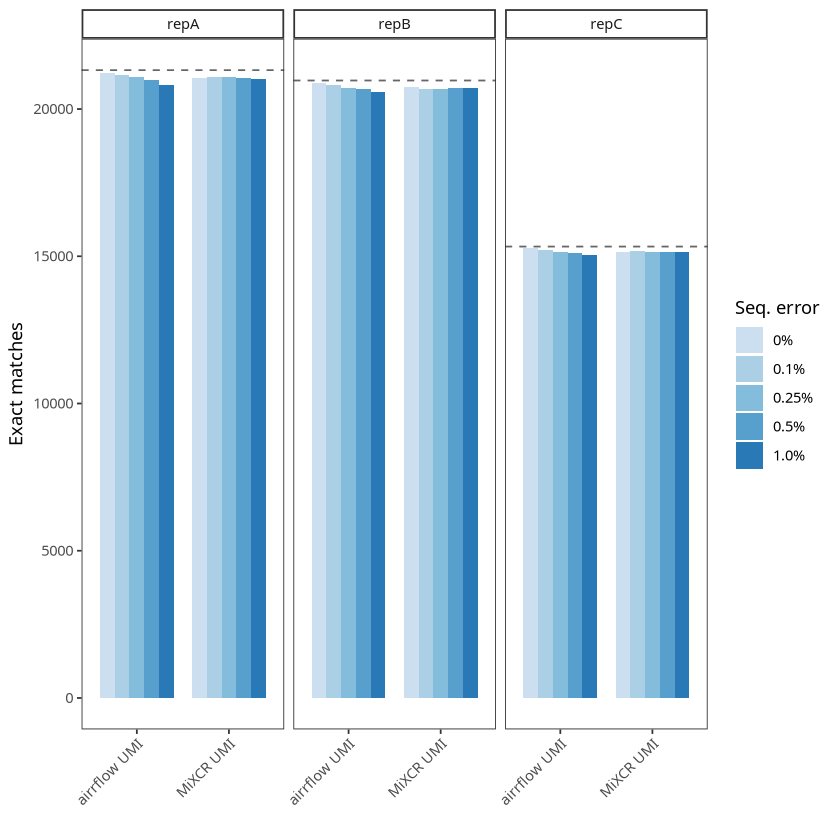

In [108]:
samp.labs <- c("airrflow sans-UMI", "airrflow UMI", "MiXCR sans-UMI", "MiXCR UMI")
names(samp.labs) <- c("sansumi", "umi", "mixcr", "mixcrumi")

hline_dat = data.frame(repertoire = c("repA","repB","repC"),
                        threshold = c(repA_nseq,repB_nseq,repC_nseq))
all_metrics$error <- factor(all_metrics$error, levels = c("0%","0.1%","0.25%","0.5%","1.0%"))
all_metrics$protocol <- factor(all_metrics$protocol, levels = c("umi","sansumi", "mixcr","mixcrumi"))

all_metrics %>% 
    dplyr::filter(protocol %in% c("umi", "mixcrumi")) %>%
    ggplot(aes(x=protocol, y=total_exactmatch, fill=error)) +
    geom_bar(stat="identity", position= position_dodge(),width = 0.8) +
    geom_hline(data=hline_dat, aes(yintercept = threshold), color="grey40", linetype="dashed", linewidth = 0.5) +
    scale_fill_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    labs(fill="Seq. error", x="", y="Exact matches") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_x_discrete(labels=c("umi" = "airrflow UMI", "mixcrumi" = "MiXCR UMI")) +
    facet_grid(cols=vars(repertoire), drop=T, labeller = labeller(protocol=samp.labs))
ggsave(filename = paste0(results_dir,"/Sequence_TP_mut_UMI_allreps_toolcomparison.pdf"), device="pdf", width = 12, height = 6, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_TP_mut_UMI_allreps_toolcomparison.png"), device="png", width = 12, height = 6, units="cm")

#### Exact and uncertain matches

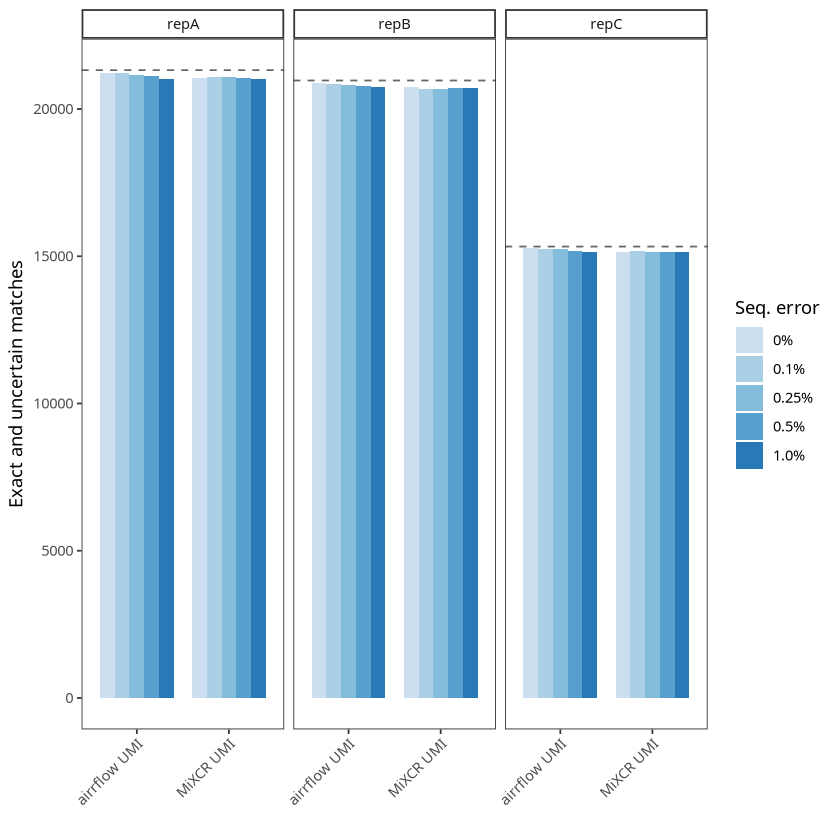

In [109]:
hline_dat = data.frame(repertoire = c("repA","repB","repC"),
                        threshold = c(repA_nseq,repB_nseq,repC_nseq))
all_metrics$error <- factor(all_metrics$error, levels = c("0%","0.1%","0.25%","0.5%","1.0%"))
all_metrics$protocol <- factor(all_metrics$protocol, levels = c("umi","sansumi", "mixcr","mixcrumi"))

all_metrics %>% 
    mutate(total_exactplusuncertain = total_uncertainmatch + total_exactmatch) %>%
    dplyr::filter(protocol %in% c("umi", "mixcrumi")) %>%
    ggplot(aes(x=protocol, y=total_exactplusuncertain, fill=error)) +
    geom_bar(stat="identity", position= position_dodge(),width = 0.8) +
    geom_hline(data=hline_dat, aes(yintercept = threshold), color="grey40", linetype="dashed", linewidth = 0.5) +
    scale_fill_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    labs(fill="Seq. error", x="", y="Exact and uncertain matches") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_x_discrete(labels=c("umi" = "airrflow UMI", "mixcrumi" = "MiXCR UMI")) +
    facet_grid(cols=vars(repertoire), drop=T, labeller = labeller(protocol=samp.labs))
ggsave(filename = paste0(results_dir,"/Sequence_TP_uncertain_mut_UMI_allreps_toolcomparison.pdf"), device="pdf", width = 12, height = 6, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_TP_uncertain_mut_UMI_allreps_toolcomparison.png"), device="png", width = 12, height = 6, units="cm")

#### Missing sequences

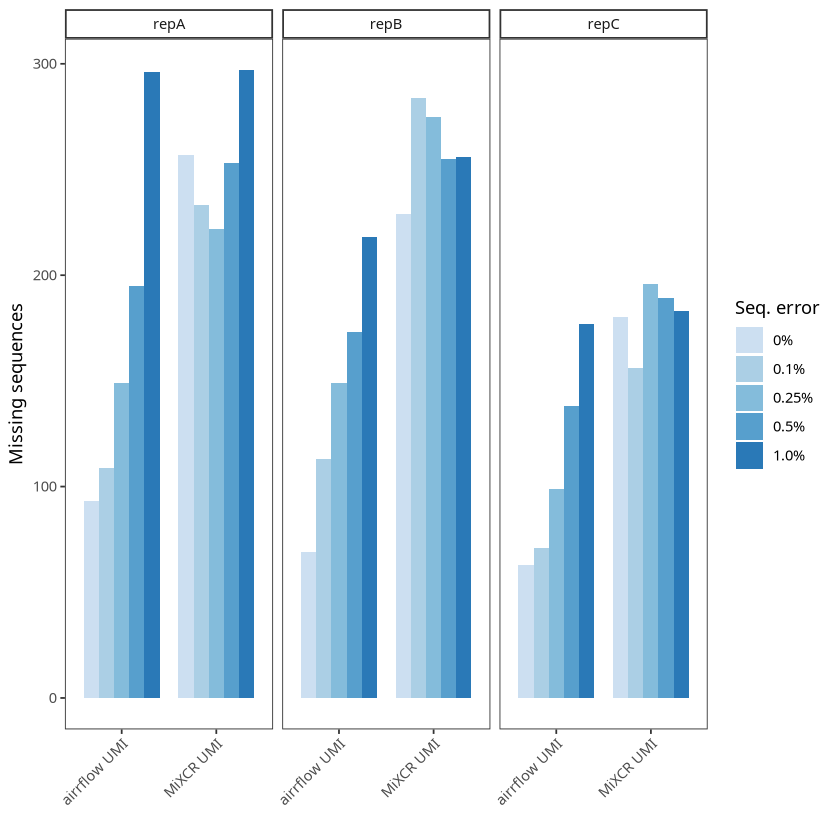

In [110]:
hline_dat = data.frame(repertoire = c("repA","repB","repC"),
                        threshold = c(repA_nseq,repB_nseq,repC_nseq))
all_metrics$error <- factor(all_metrics$error, levels = c("0%","0.1%","0.25%","0.5%","1.0%"))
all_metrics$protocol <- factor(all_metrics$protocol, levels = c("umi","sansumi", "mixcr","mixcrumi"))

all_metrics %>% 
    dplyr::filter(protocol %in% c("umi", "mixcrumi")) %>%
    ggplot(aes(x=protocol, y=total_missing, fill=error)) +
    geom_bar(stat="identity", position= position_dodge(),width = 0.8) +
    scale_fill_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    labs(fill="Seq. error", x="", y="Missing sequences") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_x_discrete(labels=c("umi" = "airrflow UMI", "mixcrumi" = "MiXCR UMI")) +
    facet_grid(cols=vars(repertoire), drop=T, labeller = labeller(protocol=samp.labs))
ggsave(filename = paste0(results_dir,"/Sequence_FN_mut_UMI_allreps_toolcomparison.pdf"), device="pdf", width = 12, height = 6, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_FN_mut_UMI_allreps_toolcomparison.png"), device="png", width = 12, height = 6, units="cm")

#### Incorrect sequences

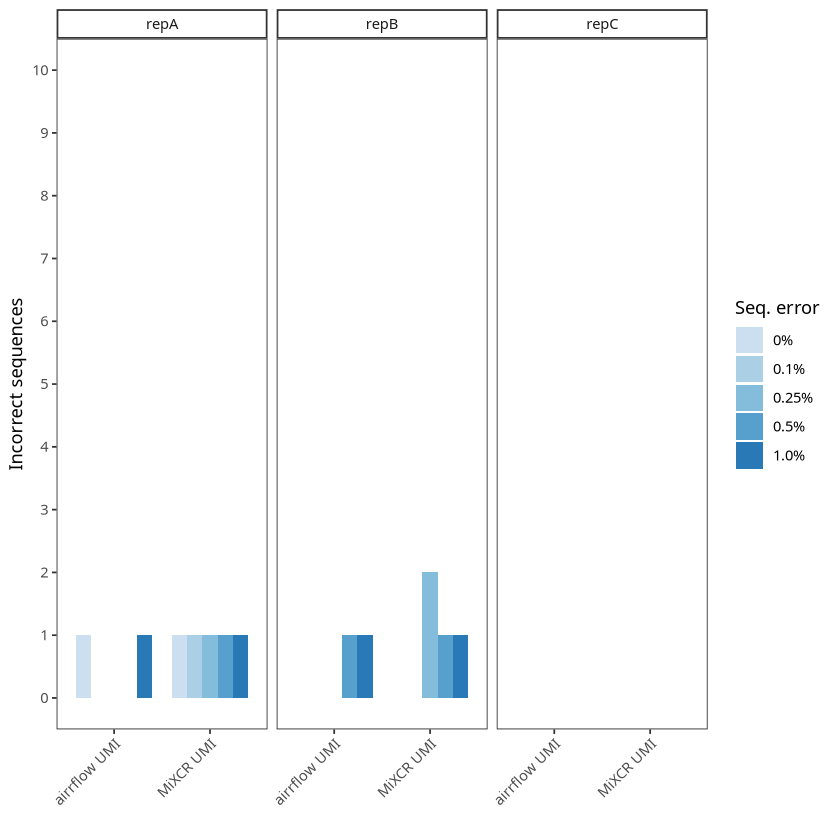

In [111]:
hline_dat = data.frame(repertoire = c("repA","repB","repC"),
                        threshold = c(repA_nseq,repB_nseq,repC_nseq))
all_metrics$error <- factor(all_metrics$error, levels = c("0%","0.1%","0.25%","0.5%","1.0%"))
all_metrics$protocol <- factor(all_metrics$protocol, levels = c("umi","sansumi", "mixcr","mixcrumi"))

all_metrics %>% 
    dplyr::filter(protocol %in% c("umi", "mixcrumi")) %>%
    ggplot(aes(x=protocol, y=total_missmatch, fill=error)) +
    geom_bar(stat="identity", position= position_dodge(),width = 0.8) +
    scale_fill_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    labs(fill="Seq. error", x="", y="Incorrect sequences") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_x_discrete(labels=c("umi" = "airrflow UMI", "mixcrumi" = "MiXCR UMI")) +
    scale_y_continuous(limits=c(0, 10), breaks = c(0:10)) +
    facet_grid(cols=vars(repertoire), drop=T, labeller = labeller(protocol=samp.labs))
ggsave(filename = paste0(results_dir,"/Sequence_missmatches_mut_UMI_allreps_toolcomparison.pdf"), device="pdf", width = 12, height = 6, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_missmatches_mut_UMI_allreps_toolcomparison.png"), device="png", width = 12, height = 6, units="cm")

### Sans-UMI protocol

#### Exact matches

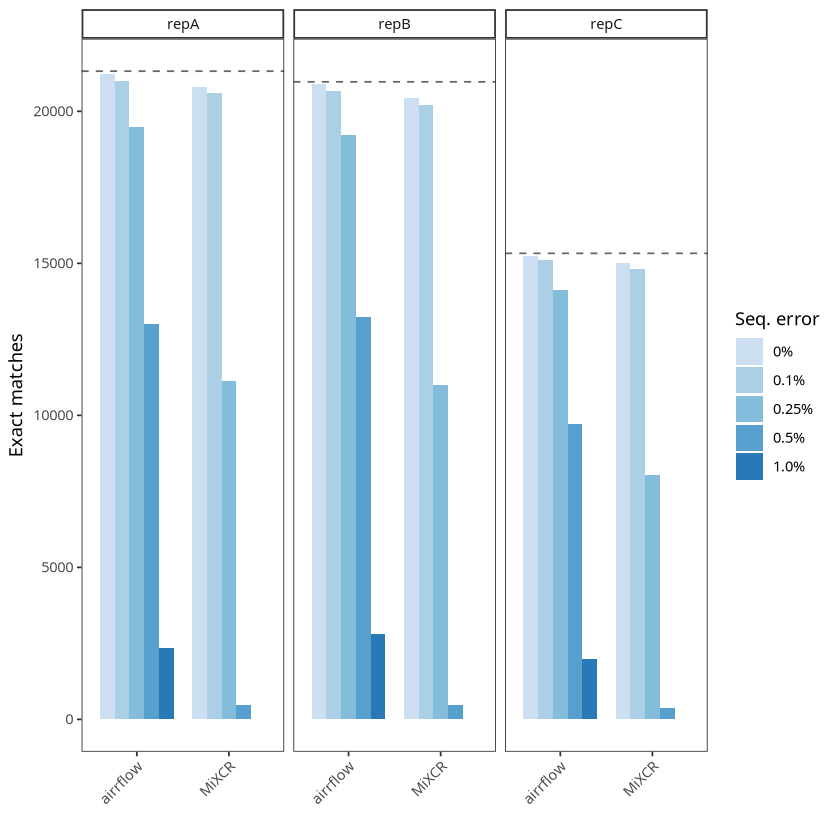

In [112]:
hline_dat = data.frame(repertoire = c("repA","repB","repC"),
                        threshold = c(repA_nseq,repB_nseq,repC_nseq))

all_metrics %>% 
    dplyr::filter(protocol %in% c("sansumi", "mixcr")) %>%
    ggplot(aes(x=protocol, y=total_exactmatch, fill=error)) +
    geom_bar(stat="identity", position= position_dodge(),width = 0.8) +
    #geom_hline(yintercept = repC_nseq, color="grey40", linetype="dashed", linewidth = 0.5) +
    geom_hline(data=hline_dat, aes(yintercept = threshold), color="grey40", linetype="dashed", linewidth = 0.5) +
    scale_fill_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    #scale_y_log10(limits = NULL,
    #            breaks = scales::trans_breaks("log10", function(x) 10^x),
    #            labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    #scale_fill_manual(limits = c("TP", "FP"),
    #            labels = c("True Sequences", "Missmatches"),
    #            values = c("#5ab4ac","#d8b365"))+
    #ggtitle("RepC") +
    labs(fill="Seq. error", x="", y="Exact matches") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_x_discrete(labels=c("sansumi" = "airrflow", "mixcr" = "MiXCR")) +
    facet_grid(cols=vars(repertoire), drop=T, labeller = labeller(protocol=samp.labs))
ggsave(filename = paste0(results_dir,"/Sequence_TP_mut_sansUMI_allreps_toolcomparison.pdf"), device="pdf", width = 12, height = 6, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_TP_mut_sansUMI_allreps_toolcomparison.png"), device="png", width = 12, height = 6, units="cm")

#### Missing sequences

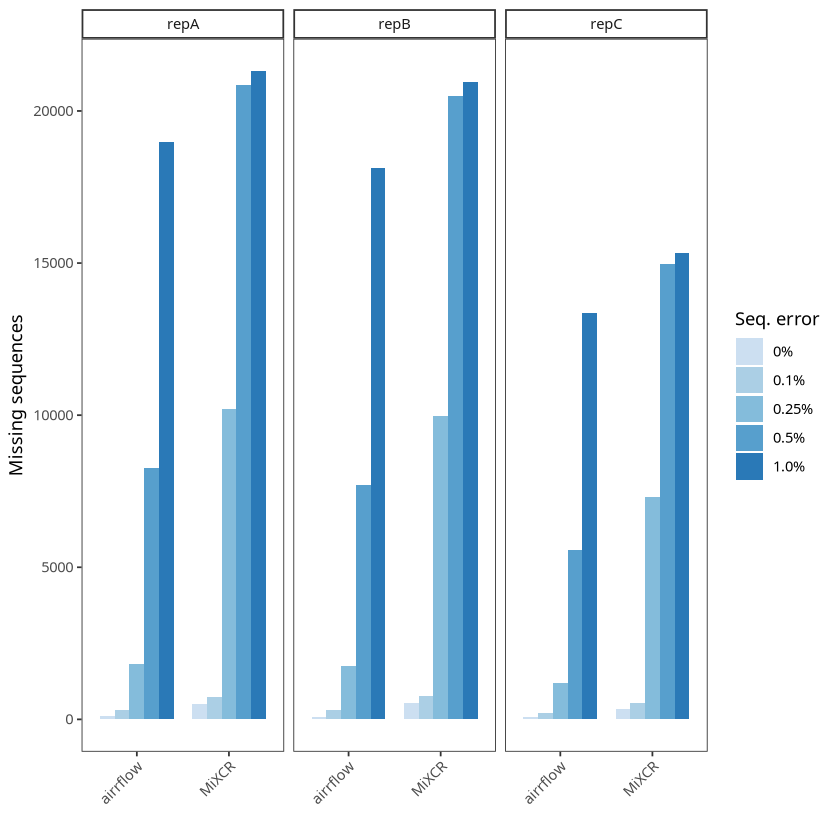

In [113]:
hline_dat = data.frame(repertoire = c("repA","repB","repC"),
                        threshold = c(repA_nseq,repB_nseq,repC_nseq))

all_metrics %>% 
    dplyr::filter(protocol %in% c("sansumi", "mixcr")) %>%
    ggplot(aes(x=protocol, y=total_missing, fill=error)) +
    geom_bar(stat="identity", position= position_dodge(),width = 0.8) +
    scale_fill_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    labs(fill="Seq. error", x="", y="Missing sequences") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_x_discrete(labels=c("sansumi" = "airrflow", "mixcr" = "MiXCR")) +
    facet_grid(cols=vars(repertoire), drop=T, labeller = labeller(protocol=samp.labs))
ggsave(filename = paste0(results_dir,"/Sequence_FN_mut_sansUMI_allreps_toolcomparison.pdf"), device="pdf", width = 12, height = 6, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_FN_mut_sansUMI_allreps_toolcomparison.png"), device="png", width = 12, height = 6, units="cm")

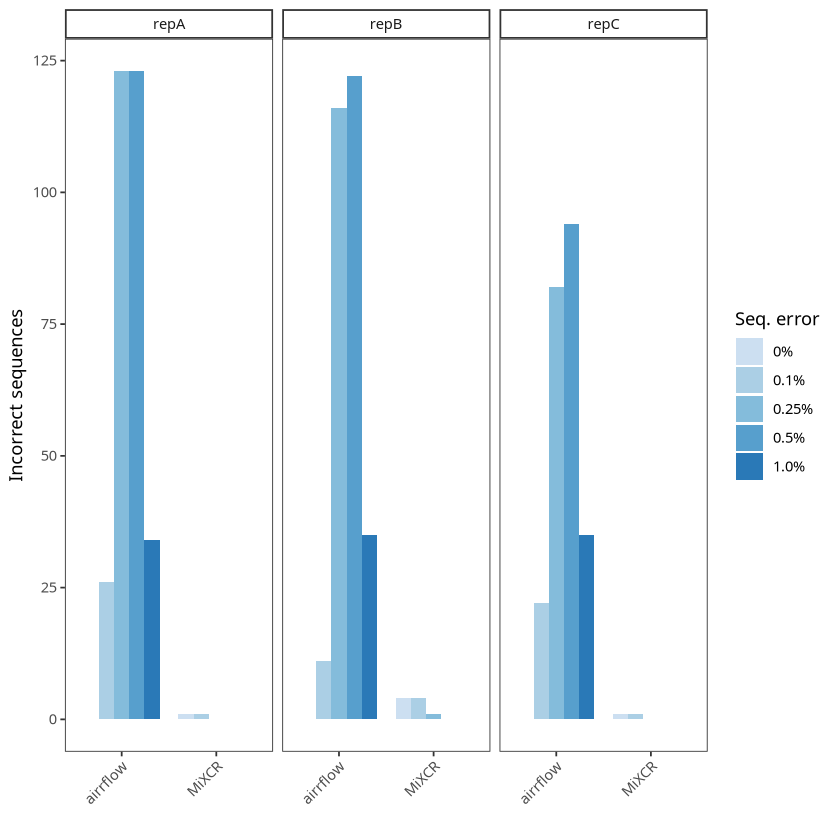

In [114]:
all_metrics %>% 
    dplyr::filter(protocol %in% c("sansumi", "mixcr")) %>%
    ggplot(aes(x=protocol, y=total_missmatch, fill=error)) +
    geom_bar(stat="identity", position= position_dodge(),width = 0.8) +
    scale_fill_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    labs(fill="Seq. error", x="", y="Incorrect sequences") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_x_discrete(labels=c("sansumi" = "airrflow", "mixcr" = "MiXCR")) +
    facet_grid(cols=vars(repertoire), drop=T, labeller = labeller(protocol=samp.labs))
ggsave(filename = paste0(results_dir,"/Sequence_FP_mut_sansUMI_allreps_toolcomparison.pdf"), device="pdf", width = 12, height = 6, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_FP_mut_sansUMI_allreps_toolcomparison.png"), device="png", width = 12, height = 6, units="cm")

### Sensitivity

In [115]:
sensitivity_wide <- all_metrics %>% dplyr::select(repertoire,protocol,error,sensitivity) %>%
                                tidyr::pivot_wider(id_cols= c(protocol,error), names_from=repertoire, values_from = sensitivity ) %>%
                                dplyr::rowwise() %>% dplyr::mutate(sensitivity_mean = mean(c(repA, repB, repC)), sensitivity_sd=sd(c(repA,repB,repC))) %>%
                                dplyr::select(protocol, error, sensitivity_mean, sensitivity_sd)
                                

In [116]:
write.table(sensitivity_wide,paste0(results_dir,"/sequence_sensitivity_mean_toolcomparison.tsv"),sep="\t", row.names=F, col.names=T, quote=F)

In [117]:
sensitivity_uncertain_wide <- all_metrics %>% dplyr::select(repertoire,protocol,error,sensitivity_uncertain) %>%
                                tidyr::pivot_wider(id_cols= c(protocol,error), names_from=repertoire, values_from = sensitivity_uncertain ) %>%
                                dplyr::rowwise() %>% dplyr::mutate(sensitivity_uncertain_mean = mean(c(repA, repB, repC)), sensitivity_uncertain_sd=sd(c(repA,repB,repC))) %>%
                                dplyr::select(protocol, error, sensitivity_uncertain_mean, sensitivity_uncertain_sd)

In [118]:
write.table(sensitivity_uncertain_wide,paste0(results_dir,"/sequence_sensitivity_uncertain_mean_toolcomparison.tsv"),sep="\t", row.names=F, col.names=T, quote=F)

In [119]:
colnames(all_metrics)

[1] "repertoire"            "protocol"              "error"                
 [4] "sensitivity"           "FDR"                   "total_missing"        
 [7] "total_exactmatch"      "total_missmatch"       "total_uncertainmatch" 
[10] "sensitivity_uncertain"

In [120]:
fdr_wide <- all_metrics %>% dplyr::select(repertoire,protocol,error,FDR) %>%
                                tidyr::pivot_wider(id_cols= c(protocol,error), names_from=repertoire, values_from = FDR ) %>%
                                dplyr::rowwise() %>% dplyr::mutate(FDR_mean = mean(c(repA, repB, repC)), FDR_sd=sd(c(repA,repB,repC))) %>%
                                dplyr::select(protocol, error, FDR_mean, FDR_sd)

In [121]:
write.table(fdr_wide,paste0(results_dir,"/sequence_fdr_mean_toolcomparison.tsv"),sep="\t", row.names=F, col.names=T, quote=F)

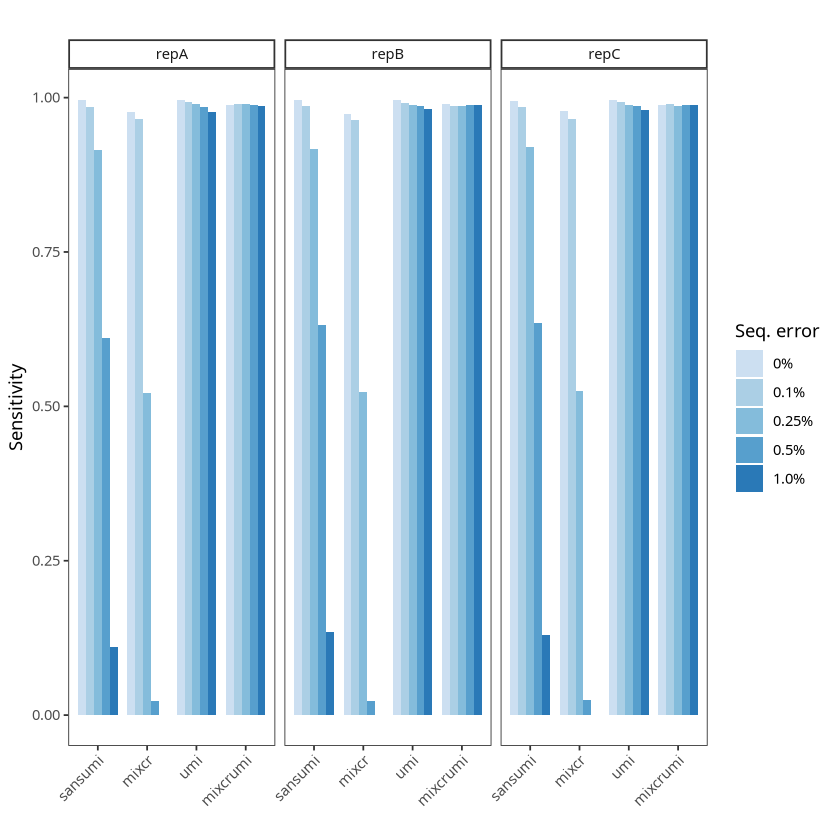

In [122]:
all_metrics$error <- factor(all_metrics$error, levels = c("0%","0.1%","0.25%","0.5%","1.0%"))
all_metrics$protocol <- factor(all_metrics$protocol, levels = c("sansumi","mixcr","umi","mixcrumi"))
ggplot(all_metrics, aes(x=protocol, y=sensitivity, fill=error)) +
    geom_bar(stat="identity", position= position_dodge(),width = 0.8) +
    scale_fill_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    labs(fill="Seq. error", x="", y="Sensitivity",title="") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    facet_grid(cols=vars(repertoire), drop=T)
ggsave(filename = paste0(results_dir,"/Sequence_sensitivity_mut_toolcomparison.pdf"), device="pdf", width = 20, height = 8, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_sensitivity_mut_toolcomparison.png"), device="png", width = 20, height = 8, units="cm")

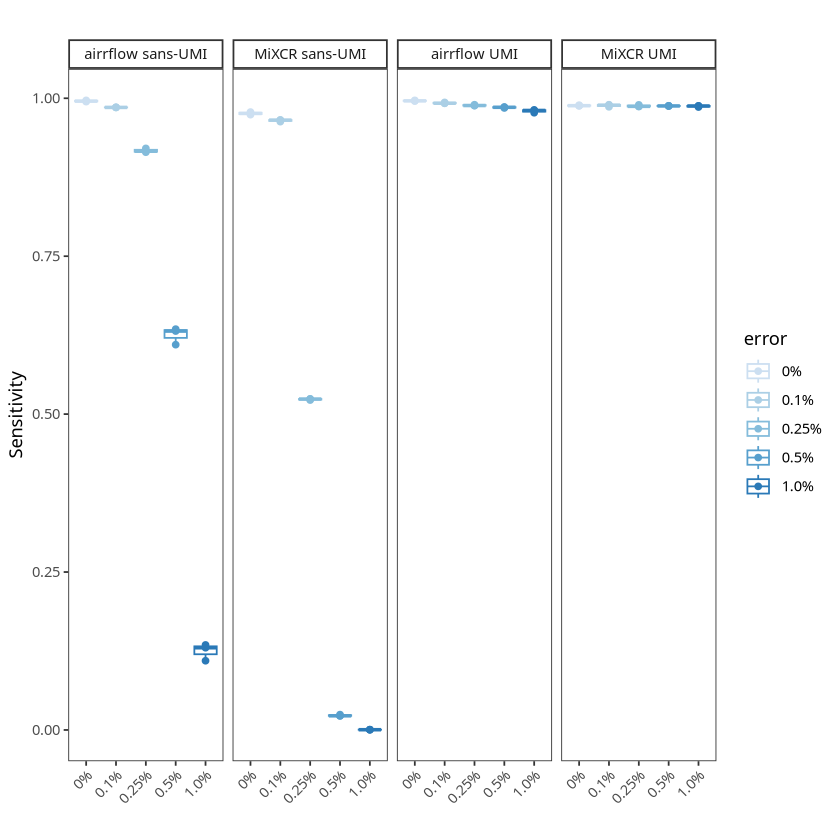

In [123]:
# sensitivity boxplot over all three repertoires
ggplot(all_metrics, aes(x=error, y=sensitivity, color=error)) +
  geom_boxplot(position=position_dodge(0.8)) +
  scale_color_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    labs(fill="Seq. error", x="", y="Sensitivity",title="") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  geom_jitter(position=position_dodge(0.8)) +
  scale_fill_brewer(palette="PRGn") +
    labs(fill="Seq. error", x="", y="Sensitivity",title="") +
    facet_grid(cols=vars(protocol), drop=T, labeller = labeller(protocol=samp.labs))
ggsave(filename = paste0(results_dir,"/Sequence_sensitivity_mut_toolcomparison_boxplot.pdf"), device="pdf", width = 12, height = 6, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_sensitivity_mut_toolcomparison_boxplot.png"), device="png", width = 12, height = 6, units="cm")

#### Sensitivity UMI for exact matches

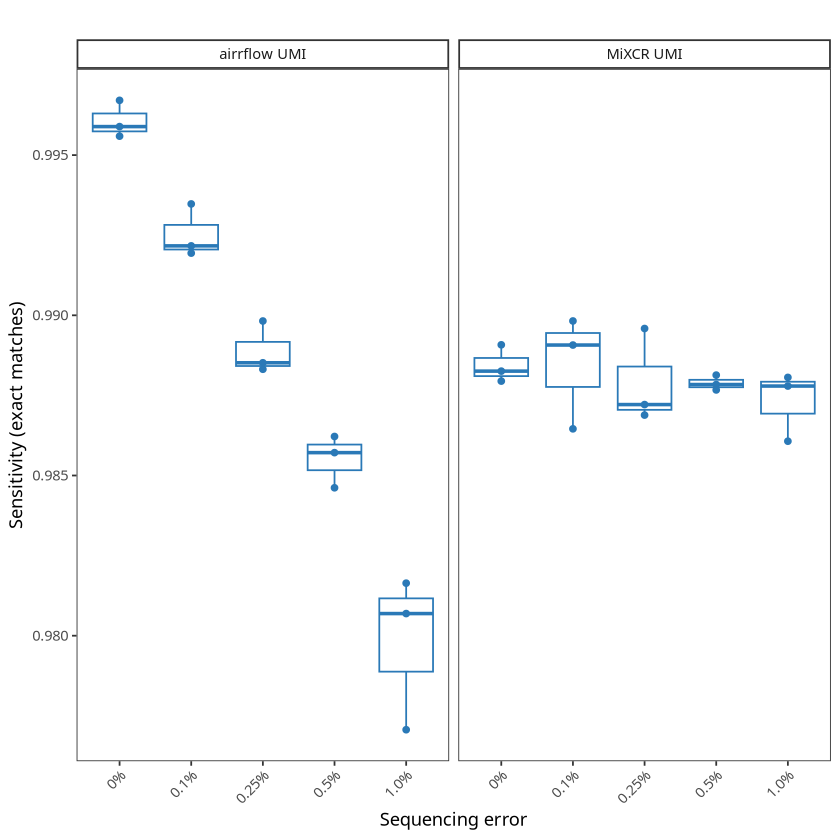

In [124]:
color=colorRampPalette(brewer.pal(6,"Blues"))(7)[6]
all_metrics %>% 
    dplyr::filter(protocol %in% c("umi","mixcrumi")) %>%
    ggplot(aes(x=error, y=sensitivity)) +
      geom_boxplot(position=position_dodge(0.8), color=color) +
      #scale_color_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
      #          labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
       #         values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
        labs(fill="Seq. error", x="", y="Sensitivity",title="") +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
      geom_jitter(position=position_dodge(0.8), color=color) +
      scale_fill_brewer(palette="PRGn") +
        labs(fill="Seq. error", x="Sequencing error", y="Sensitivity (exact matches)",title="") +
        facet_grid(cols=vars(protocol), drop=T, labeller = labeller(protocol=samp.labs))
ggsave(filename = paste0(results_dir,"/Sequence_sensitivity_mut_UMI_toolcomparison_boxplot.pdf"), device="pdf", width = 12, height = 6, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_sensitivity_mut_UMI_toolcomparison_boxplot.png"), device="png", width = 12, height = 6, units="cm")

#### Sensitivity UMI when considering uncertain matches (with N)

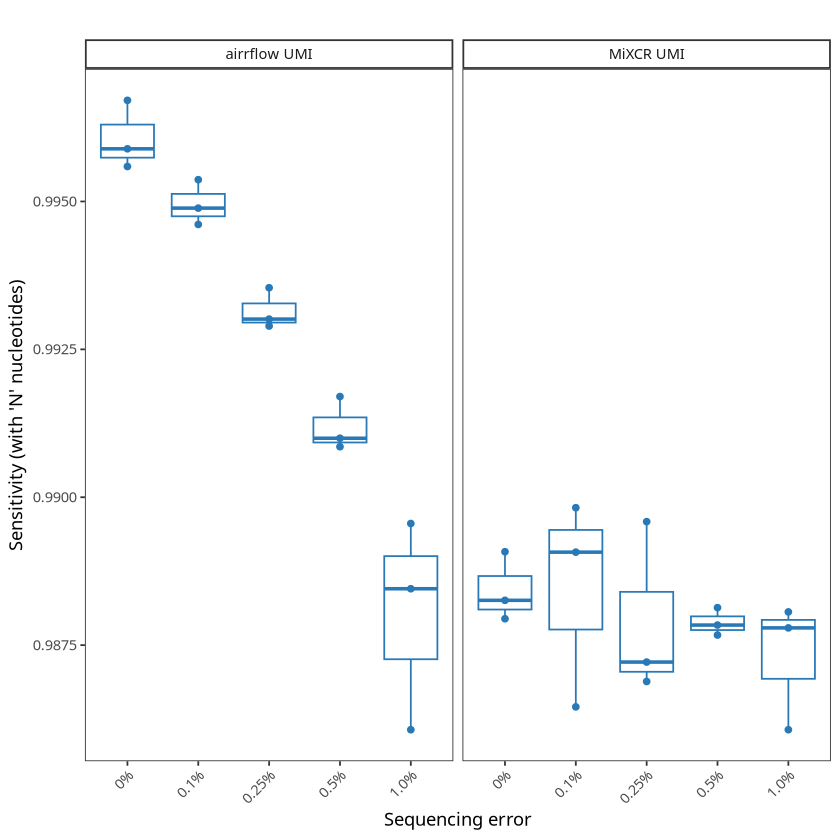

In [125]:
color=colorRampPalette(brewer.pal(6,"Blues"))(7)[6]
all_metrics %>% 
    dplyr::filter(protocol %in% c("umi","mixcrumi")) %>%
    ggplot(aes(x=error, y=sensitivity_uncertain)) +
      geom_boxplot(position=position_dodge(0.8), color=color) +
      #scale_color_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
      #          labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
       #         values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
        labs(fill="Seq. error", x="", y="Sensitivity",title="") +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
      geom_jitter(position=position_dodge(0.8), color=color) +
      scale_fill_brewer(palette="PRGn") +
        labs(fill="Seq. error", x="Sequencing error", y="Sensitivity (with 'N' nucleotides)",title="") +
        facet_grid(cols=vars(protocol), drop=T, labeller = labeller(protocol=samp.labs))
ggsave(filename = paste0(results_dir,"/Sequence_sensitivity_uncertain_mut_UMI_toolcomparison_boxplot.pdf"), device="pdf", width = 12, height = 6, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_sensitivity_uncertain_mut_UMI_toolcomparison_boxplot.png"), device="png", width = 12, height = 6, units="cm")

#### Sensitivity sans-UMI

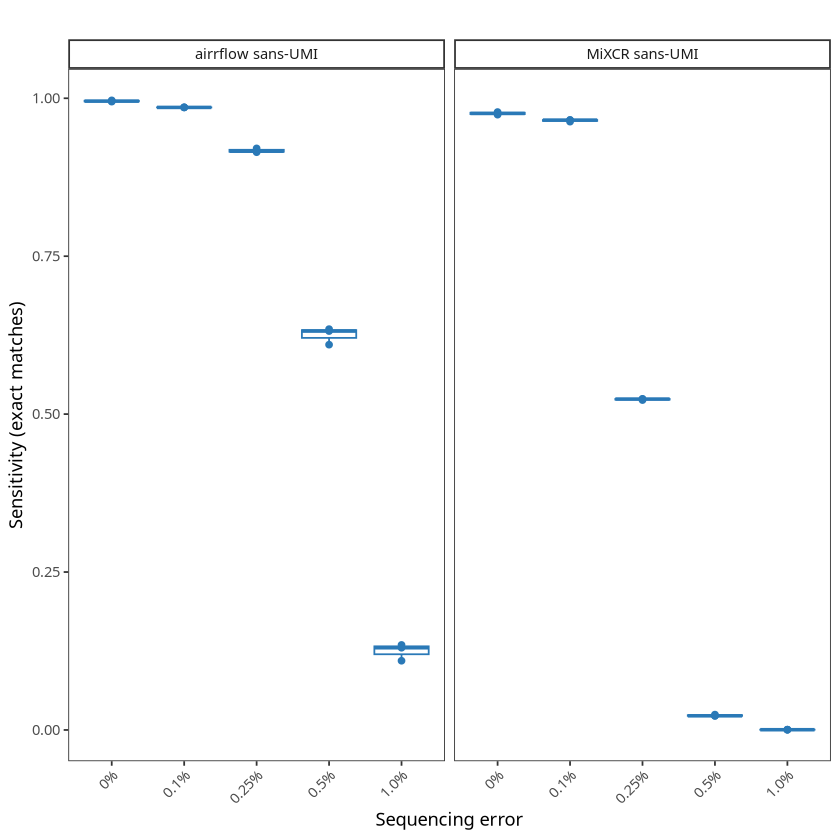

In [126]:
color=colorRampPalette(brewer.pal(6,"Blues"))(7)[6]
all_metrics %>% 
    dplyr::filter(protocol %in% c("sansumi","mixcr")) %>%
    ggplot(aes(x=error, y=sensitivity)) +
      geom_boxplot(position=position_dodge(0.8), color=color) +
      #scale_color_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
      #          labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
       #         values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
      geom_jitter(position=position_dodge(0.8), color=color) +
      scale_fill_brewer(palette="PRGn") +
        labs(fill="Seq. error", x="Sequencing error", y="Sensitivity (exact matches)",title="") +
        facet_grid(cols=vars(protocol), drop=T, labeller = labeller(protocol=samp.labs))
ggsave(filename = paste0(results_dir,"/Sequence_sensitivity_mut_sansUMI_toolcomparison_boxplot.pdf"), device="pdf", width = 12, height = 6, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_sensitivity_mut_sansUMI_toolcomparison_boxplot.png"), device="png", width = 12, height = 6, units="cm")

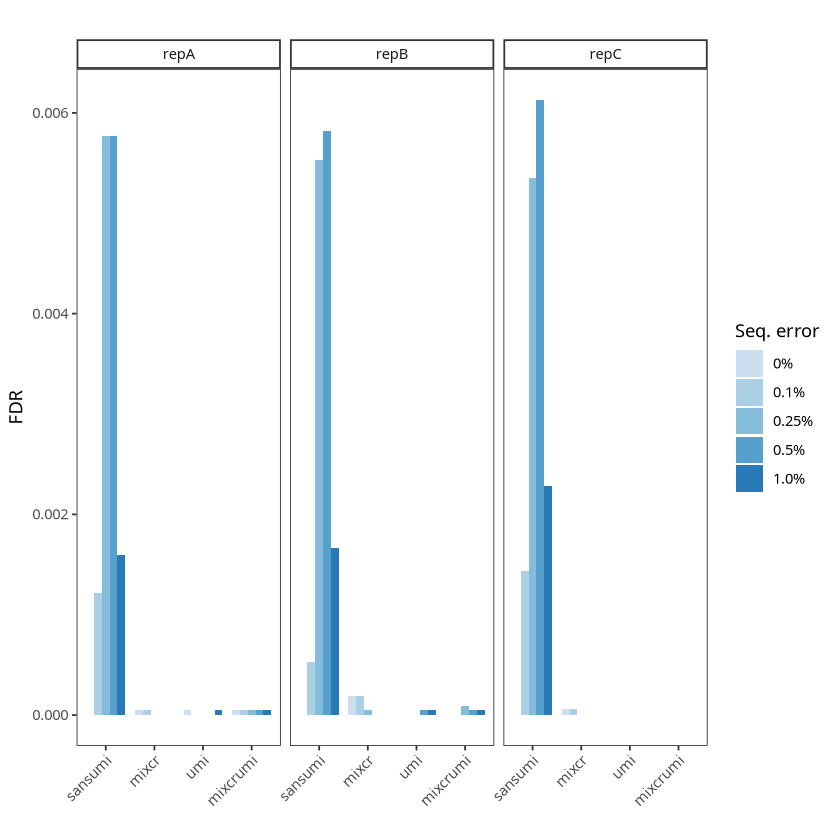

In [127]:
ggplot(all_metrics, aes(x=protocol, y=FDR, fill=error)) +
    geom_bar(stat="identity", position= position_dodge(),width = 0.8) +
    scale_fill_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    labs(fill="Seq. error", x="", y="FDR", title="") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    facet_grid(cols=vars(repertoire), drop=T)
ggsave(filename = paste0(results_dir,"/Sequence_FDR_mut_toolcomparison.pdf"), device="pdf", width = 20, height = 8, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_FDR_mut_toolcomparison.png"), device="png", width = 20, height = 8, units="cm")

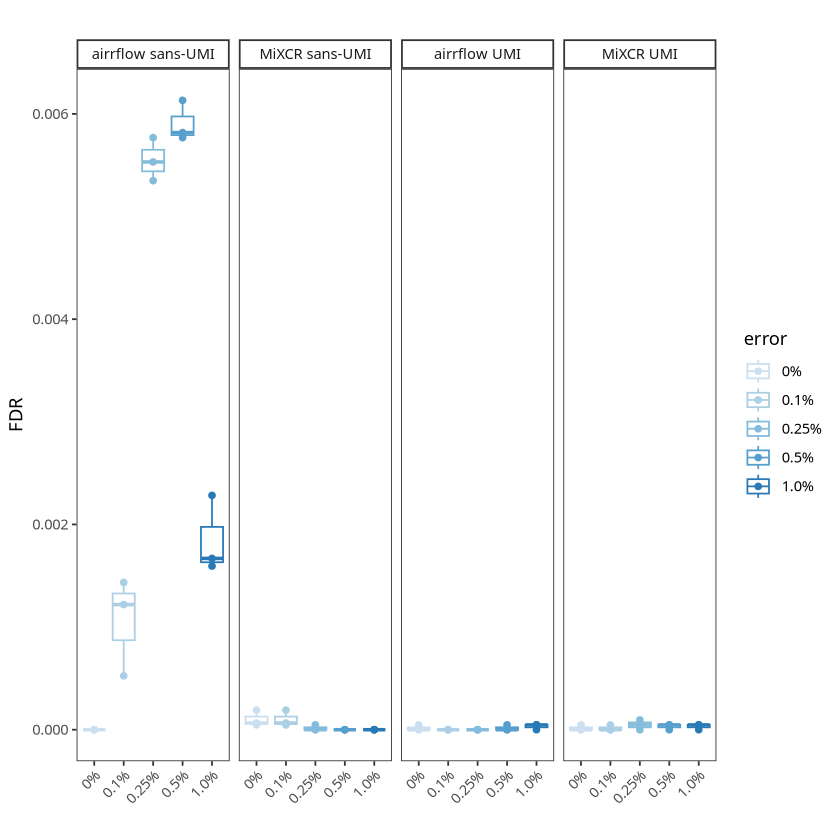

In [128]:
# FDR boxplot over all three repertoires
ggplot(all_metrics, aes(x=error, y=FDR, color=error)) +
  geom_boxplot(position=position_dodge(0.8)) +
  scale_color_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
                labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    labs(fill="Seq. error", x="", y="Sensitivity",title="") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  geom_jitter(position=position_dodge(0.8)) +
    labs(fill="Protocol", x="", y="FDR",title="") +
    facet_grid(cols=vars(protocol), drop=T, labeller = labeller(protocol=samp.labs))
ggsave(filename = paste0(results_dir,"/Sequence_FDR_mut_toolcomparison_boxplot.pdf"), device="pdf", width = 12, height = 6, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_FDR_mut_toolcomparison_boxplot.png"), device="png", width = 12, height = 6, units="cm")

#### FDR UMI

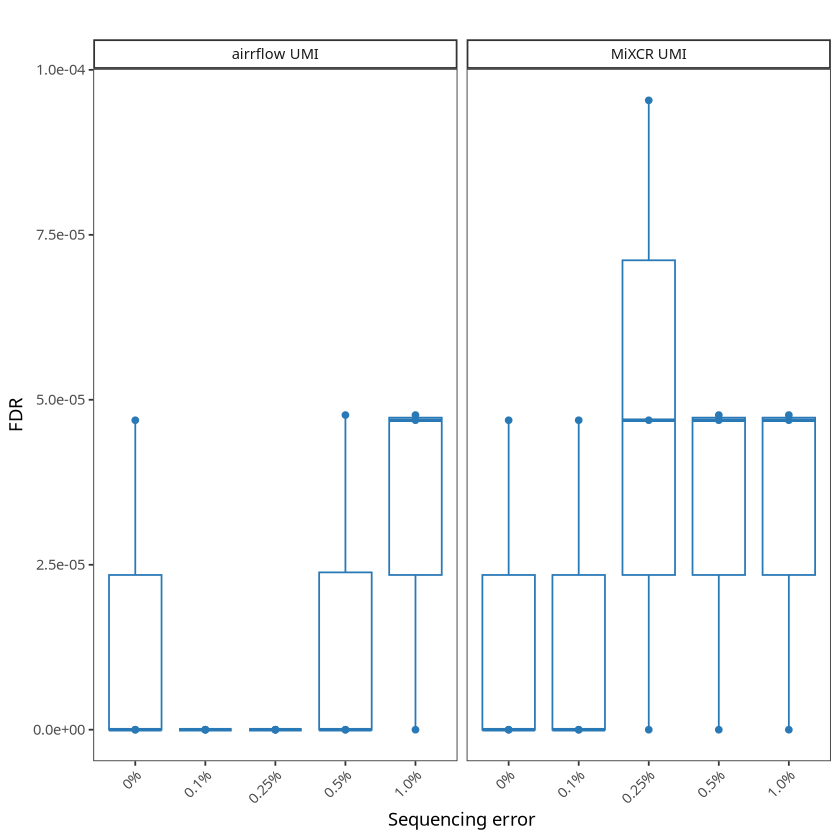

In [129]:
color=colorRampPalette(brewer.pal(6,"Blues"))(7)[6]
all_metrics %>% 
    dplyr::filter(protocol %in% c("umi","mixcrumi")) %>%
    ggplot(aes(x=error, y=FDR)) +
      geom_boxplot(position=position_dodge(0.8), color=color) +
      #scale_color_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
      #          labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
       #         values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
        labs(fill="Seq. error", x="", y="Sensitivity",title="") +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
      geom_jitter(position=position_dodge(0.8), color=color) +
      scale_fill_brewer(palette="PRGn") +
        labs(fill="Seq. error", x="Sequencing error", y="FDR",title="") +
        facet_grid(cols=vars(protocol), drop=T, labeller = labeller(protocol=samp.labs))
ggsave(filename = paste0(results_dir,"/Sequence_FDR_mut_UMI_toolcomparison_boxplot.pdf"), device="pdf", width = 12, height = 6, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_FDR_mut_UMI_toolcomparison_boxplot.png"), device="png", width = 12, height = 6, units="cm")

#### FDR sans-umi

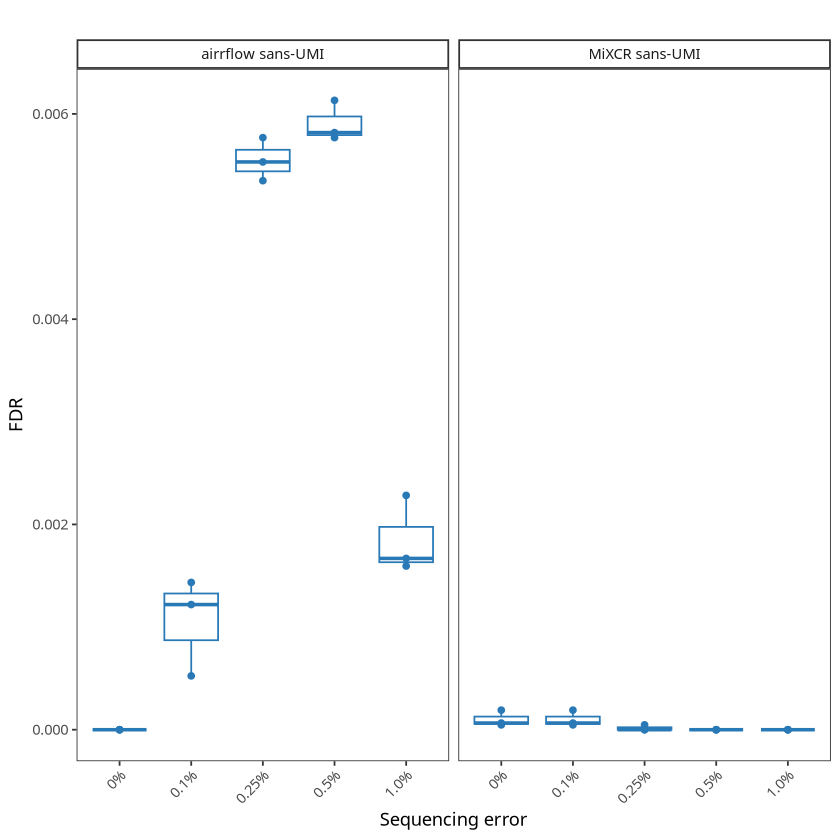

In [130]:
color=colorRampPalette(brewer.pal(6,"Blues"))(7)[6]
all_metrics %>% 
    dplyr::filter(protocol %in% c("sansumi","mixcr")) %>%
    ggplot(aes(x=error, y=FDR)) +
      geom_boxplot(position=position_dodge(0.8), color=color) +
      #scale_color_manual(limits = c("0%","0.1%","0.25%","0.5%","1.0%"),
      #          labels = c("0%","0.1%","0.25%","0.5%","1.0%"),
       #         values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
      geom_jitter(position=position_dodge(0.8), color=color) +
      scale_fill_brewer(palette="PRGn") +
        labs(fill="Seq. error", x="Sequencing error", y="FDR",title="") +
        facet_grid(cols=vars(protocol), drop=T, labeller = labeller(protocol=samp.labs))
ggsave(filename = paste0(results_dir,"/Sequence_FDR_mut_sansUMI_toolcomparison_boxplot.pdf"), device="pdf", width = 12, height = 6, units="cm")
ggsave(filename = paste0(results_dir,"/Sequence_FDR_mut_sansUMI_toolcomparison_boxplot.png"), device="png", width = 12, height = 6, units="cm")

## Count clones

In [131]:
clones = alakazam::countClones(df_all, clone = 'clone_id', groups = 'repertoire')

In [132]:
write.table(x = clones, file = paste0(results_dir,"/","all_repertoires_clones_table_toolcomparison.tsv"), quote = F, sep = "\t", row.names = F, col.names = T)

### N clones tool comparison

In [133]:
head(clones)

repertoire      clone_id seq_count seq_freq 
1 repA_NA_truth   1        10000     0.4684060
2 repA_00_sansumi 1008      9057     0.4267339
3 repA_00_umi     1013      9054     0.4264921
4 repA_01_umi     1007      9048     0.4265510
5 repA_025_umi    994       9037     0.4268373
6 repA_05_umi     987       9003     0.4261573

In [134]:
clone_num = clones %>% dplyr::count(repertoire)
clone_num$rep_id <- sapply(clone_num$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[1])
clone_num$mut_err <- sapply(clone_num$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[2])
clone_num$rep_group <- sapply(clone_num$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[3])
clone_num = clone_num %>% dplyr::filter(rep_group != "truth")


In [135]:
clone_num

repertoire        n     rep_id mut_err rep_group
1  repA_00_mixcr     10519 repA   00      mixcr    
2  repA_00_mixcrumi  10567 repA   00      mixcrumi 
3  repA_00_sansumi    5526 repA   00      sansumi  
4  repA_00_umi        5540 repA   00      umi      
5  repA_01_mixcr     10363 repA   01      mixcr    
6  repA_01_mixcrumi  10562 repA   01      mixcrumi 
7  repA_01_sansumi    5484 repA   01      sansumi  
8  repA_01_umi        5536 repA   01      umi      
9  repA_025_mixcr     5888 repA   025     mixcr    
10 repA_025_mixcrumi 10557 repA   025     mixcrumi 
11 repA_025_sansumi   5132 repA   025     sansumi  
12 repA_025_umi       5520 repA   025     umi      
13 repA_05_mixcr       400 repA   05      mixcr    
14 repA_05_mixcrumi  10574 repA   05      mixcrumi 
15 repA_05_sansumi    3617 repA   05      sansumi  
16 repA_05_umi        5515 repA   05      umi      
17 repA_10_mixcr        12 repA   10      mixcr    
18 repA_10_mixcrumi  10561 repA   10      mixcrumi 
19 repA_10_sansumi     889 repA   10      sansumi  
20 repA_10_umi        5481 repA   10      umi      
21 repB_00_mixcr     13516 repB   00      mixcr    
22 repB_00_mixcrumi  13640 repB   00      mixcrumi 
23 repB_00_sansumi    5741 repB   00      sansumi  
24 repB_00_umi        5802 repB   00      umi      
25 repB_01_mixcr     13336 repB   01      mixcr    
26 repB_01_mixcrumi  13605 repB   01      mixcrumi 
27 repB_01_sansumi    5682 repB   01      sansumi  
28 repB_01_umi        5788 repB   01      umi      
29 repB_025_mixcr     7635 repB   025     mixcr    
30 repB_025_mixcrumi 13627 repB   025     mixcrumi 
31 repB_025_sansumi   5309 repB   025     sansumi  
32 repB_025_umi       5767 repB   025     umi      
33 repB_05_mixcr       448 repB   05      mixcr    
34 repB_05_mixcrumi  13658 repB   05      mixcrumi 
35 repB_05_sansumi    3798 repB   05      sansumi  
36 repB_05_umi        5772 repB   05      umi      
37 repB_10_mixcr         8 repB   10      mixcr    
38 repB_10_mixcrumi  13718 repB   10      mixcrumi 
39 repB_10_sansumi    1010 repB   10      sansumi  
40 repB_10_umi        5758 repB   10      umi      
41 repC_00_mixcr     10373 repC   00      mixcr    
42 repC_00_mixcrumi  10398 repC   00      mixcrumi 
43 repC_00_sansumi    6506 repC   00      sansumi  
44 repC_00_umi        6565 repC   00      umi      
45 repC_01_mixcr     10209 repC   01      mixcr    
46 repC_01_mixcrumi  10385 repC   01      mixcrumi 
47 repC_01_sansumi    6453 repC   01      sansumi  
48 repC_01_umi        6569 repC   01      umi      
49 repC_025_mixcr     5740 repC   025     mixcr    
50 repC_025_mixcrumi 10387 repC   025     mixcrumi 
51 repC_025_sansumi   6113 repC   025     sansumi  
52 repC_025_umi       6555 repC   025     umi      
53 repC_05_mixcr       324 repC   05      mixcr    
54 repC_05_mixcrumi  10390 repC   05      mixcrumi 
55 repC_05_sansumi    4580 repC   05      sansumi  
56 repC_05_umi        6543 repC   05      umi      
57 repC_10_mixcr         6 repC   10      mixcr    
58 repC_10_mixcrumi  10414 repC   10      mixcrumi 
59 repC_10_sansumi    1305 repC   10      sansumi  
60 repC_10_umi        6527 repC   10      umi

In [136]:
write.table(clone_num,paste0(results_dir,"/clone_number_table_toolcomparison.tsv"),sep="\t",row.names=F, col.names = T, quote=F)

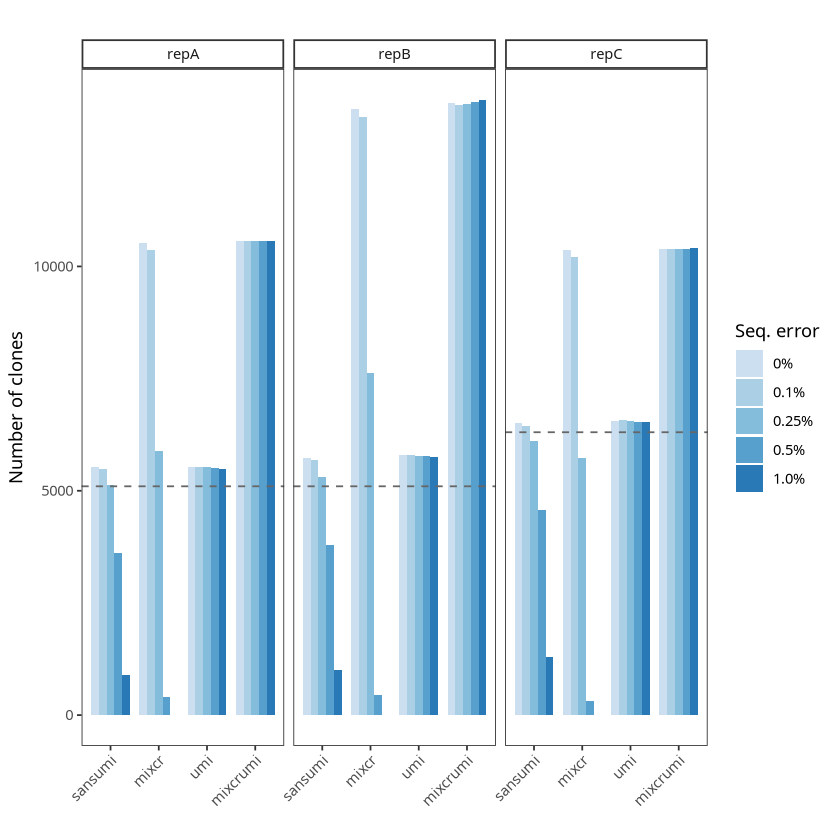

In [137]:
hline_dat = data.frame(rep_id = c("repA","repB","repC"),
                        threshold = c(5100,5100,6305))
clone_num$rep_group <- factor(clone_num$rep_group, levels=c("sansumi","mixcr","umi","mixcrumi"))

p_cn <- ggplot(clone_num, aes(x = rep_group, y = n)) +
    geom_bar(aes(fill = mut_err), stat="identity", position = position_dodge(preserve = "single"), width = 0.8) +
    geom_hline(data=hline_dat, aes(yintercept = threshold), color="grey40", linetype="dashed", linewidth = 0.5) +
    #scale_y_log10(limits = NULL,
    #            breaks = scales::trans_breaks("log10", function(x) 10^x),
     #           labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    scale_fill_manual(limits = c("00", "01", "025","05", "10"),
                labels = c("0%", "0.1%", "0.25%", "0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    ggtitle("Number of clones") +
    facet_grid(cols = vars(rep_id), drop = T) +
    labs(fill="Seq. error", x="", y="Number of clones", title="") +
    theme(axis.text.x = element_text(angle=45, hjust=1))
    
p_cn

In [138]:
ggsave(plot=p_cn, filename = paste0(results_dir,"/Clone_number_repertoires_toolcomparison.pdf"), device="pdf", width = 15, height = 10, units="cm")

In [139]:
ggsave(plot=p_cn, filename = paste0(results_dir,"/Clone_number_repertoires_toolcomparison.png"), device="png", width = 15, height = 10, units="cm")

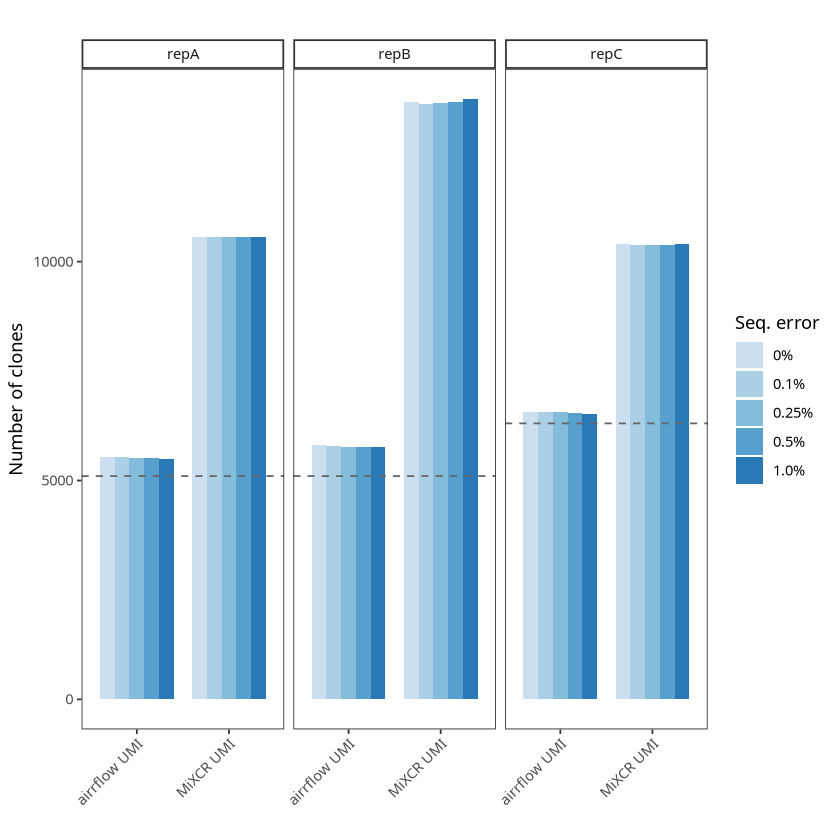

In [140]:
hline_dat = data.frame(rep_id = c("repA","repB","repC"),
                        threshold = c(5100,5100,6305))

clone_num_umi <- clone_num %>% filter(rep_group %in% c("umi","mixcrumi"))

clone_num_umi$rep_group <- factor(clone_num_umi$rep_group, levels=c("umi","mixcrumi"))

p_cn <- ggplot(clone_num_umi, aes(x = rep_group, y = n)) +
    geom_bar(aes(fill = mut_err), stat="identity", position = position_dodge(preserve = "single"), width = 0.8) +
    geom_hline(data=hline_dat, aes(yintercept = threshold), color="grey40", linetype="dashed", linewidth = 0.5) +
    #scale_y_log10(limits = NULL,
    #            breaks = scales::trans_breaks("log10", function(x) 10^x),
    #            labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    scale_fill_manual(limits = c("00", "01", "025","05", "10"),
                labels = c("0%", "0.1%", "0.25%", "0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    ggtitle("Number of clones") +
    scale_x_discrete(labels=c("umi" = "airrflow UMI", "mixcrumi" = "MiXCR UMI")) +
    facet_grid(cols = vars(rep_id), drop = T) +
    labs(fill="Seq. error", x="", y="Number of clones", title="") +
    theme(axis.text.x = element_text(angle=45, hjust=1))
    
p_cn

In [141]:
ggsave(plot=p_cn, filename = paste0(results_dir,"/Clone_number_repertoires_UMI_toolcomparison.pdf"), device="pdf", width = 15, height = 8, units="cm")

In [142]:
ggsave(plot=p_cn, filename = paste0(results_dir,"/Clone_number_repertoires_UMI_toolcomparison.png"), device="png", width = 15, height = 8, units="cm")

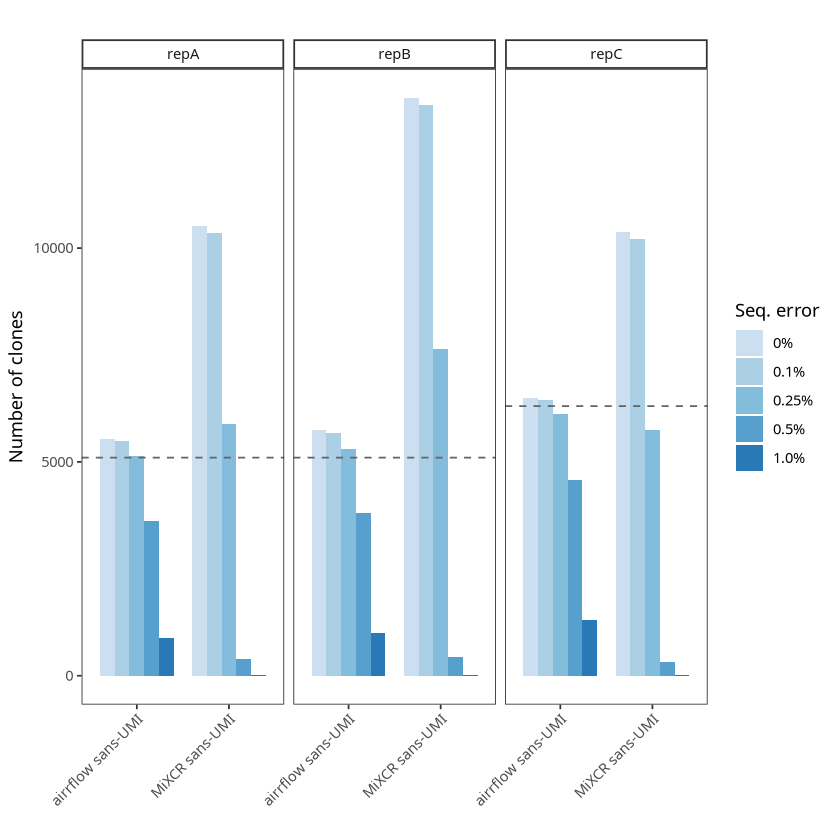

In [143]:
hline_dat = data.frame(rep_id = c("repA","repB","repC"),
                        threshold = c(5100,5100,6305))

clone_num_sansumi <- clone_num %>% filter(rep_group %in% c("sansumi","mixcr"))

clone_num_sansumi$rep_group <- factor(clone_num_sansumi$rep_group, levels=c("sansumi","mixcr"))

p_cn <- ggplot(clone_num_sansumi, aes(x = rep_group, y = n)) +
    geom_bar(aes(fill = mut_err), stat="identity", position = position_dodge(preserve = "single"), width = 0.8) +
    geom_hline(data=hline_dat, aes(yintercept = threshold), color="grey40", linetype="dashed", linewidth = 0.5) +
    #scale_y_log10(limits = NULL,
    #            breaks = scales::trans_breaks("log10", function(x) 10^x),
    #            labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    scale_fill_manual(limits = c("00", "01", "025","05", "10"),
                labels = c("0%", "0.1%", "0.25%", "0.5%","1.0%"),
                values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:6])+
    ggtitle("Number of clones") +
    scale_x_discrete(labels=c("sansumi" = "airrflow sans-UMI", "mixcr" = "MiXCR sans-UMI")) +
    facet_grid(cols = vars(rep_id), drop = T) +
    labs(fill="Seq. error", x="", y="Number of clones", title="") +
    theme(axis.text.x = element_text(angle=45, hjust=1))
    
p_cn

In [144]:
ggsave(plot=p_cn, filename = paste0(results_dir,"/Clone_number_repertoires_sansUMI_toolcomparison.pdf"), device="pdf", width = 15, height = 8, units="cm")

In [145]:
ggsave(plot=p_cn, filename = paste0(results_dir,"/Clone_number_repertoires_sansUMI_toolcomparison.png"), device="png", width = 15, height = 8, units="cm")

### Abundance tool comparison

In [146]:
df_all$rep_id <- sapply(df_all$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[1])
df_all$mut_err <- sapply(df_all$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[2])
df_all$rep_group <- sapply(df_all$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[3])

In [147]:
df_umi <- df_all %>% filter(rep_group %in% c("umi","mixcrumi","truth"))
df_sansumi <- df_all %>% filter(rep_group %in% c("sansumi","mixcr","truth"))

In [148]:
nboot = 100
abund_umi <- alakazam::estimateAbundance(df_umi, group = "repertoire", ci=0.95, nboot=nboot, copy="duplicate_count", min_n = 500)
abund_umi@abundance$rep_id <- sapply(abund_umi@abundance$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[1])
abund_umi@abundance$mut_err <- sapply(abund_umi@abundance$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[2])
abund_umi@abundance$rep_group <- sapply(abund_umi@abundance$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[3])


In [149]:
write.table(abund_umi@abundance,paste0(results_dir,"/clonal_abundance_table_umi_toolcomparison.tsv"),sep="\t",row.names=F, col.names = T, quote=F)

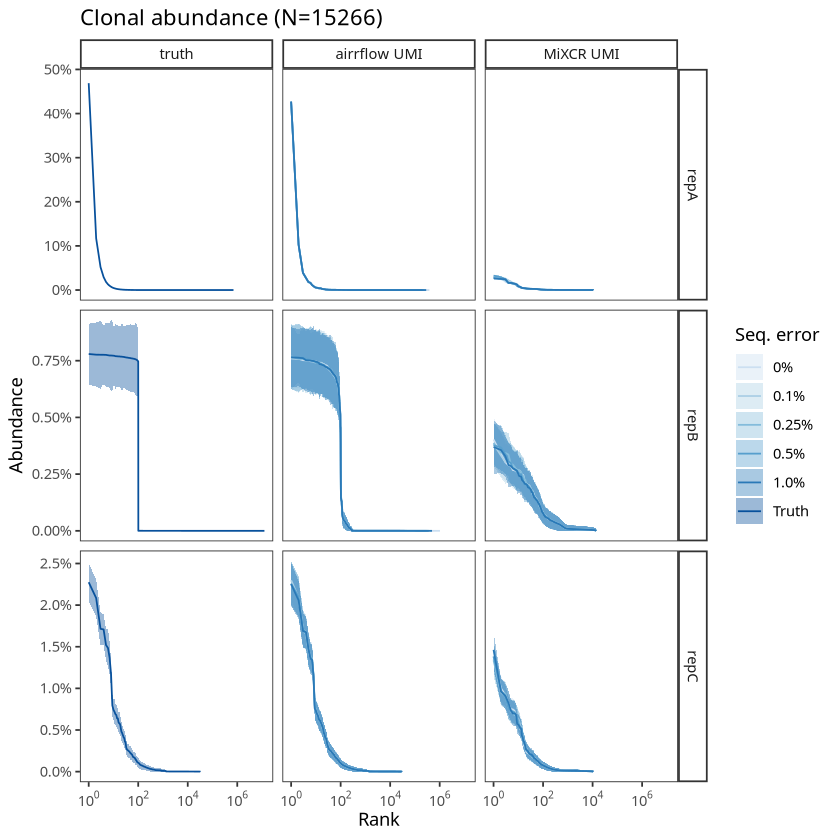

In [150]:
abund_main <- paste0("Clonal abundance (N=", abund_umi@n[1], ")")

abund_umi@abundance$rep_group <- factor(abund_umi@abundance$rep_group, levels=c("truth","sansumi","mixcr","umi","mixcrumi"))

samp.labs <- c("truth", "airrflow sans-UMI", "airrflow UMI", "MiXCR sans-UMI", "MiXCR UMI")
names(samp.labs) <- c("truth", "sansumi", "umi", "mixcr", "mixcrumi")

p_ca <- ggplot(abund_umi@abundance, aes(x = rank, y = p)) +
    geom_ribbon(aes(ymin = lower,
                    ymax = upper, fill = mut_err), alpha = 0.4) +
    geom_line(aes(color = mut_err)) +
    scale_color_manual(limits = c("00", "01", "025","05", "10", "NA"),
                    labels = c("0%", "0.1%", "0.25%", "0.5%","1.0%","Truth"),
                    values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:7])+
    scale_fill_manual(limits = c("00", "01", "025", "05","10", "NA"),
                    labels = c("0%", "0.1%", "0.25%", "0.5%","1.0%","Truth"),
                    values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:7])+
    labs(fill="Seq. error", color="Seq. error", x="Rank", y="Abundance", title=abund_main) +
    scale_x_log10(limits = NULL,
                breaks = scales::trans_breaks("log10", function(x) 10^x),
                labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    scale_y_continuous(labels = scales::percent) +
    facet_grid(cols = vars(rep_group), rows=vars(rep_id), drop = T, scales = "free_y", labeller = labeller(rep_group=samp.labs))
p_ca

In [151]:
ggsave(plot=p_ca, filename = paste0(results_dir,"/Clonal_abundance_repertoires_toolcomparison.pdf"), device="pdf", width = 20, height = 10, units="cm")

In [152]:
ggsave(plot=p_ca, filename = paste0(results_dir,"/Clonal_abundance_repertoires_toolcomparison.png"), device="png", width = 20, height = 10, units="cm")

In [153]:
nboot = 100
abund_sansumi <- alakazam::estimateAbundance(df_sansumi, group = "repertoire", ci=0.95, nboot=nboot, copy="duplicate_count", min_n = 500)
abund_sansumi@abundance$rep_id <- sapply(abund_sansumi@abundance$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[1])
abund_sansumi@abundance$mut_err <- sapply(abund_sansumi@abundance$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[2])
abund_sansumi@abundance$rep_group <- sapply(abund_sansumi@abundance$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[3])


Warning message in alakazam::estimateAbundance(df_sansumi, group = "repertoire", :
“Not all groups passed threshold min_n=500. Excluded: repA_10_mixcr, repB_10_mixcr, repC_10_mixcr”


In [154]:
write.table(abund_sansumi@abundance,paste0(results_dir,"/clonal_abundance_table_sansumi_toolcomparison.tsv"),sep="\t",row.names=F, col.names = T, quote=F)

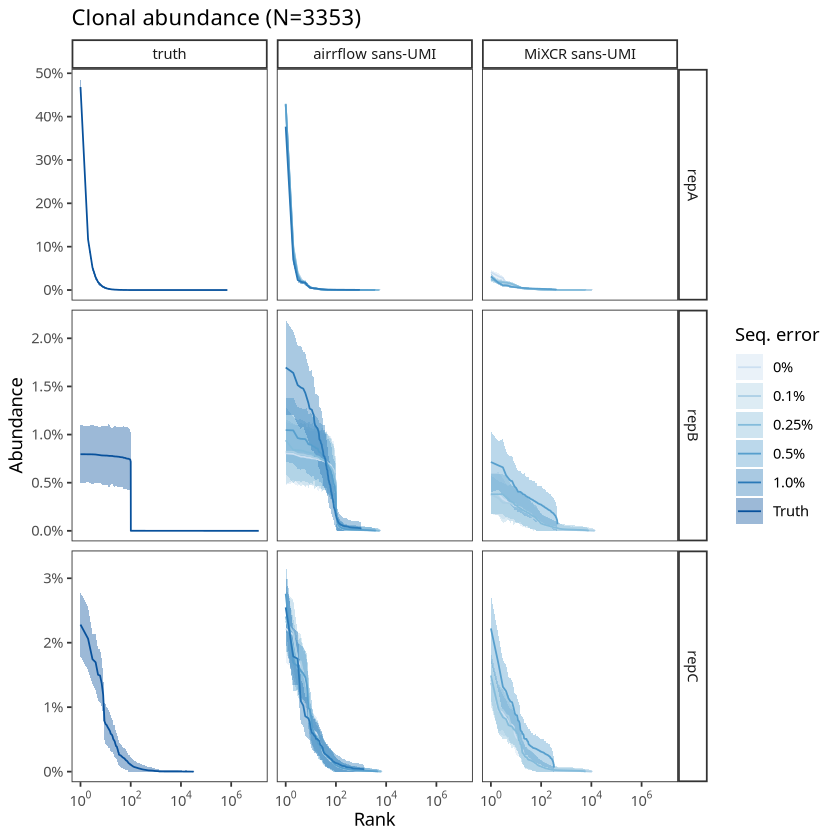

In [155]:
abund_main <- paste0("Clonal abundance (N=", abund_sansumi@n[1], ")")

abund_sansumi@abundance$rep_group <- factor(abund_sansumi@abundance$rep_group, levels=c("truth","sansumi","mixcr","umi","mixcrumi"))

samp.labs <- c("truth", "airrflow sans-UMI", "airrflow UMI", "MiXCR sans-UMI", "MiXCR UMI")
names(samp.labs) <- c("truth", "sansumi", "umi", "mixcr", "mixcrumi")

p_ca <- ggplot(abund_sansumi@abundance, aes(x = rank, y = p)) +
    geom_ribbon(aes(ymin = lower,
                    ymax = upper, fill = mut_err), alpha = 0.4) +
    geom_line(aes(color = mut_err)) +
    scale_color_manual(limits = c("00", "01", "025","05", "10", "NA"),
                    labels = c("0%", "0.1%", "0.25%", "0.5%","1.0%","Truth"),
                    values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:7])+
    scale_fill_manual(limits = c("00", "01", "025", "05","10", "NA"),
                    labels = c("0%", "0.1%", "0.25%", "0.5%","1.0%","Truth"),
                    values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:7])+
    labs(fill="Seq. error", color="Seq. error", x="Rank", y="Abundance", title=abund_main) +
    scale_x_log10(limits = NULL,
                breaks = scales::trans_breaks("log10", function(x) 10^x),
                labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    scale_y_continuous(labels = scales::percent) +
    facet_grid(cols = vars(rep_group), rows=vars(rep_id), drop = T, scales = "free_y", labeller = labeller(rep_group=samp.labs))
p_ca

In [156]:
ggsave(plot=p_ca, filename = paste0(results_dir,"/Clonal_abundance_repertoires_sansumi_toolcomparison.pdf"), device="pdf", width = 20, height = 10, units="cm")

In [157]:
ggsave(plot=p_ca, filename = paste0(results_dir,"/Clonal_abundance_repertoires_sansumi_toolcomparison.png"), device="png", width = 20, height = 10, units="cm")

### Diversity tools

div_umi <- alakazam::alphaDiversity(abund_umi, group="repertoire", min_q=0, max_q=4, step_q=0.05, ci=0.95, nboot=nboot)

div_umi@diversity$rep_id <- sapply(div_umi@diversity$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[1])
div_umi@diversity$mut_err <- sapply(div_umi@diversity$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[2])
div_umi@diversity$rep_group <- sapply(div_umi@diversity$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[3])


div_umi@diversity$rep_group <- factor(div_umi@diversity$rep_group, levels=c("truth","sansumi","mixcr","umi","mixcrumi"))

sample_main <- paste0("Clonal diversity (N=", div_umi@n[1], ")")
div_p <- ggplot(div_umi@diversity, aes(x = q, y = d)) +
    geom_ribbon(aes(ymin = d_lower,
                    ymax = d_upper,
                    fill = mut_err), alpha = 0.4) +
    geom_line(aes(color = mut_err)) +
    scale_color_manual(limits = c("00", "01", "025","05", "10", "NA"),
                    labels = c("0%", "0.1%", "0.25%", "0.5%","1.0%","Truth"),
                    values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:7])+
    scale_fill_manual(limits = c("00", "01", "025", "05", "10", "NA"),
                    labels = c("0%", "0.1%", "0.25%", "0.5%","1.0%","Truth"),
                    values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:7])+
    labs(fill="Seq. error", color="Seq. error", x="q", y=expression(""^q * D), title=sample_main) +
    facet_grid(cols=vars(rep_group), rows=vars(rep_id), labeller = labeller(rep_group=samp.labs))
div_p

ggsave(plot=div_p, filename = paste0(results_dir,"/Clonal_diversity_repertoires_umi_toolcomparison.pdf"), device="pdf", width = 12, height = 6, units="cm")

ggsave(plot=div_p, filename = paste0(results_dir,"/Clonal_diversity_repertoires_umi_toolcomparison.png"), device="png", width = 12, height = 6, units="cm")

write.table(div_umi@diversity,paste0(results_dir,"/diversity_table_umi_toolcomparison.tsv"),sep="\t",row.names=F, col.names = T, quote=F)

div_sansumi <- alakazam::alphaDiversity(abund_sansumi, group="repertoire", min_q=0, max_q=4, step_q=0.05, ci=0.95, nboot=nboot)

div_sansumi@diversity$rep_id <- sapply(div_sansumi@diversity$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[1])
div_sansumi@diversity$mut_err <- sapply(div_sansumi@diversity$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[2])
div_sansumi@diversity$rep_group <- sapply(div_sansumi@diversity$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[3])


div_sansumi@diversity$rep_group <- factor(div_sansumi@diversity$rep_group, levels=c("truth","sansumi","mixcr","umi","mixcrumi"))

sample_main <- paste0("Clonal diversity (N=", div_sansumi@n[1], ")")
div_p <- ggplot(div_sansumi@diversity, aes(x = q, y = d)) +
    geom_ribbon(aes(ymin = d_lower,
                    ymax = d_upper,
                    fill = mut_err), alpha = 0.4) +
    geom_line(aes(color = mut_err)) +
    scale_color_manual(limits = c("00", "01", "025","05", "10", "NA"),
                    labels = c("0%", "0.1%", "0.25%", "0.5%","1.0%","Truth"),
                    values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:7])+
    scale_fill_manual(limits = c("00", "01", "025", "05", "10", "NA"),
                    labels = c("0%", "0.1%", "0.25%", "0.5%","1.0%","Truth"),
                    values = colorRampPalette(brewer.pal(6, "Blues"))(7)[2:7])+
    labs(fill="Seq. error", color="Seq. error", x="q", y=expression(""^q * D), title=sample_main) +
    facet_grid(cols=vars(rep_group), rows=vars(rep_id), labeller = labeller(rep_group=samp.labs))
div_p

ggsave(plot=div_p, filename = paste0(results_dir,"/Clonal_diversity_repertoires_sansumi_toolcomparison.pdf"), device="pdf", width = 12, height = 6, units="cm")

ggsave(plot=div_p, filename = paste0(results_dir,"/Clonal_diversity_repertoires_sansumi_toolcomparison.png"), device="png", width = 12, height = 6, units="cm")

write.table(div_sansumi@diversity,paste0(results_dir,"/diversity_table_sansumi_toolcomparison.tsv"),sep="\t",row.names=F, col.names = T, quote=F)

### VDJ gene usage

In [158]:
family <- countGenes(df_umi, gene="v_call", groups="repertoire", mode="gene")
family$rep_id <- sapply(family$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[1])
family$mut_err <- sapply(family$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[2])
family$rep_group <- sapply(family$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[3])

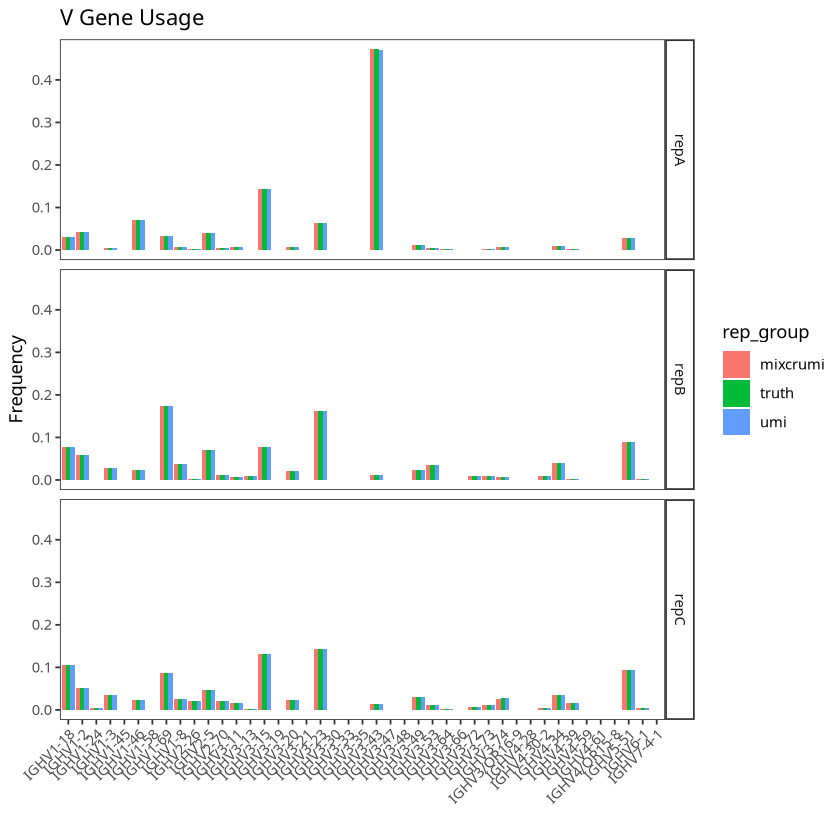

In [159]:
family_nomut <- family %>% filter(mut_err == "00" | mut_err =="NA") %>%
                            arrange(-seq_count)
ggplot(family_nomut, aes(x=gene, y=seq_freq, fill=rep_group)) +
    scale_color_brewer(palette="Set1") +
    geom_bar(position = "dodge", stat="identity") +
    #scale_fill_manual(limits = c("truth", "umi", "mixcrumi"),
    #                labels = c("Truth", "airrflow UMI", "MiXCR UMI")) +
    ggtitle("V Gene Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    facet_grid(rows=vars(rep_id),labeller = labeller(rep_group=samp.labs)) +
    ylab("Frequency") +
    xlab("")

ggsave(filename = paste0(results_dir, "/V_gene_distribution_by_clone_umi.pdf"), width = 20, height = 10, units = "cm")
ggsave(filename = paste0(results_dir, "/V_gene_distribution_by_clone_umi.png"), width = 20, height = 10, units = "cm")

write.table(family, file = paste0(results_dir, "/V_gene_distribution_by_clone_data_umi.tsv"), sep = "\t", quote = F, row.names = F)

In [160]:
family <- countGenes(df_sansumi, gene="v_call", groups="repertoire", mode="gene")
family$rep_id <- sapply(family$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[1])
family$mut_err <- sapply(family$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[2])
family$rep_group <- sapply(family$repertoire, function(x) unlist(strsplit(as.character(x), "_"))[3])

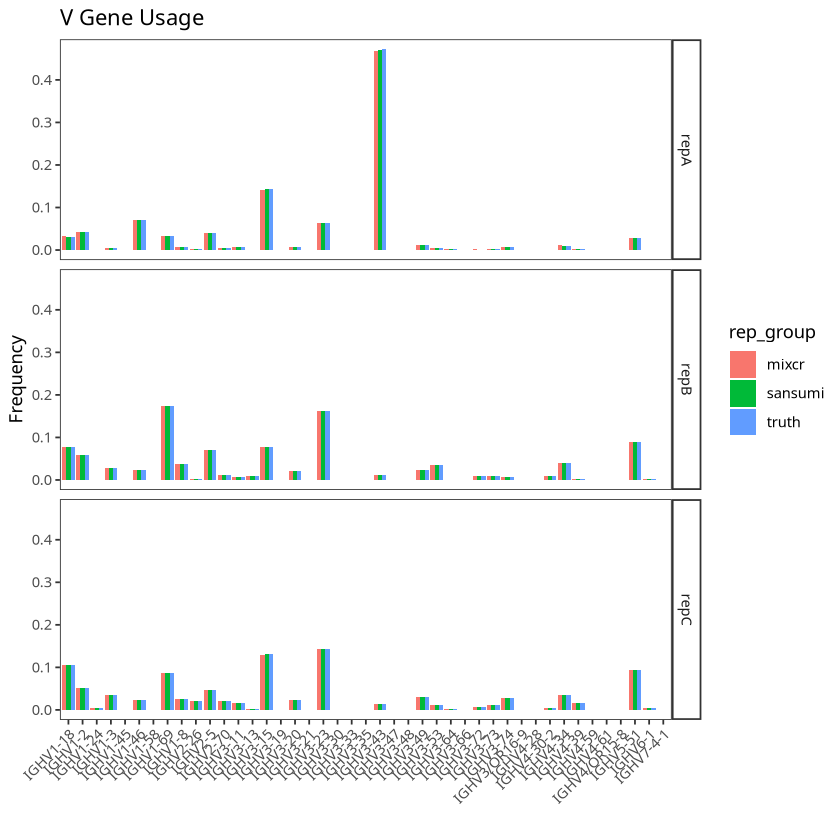

In [161]:
family_nomut <- family %>% filter(mut_err == "00" | mut_err =="NA") %>%
                            arrange(-seq_count)
ggplot(family_nomut, aes(x=gene, y=seq_freq, fill=rep_group)) +
    scale_color_brewer(palette="Set1") +
    geom_bar(position = "dodge", stat="identity") +
    #scale_fill_manual(limits = c("truth", "umi", "mixcrumi"),
    #                labels = c("Truth", "airrflow UMI", "MiXCR UMI")) +
    ggtitle("V Gene Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    facet_grid(rows=vars(rep_id),labeller = labeller(rep_group=samp.labs)) +
    ylab("Frequency") +
    xlab("")

ggsave(filename = paste0(results_dir, "/V_gene_distribution_by_clone_sansumi.pdf"), width = 20, height = 10, units = "cm")
ggsave(filename = paste0(results_dir, "/V_gene_distribution_by_clone_sansumi.png"), width = 20, height = 10, units = "cm")

write.table(family, file = paste0(results_dir, "/V_gene_distribution_by_clone_data_sansumi.tsv"), sep = "\t", quote = F, row.names = F)